# Buy Rough, Sell Smooth

- Based on the paper of the same name by Paul Glasserman, Pu He (December 2018)

### Team Members: 
    - Aadi Gupta        - 12449592
    - Mahima Raut       - 12458565
    - Pravallika Reddy  - 12457993
    - Rajdeep Das       - 12451135
    - Roshan Surabhi    - 12455355

In [207]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import statsmodels.api as sm
import warnings
from scipy.linalg import eigh
warnings.filterwarnings(action='ignore')
import quandl
import requests
import json
import time
import datetime
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit

# Introduction

Recent work has documented roughness in the time series of stock market volatility and investigated its implications for option pricing. We study a strategy for trading stocks based on measures of their implied and realized roughness. A strategy that goes long the roughest-volatility stocks and short the smoothest-volatility stocks earns statistically significant excess annual returns of 6% or more (according to the paper), depending on the time period and strategy details. The profitability of the strategy is not explained by standard factors. We compare alternative measures of roughness in volatility and find that the profitability of the strategy is greater when we sort stocks based on implied rather than realized roughness. We interpret the profitability of the strategy as compensation for near-term idiosyncratic event risk.

# Implementation of H values / Technical Work

## Realized Roughness

### Theory of implementation

### Fractional Brownian Motion
- Rough models of stochastic volatility replace an ordinary Brownian motion driving the dynamics of volatility with a fractional 
Brownian motion (fBM). 
- The fBM family, indexed by a single parameter, includes ordinary Brownian motion and also processes with smoother and rougher paths.
- A fractional Brownian motion with Hurst parameter $H ∈ (0, 1)$ is a mean-zero Gaussian process ${W_t^H , −∞ < t < ∞}$ with stationary increments and covariance function given by
$$
\mathbb{E} \big[ W^H (t) W^H (s) \big] = \frac{1}{2} \Big( |t|^{2H} + |s|^{2H} - |t - s|^{2H} \Big)  \quad\quad -(1)
$$

- The case $H = 1/2$ corresponds to ordinary Brownian motion. With $H ∈ (1/2,1)$, fractional Brownian motion exhibits long-range dependence; processes with $H ∈ (0, 1/2)$ have paths that are rougher than those of ordinary Brownian motion, with small H indicating greater roughness.
- We have the following property of the moments of the increments of fractional Brownian motion. For any $t ∈ R$, and $∆ ≥ 0$, and any $q > 0$,
$$
\mathbb{E} \big[ |W^H_{t+\Delta} - W^H_t|^q \big] = \mathbb{E} \big[ |Z|^q \big] \Delta^ {qH}, 
\quad Z \sim N(0,1)  \quad\quad -(2)
$$

- With smaller H, increments over a short interval ∆ have larger moments.



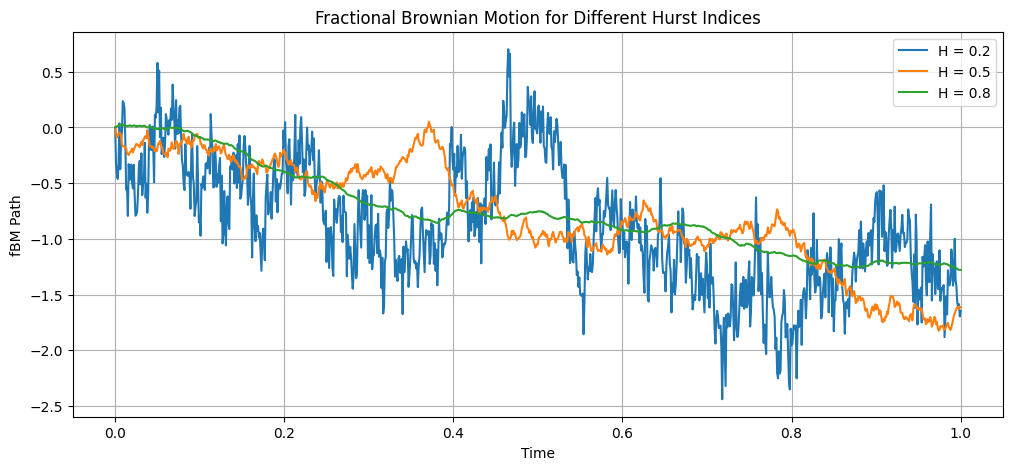

In [208]:
def fbm(T, N, H):
    dt = T / N
    t = np.linspace(0, T, N+1)
    gamma = np.zeros((N+1, N+1))
    for i in range(N+1):
        for j in range(N+1):
            gamma[i, j] = 0.5 * (abs(i * dt)**(2*H) + abs(j * dt)**(2*H) - abs((i-j) * dt)**(2*H))
    eigvals, eigvecs = eigh(gamma)
    eigvals = np.maximum(eigvals, 0) 
    L = eigvecs @ np.diag(np.sqrt(eigvals))
    np.random.seed(42)
    Z = np.random.randn(N+1)
    W = np.dot(L, Z)
    return t, W
T = 1.0   
N = 1000 
H_values = [0.2, 0.5, 0.8]
plt.figure(figsize=(12, 5))
for H in H_values:
    t, W = fbm(T, N, H)
    plt.plot(t, W, label=f"H = {H}")
plt.xlabel("Time")
plt.ylabel("fBM Path")
plt.title("Fractional Brownian Motion for Different Hurst Indices")
plt.legend()
plt.grid()
plt.show(block=True)

### Rough Volatility Model
- As an example of a rough volatility model for an asset price ${St, t ≥ 0}$, we could set

$$
d \log S_t = \mu \, dt + \sigma_t \, dW_t, \quad \quad - (3)
$$
$$
d \log \sigma_t = \nu \, dW_t^H; \quad \quad -(4)
$$

- Here, $μ, κ, m,$ and $ν$ are constants, $W$ is an ordinary Brownian motion, $W^H$ is a fractional Brownian motion with $H ∈ (0,1/2)$, and $W$ and $W^H$ may be correlated. The parameter $H$ determines the roughness of the volatility process.
- Rough volatility arises from mixing mean-reverting volatility processes with different speeds of mean reversion, driven by an ordinary Brownian motion, including components with arbitrarily fast mean reversion.



### One method of estimating realized H values
- If we could observe logσt at times t = 0,∆,2∆,... for some small ∆ > 0, we could estimate H by estimating the below equation for various values of q > 0, and then applying (2) to extract H 

$$
\mathbb{E} \big[ | \log \sigma_{t+\Delta} - \log \sigma_t |^q \big] \quad\quad - (5)
$$



### Implemented methodology of estimating realized H values
- In practice, $σ_t$ cannot be observed and must be estimated, so we proceed as follows. Using trades from the Trade and Quote (TAQ) data, we estimate the daily integrated variance of returns; taking the square root yields our estimated daily volatility.

- The rest of the estimation procedure works with these daily volatilities, which we write as $σ_d$, with $d$ indexing days. We apply (5) with $q = 2$, estimating second moments over intervals of ℓ days, ℓ= 1,2,...,10. In each month, for each stock and each lag ℓ, we calculate (T is the number of days in the month):
$$
z_2(\ell) = \frac{1}{T - \ell} \sum_{d=1}^{T - \ell} \big( \log \hat{\sigma}_{d+\ell} - \log \hat{\sigma}_d \big)^2, \quad\quad -(6)
$$

- Based on (2), we expect
$$
z_2(\ell) \approx \nu^2 \ell^{2H}. \quad\quad -(7)
$$

- So to estimate H we run a regression

$$
\log z_2(\ell) = \beta_1 + \beta_2 \log \ell + \epsilon, \quad\quad -(8)
$$
- We estimate H as $β_2/2$. We also estimate the volatility of volatility $ν$ by setting $log ν = β_1/2$. This procedure yields an estimate of $H$ (and $ν$) for each stock in each month.


### Data import and cleaning

#### Total universe 

- We considered 11 major industries with 10 largest constituent stocks by index weight (as of 31 Dec 2024, src:CRSP) each:

    - US Consumer Discretionary : 	AMZN  TSLA  HD  WMT  MCD  BKNG  LOW  TJX  UBER  SBUX
    - US Consumer Staples : 		COST  PG  KO  PEP  PM  MO  MDLZ  CL  KMB  KVUE
    - US Energy :   			XOM  CVX  COP  EOG  WMB  OKE  SLB  KMI  PSX  LNG
    - US Financials : 			BRK.A/BRK.B  JPM  V  MA  BAC  WFC  GS  SPGI  MS  AXP
    - US Healthcare :			LLY  UNH  JNJ  ABBV  MRK  TMO  ABT  ISRG  PFE  DHR
    - US Industrials :			ACN  CAT  GE  RTX  HON  UNP  BA  ETN  ADP  LMT
    - US Materials :			LIN  SHW  APD  ECL  FCX  NEM  VMC  MLM  DD  DOW
    - US Media & Communications :  	GOOGL  META  NFLX  DIS  T  VZ  CMCSA  TMUS  EA  RBLX
    - US Real Estate & REITs :		PLD  EQIX  AMT  WELL  DLR  SPG  PSA  O  CBRE  CCI
    - US Technology : 			AAPL  MSFT  NVDA  AVGO  CRM  ORCL  NOW  CSCO  IBM  AMD
    - US Utilities :				NEE  SO  DUK  CEG  SRE  AEP  VST  D  PCG  PEG

The paper conducts their study on a timeframe from 2000 to 2018, while we chose a timeframe from 2010 to 2023 to make it computationally affordable as well as to test the theory on recent and turbulent (post Covid19) conditions


In [209]:
industries = pd.read_csv('./industry.csv')
industries['industry'] = industries.industry.str.replace('CRSP ', '', regex=True)
industries['industry'] = industries.industry.str.replace(' Index', '', regex=True)
industries['top_tickers'] = industries['top_tickers'].str.split()
industries = industries.explode('top_tickers').reset_index(drop=True)
industries.head()

industry top_tickers
0  US Consumer Discretionary        AMZN
1  US Consumer Discretionary        TSLA
2  US Consumer Discretionary          HD
3  US Consumer Discretionary         WMT
4  US Consumer Discretionary         MCD

In [210]:
vols = pd.read_csv('./Realized_H/daily_vol_series.csv')
vols = vols[vols['SYM_ROOT'] == vols['symbol']]
vols = vols.merge(industries, left_on='SYM_ROOT', right_on='top_tickers', how='inner')
vols = vols[['DATE', 'SYM_ROOT', 'industry', 'ivol_t', 'ivol_q']]
vols = vols[vols['DATE'] <= '2023-08-31']
vols['month'] = pd.to_datetime(vols['DATE']).dt.month
vols['year'] = pd.to_datetime(vols['DATE']).dt.year
vols['ivol_q_log'] = np.log(vols['ivol_q'])
vols['DATE'] = pd.to_datetime(vols['DATE'])
vols.head()

DATE SYM_ROOT       industry        ivol_t        ivol_q  month  year  \
0 2010-01-04     AAPL  US Technology  6.140084e-09  4.300400e-10      1  2010   
1 2010-01-05     AAPL  US Technology  5.997564e-09  3.934783e-10      1  2010   
2 2010-01-06     AAPL  US Technology  5.785301e-09  5.765893e-10      1  2010   
3 2010-01-07     AAPL  US Technology  9.102045e-09  6.425180e-10      1  2010   
4 2010-01-08     AAPL  US Technology  6.838924e-09  5.694237e-10      1  2010   

   ivol_q_log  
0  -21.567143  
1  -21.655995  
2  -21.273891  
3  -21.165626  
4  -21.286396

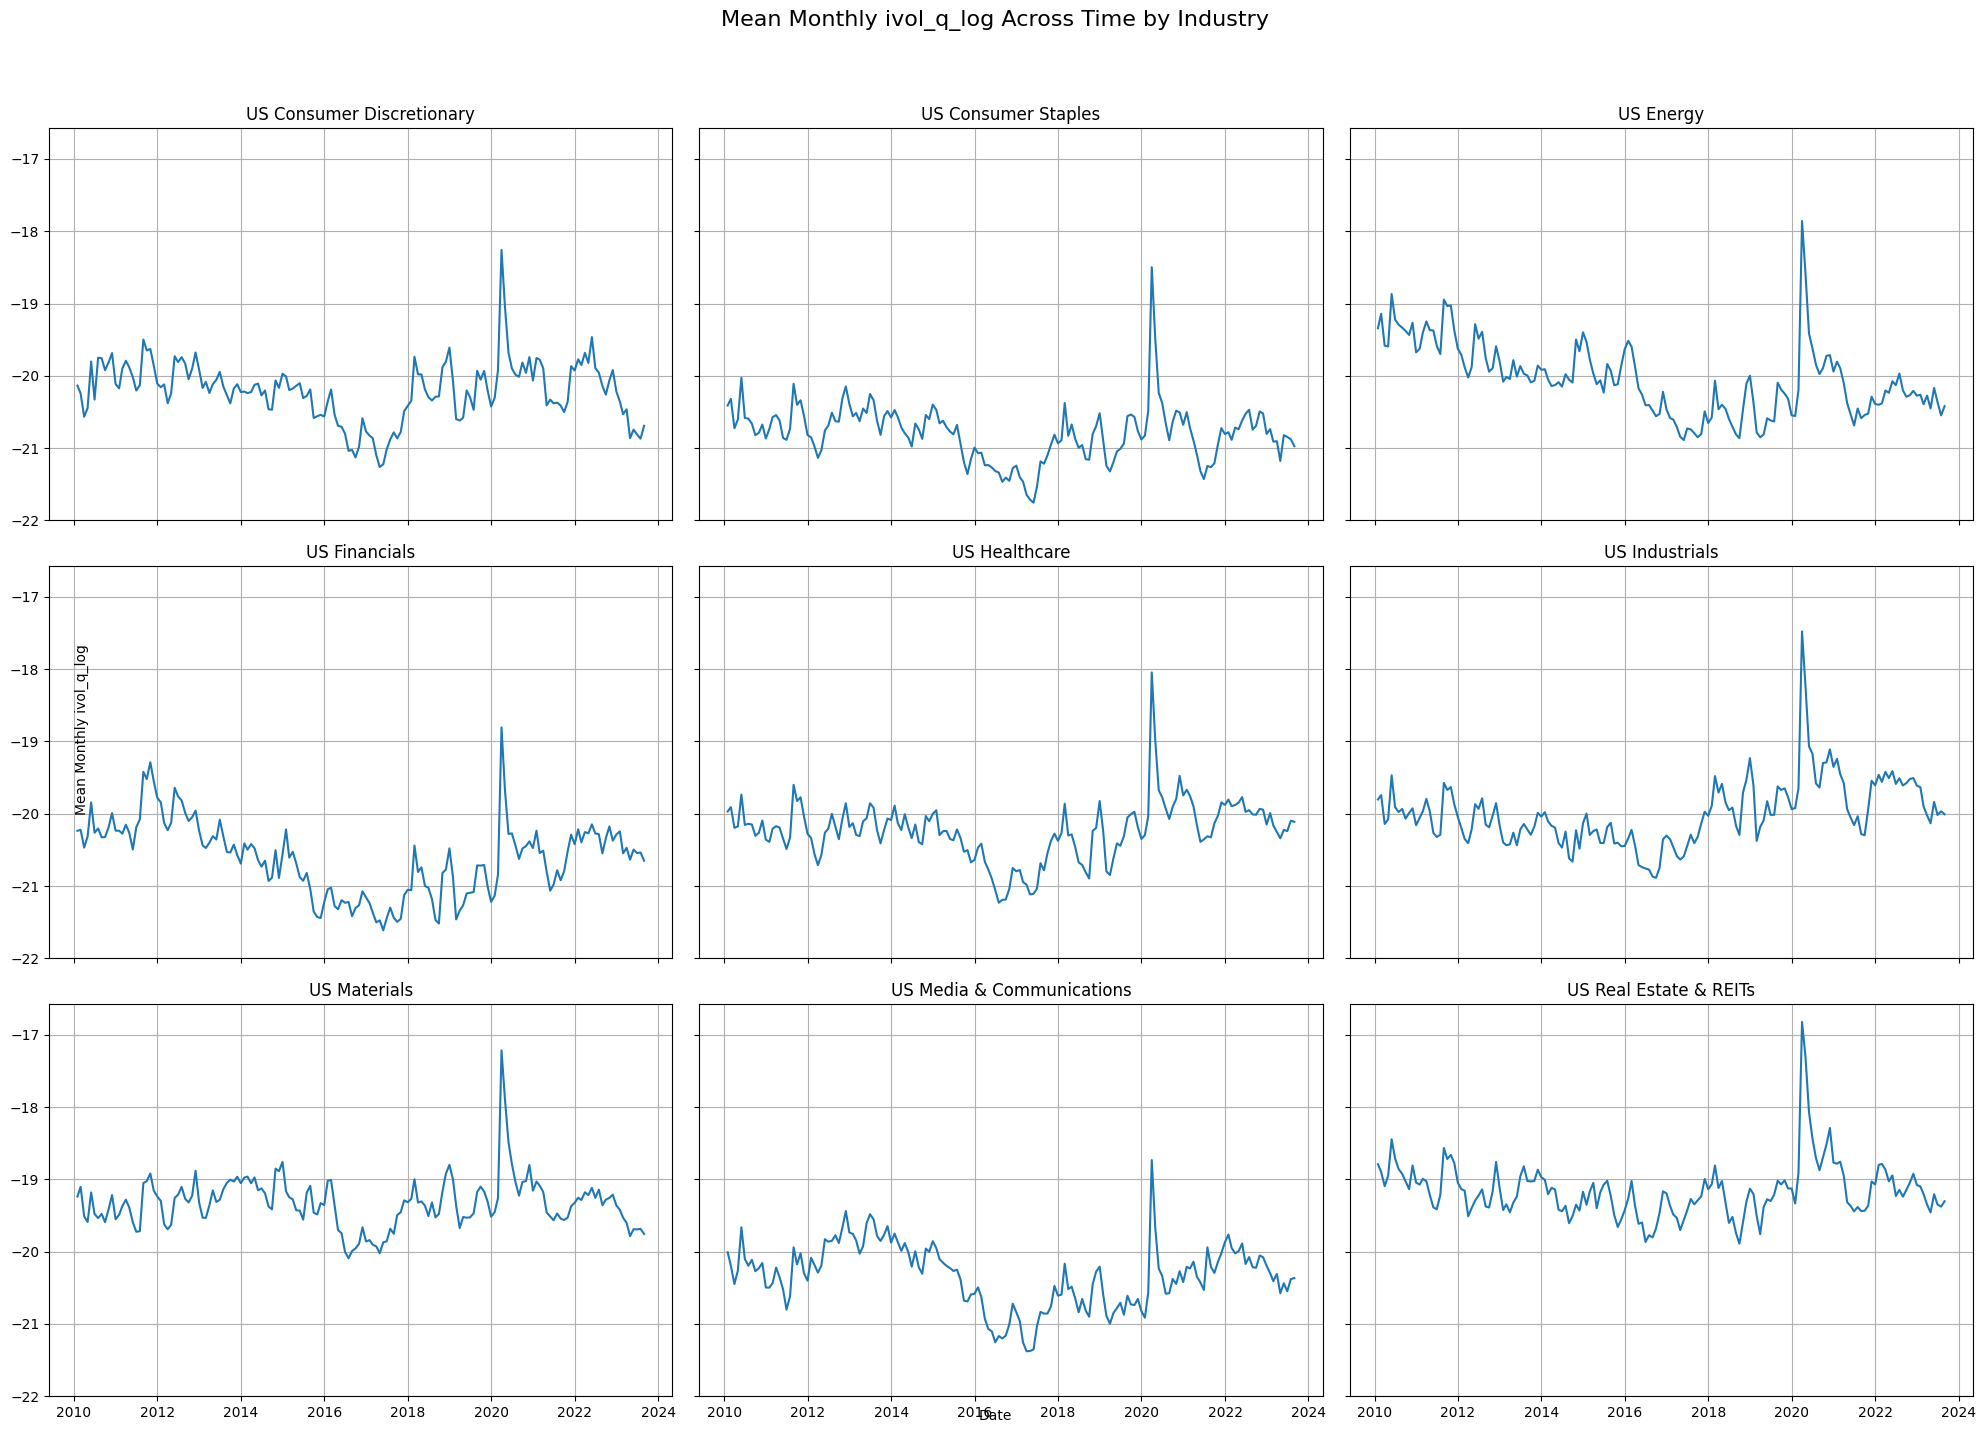

In [211]:
industry_ivol_q_log = vols.groupby(['industry', 'DATE', 'month'])['ivol_q_log'].mean().reset_index()
industry_ivol_q_log_pivot = industry_ivol_q_log.pivot(index='DATE', columns='industry', values='ivol_q_log')
monthly_mean_ivol_q_log = industry_ivol_q_log_pivot.resample('M').mean()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15), sharex=True, sharey=True)
axes = axes.flatten()

for i, industry in enumerate(monthly_mean_ivol_q_log.columns[:9]):
    axes[i].plot(monthly_mean_ivol_q_log.index, monthly_mean_ivol_q_log[industry], label=industry)
    axes[i].set_title(industry)
    axes[i].grid(True)

fig.text(0.5, 0.04, 'Date', ha='center')
fig.text(0.04, 0.5, 'Mean Monthly ivol_q_log', va='center', rotation='vertical')
fig.suptitle('Mean Monthly ivol_q_log Across Time by Industry', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


- Certain trends like volatility spikes in 2020 due to COVID are observed across all industries. Some industries like Energy and Real estate maintain a higher vol level as compared to media of consumerables



### Calculating $z_2(\ell)$ for $l={1,2,3 \dots 10}$

In [212]:
def moments(df):
    final_dfs = []
    for lag in range(1, 11):
        tmp = df.groupby(['SYM_ROOT', 'industry', 'year', 'month'])['ivol_q_log']\
            .apply(lambda x: (((x - x.shift(lag))**2).sum() / (x.count() - lag)) ).to_frame(f'lag{lag}_mom')
        final_dfs.append(tmp)
    final_df = pd.concat(final_dfs, axis=1)
    return final_df

In [213]:
final = moments(vols)
final.replace([np.inf, -np.inf], np.nan, inplace=True)
final.dropna(inplace=True)
final.head()


lag1_mom   lag2_mom   lag3_mom   lag4_mom  \
SYM_ROOT industry      year month                                               
AAPL     US Technology 2010 1       0.124012   0.171654   0.142317   0.237785   
                            2       0.067225   0.125021   0.179476   0.244710   
                            3       0.177133   0.242053   0.198273   0.162382   
                            4       0.193675   0.272393   0.313740   0.403786   
                            5      15.892976  25.353659  28.885627  29.800796   

                                    lag5_mom   lag6_mom   lag7_mom   lag8_mom  \
SYM_ROOT industry      year month                                               
AAPL     US Technology 2010 1       0.328099   0.400266   0.529878   0.649329   
                            2       0.314723   0.386906   0.497555   0.595319   
                            3       0.257832   0.319519   0.226560   0.246481   
                            4       0.411080   0.405068   0.399077   0.554030   
                            5      15.897322  16.978581  17.957950  19.168883   

                                    lag9_mom  lag10_mom  
SYM_ROOT industry      year month                        
AAPL     US Technology 2010 1       0.675741   0.825034  
                            2       0.644346   0.776623  
                            3       0.261480   0.348716  
                            4       0.698151   0.725557  
                            5      20.298034  22.192187

### Regressing $\log z_2(\ell) = \beta_1 + \beta_2 \log \ell + \epsilon$ to find H

In [214]:
betas = pd.DataFrame(columns=['Betas'], index=final.index)
for idx,_ in final.iterrows():
    y = final.loc[idx].values
    X = np.log(range(1, 11)).reshape(-1,1)
    X = sm.add_constant(X) # remove to ensure positive H-vals
    mod = sm.OLS(y, X).fit()
    betas.loc[idx, 'Betas'] = mod.params[0]
betas.reset_index(inplace=True)
betas['Realized_H'] = betas['Betas'] * 0.5
betas.head()

SYM_ROOT       industry  year  month      Betas Realized_H
0     AAPL  US Technology  2010      1  -0.043603  -0.021801
1     AAPL  US Technology  2010      2  -0.068176  -0.034088
2     AAPL  US Technology  2010      3   0.168163   0.084081
3     AAPL  US Technology  2010      4   0.124253   0.062127
4     AAPL  US Technology  2010      5  22.406145  11.203072

In [215]:
# SAVING REALIZED-H FILE FOR FURTHER USE

# betas2=betas.copy()
# betas2.rename(columns={'SYM_ROOT':'ticker'}, inplace=True)
# betas2.drop(['industry','Betas'],axis=1,inplace=True)
# ticker_prices = pd.read_csv('monthly_ticker_prices.csv')
# ticker_prices=ticker_prices[['date', 'TICKER', 'PRC']]
# ticker_prices.rename(columns={'TICKER':'ticker', 'PRC':'price'}, inplace=True)
# ticker_prices['date']=pd.to_datetime(ticker_prices['date'])
# ticker_prices['year']=ticker_prices['date'].dt.year
# ticker_prices['month']=ticker_prices['date'].dt.month
# ticker_prices = ticker_prices.merge(betas2, left_on=['ticker', 'year', 'month'], right_on=['ticker', 'year', 'month'], how='inner')
# ticker_prices.drop(['year', 'month'], axis=1, inplace=True)
# ticker_prices.to_csv('Realized_H/Realized_H_Data2.csv', index=False)

## Implied Roughness

### Theory of implementation

The ATM skew exhibits a power law decay at short maturities, with an exponent determined by H. 

$\sigma_{BS}(k, \tau)$ for the Black-Scholes implied volatility of an option with time-to-maturity $\tau$ and log-moneyness $k = \log(K/S)$, where $K$ is the option's strike price and $S$ is the current level of the underlying. The ATM skew at maturity $\tau$ is given by

$$\phi(\tau) = \left| \frac{\partial \sigma_{BS}(k, \tau)}{\partial k} \right|_{k=0}$$



$$\phi(\tau) \approx \text{constant} \times \tau^{H-1/2}, \quad \text{as } \tau \downarrow 0.$$

In other words, the ATM skew exhibits a power law decay at short maturities, with an exponent determined by $H$.


### Methodology

To estimate the parameter $H$ from market data:

1. For each day and each stock, use filtered option data
2. Fit a cubic spline to model implied volatility as a function of log(K/S)
3. Calculate the derivative of the spline at log(K/S) = 0 to obtain the ATM skew ($\phi$)
4. Run a linear regression in log-log space:
  $$\log(\phi) = c + (H - \frac{1}{2})\log(\tau) + \varepsilon$$
5. Add $\frac{1}{2}$ to the estimated slope coefficient to determine the implied Hurst parameter $H$

This approach allows for robust estimation of the roughness parameter $H$ across different assets and time periods.


### Data import and cleaning

In [216]:
# options_data_1_6 = pd.read_csv("options.csv")
# options_data_1_6['date'] = pd.to_datetime(options_data_1_6['date'])


In [217]:
industries = pd.read_csv('./industry.csv')
industries['industry'] = industries.industry.str.replace('CRSP ', '', regex=True)
industries['industry'] = industries.industry.str.replace(' Index', '', regex=True)
industries['top_tickers'] = industries['top_tickers'].str.split()
industries = industries.explode('top_tickers').reset_index(drop=True)
industries.head()

industry top_tickers
0  US Consumer Discretionary        AMZN
1  US Consumer Discretionary        TSLA
2  US Consumer Discretionary          HD
3  US Consumer Discretionary         WMT
4  US Consumer Discretionary         MCD

In [218]:
# options_data_1_6['exdate'] = pd.to_datetime(options_data_1_6['exdate'])
# options_data_1_6['days']= (options_data_1_6['exdate'] - options_data_1_6['date']).dt.days

In [219]:
# options_data = options_data_1_6.copy()

prices_eod_primary = pd.read_csv("daily_ticker_prices.csv")
prices_eod_primary['date'] = pd.to_datetime(prices_eod_primary['date'])

prices_eod_primary.rename(
    columns={'TICKER': 'ticker', 'PRC': 'close'}, inplace=True
)

### Filtering Options Data

We apply some filtering rules when computing implied roughness to avoid using questionable data from illiquid options. We require the following features:
- Underlying stock price for that day > $5;
- Implied volatility of the option ≥ 3% and ≤ 200%;
- The option’s open interest > 0;
- The option’s volume can be 0 but has to be non-missing;
- The option has time to maturity τ ≥ 5 and τ ≤ 365 calendar days
- Underlying is publicly traded throughout the timeframe (2010-2023)


In [220]:
# options_data.rename(columns={'strike_price':'impl_strike'}, inplace=True)
# options_data['impl_strike'] = options_data['impl_strike']/1000
# options_data = options_data[options_data['impl_volatility'].between(0.03, 2)]
# options_data = options_data[options_data['days'].between(5, 365)]
# options_data = options_data[~options_data['ticker'].isin(['A', 'B', 'BRK'])]
# options_data = options_data[options_data['open_interest']>0]
# options_data = options_data[~options_data['volume'].isna()]
# tickers = options_data[options_data['date'] <= '2011-01-01']['ticker'].unique()
# options_data = options_data[options_data['ticker'].isin(tickers)]
# options_data.rename(columns={'exdate':'expiration'}, inplace=True)

### Skew Power Law

The ATM skew exhibits a power law decay at short maturities, with an exponent determined by H. 

$\sigma_{BS}(k, \tau)$ for the Black-Scholes implied volatility of an option with time-to-maturity $\tau$ and log-moneyness $k = \log(K/S)$, where $K$ is the option's strike price and $S$ is the current level of the underlying. The ATM skew at maturity $\tau$ is given by

$$\phi(\tau) = \left| \frac{\partial \sigma_{BS}(k, \tau)}{\partial k} \right|_{k=0}$$



$$\phi(\tau) \approx \text{constant} \times \tau^{H-1/2}, \quad \text{as } \tau \downarrow 0.$$

In other words, the ATM skew exhibits a power law decay at short maturities, with an exponent determined by $H$.

In [221]:
# prev_ticker = None
# a = None
# def compute_skew_slope(group):
#     global prev_ticker
#     global a
#     current_ticker = group['ticker'].iloc[0]
#     if prev_ticker != current_ticker:
#         if(a is not None):
#             print(time.time() - a)
#         print(f"Processing {current_ticker}")
#         prev_ticker = current_ticker
#         a = time.time()
    
#     calls = group[group['cp_flag'] == 'C'].dropna(subset=['impl_volatility', 'impl_strike'])
#     puts  = group[group['cp_flag'] == 'P'].dropna(subset=['impl_volatility', 'impl_strike'])
    
#     # Precompute log(K/S) for calls & puts
#     # S = underlying close for that day
#     S = group['close'].iloc[0]  # same for entire group
#     calls = calls.copy()
#     puts  = puts.copy()
#     calls['log_k_s'] = np.log(calls['impl_strike'].astype(float) / S)
#     puts['log_k_s']  = np.log(puts['impl_strike'].astype(float) / S)
    
#     # Sort by log_k_s
#     calls = calls.drop_duplicates(subset='log_k_s').sort_values('log_k_s')
#     puts  = puts.drop_duplicates(subset='log_k_s').sort_values('log_k_s')
    
#     # Must have strictly increasing log(K/S)
#     if calls['log_k_s'].is_monotonic_increasing is False or puts['log_k_s'].is_monotonic_increasing is False:
#         return pd.Series({'skew_slope_c' : np.nan, 'skew_slope_p' : np.nan})
    
#     # Prepare arrays
#     x_c = calls['log_k_s'].values
#     y_c = calls['impl_volatility'].values
#     x_p = puts['log_k_s'].values
#     y_p = puts['impl_volatility'].values
    
#     # If there's not enough unique x-values to fit a spline, return np.nan
#     if len(x_c) < 4 and len(x_p) < 4:
#         return pd.Series({'skew_slope_c' : np.nan, 'skew_slope_p' : np.nan})
    
#     # Fit cubic splines
#     if(len(x_c) < 4):
#         try:
#             spline_c = np.nan
#             spline_p = CubicSpline(x_p, y_p)
#             slope_atm_c = np.nan
#             slope_atm_p = spline_p.derivative()(0.0)
#         except:
#             return pd.Series({'skew_slope_c' : np.nan, 'skew_slope_p' : np.nan})
#     elif(len(x_p) < 4):
#         try:
#             spline_c = CubicSpline(x_c, y_c)
#             spline_p = np.nan
#             slope_atm_c = spline_c.derivative()(0.0)
#             slope_atm_p = np.nan
#         except:
#             return pd.Series({'skew_slope_c' : np.nan, 'skew_slope_p' : np.nan})
#     else:
#         try:
#             spline_c = CubicSpline(x_c, y_c)
#             spline_p = CubicSpline(x_p, y_p)
#             slope_atm_c = spline_c.derivative()(0.0)
#             slope_atm_p = spline_p.derivative()(0.0)
#         except:
#             return pd.Series({'skew_slope_c' : np.nan, 'skew_slope_p' : np.nan})
    
#     # # Define a grid around ATM (log(K/S)=0)
#     # grid = np.linspace(-0.2, 0.2, 100)
#     # iv_mid = (spline_c(grid) + spline_p(grid)) / 2.0
    
#     # # Fit cubic spline to the mid curve
#     # spline_mid = CubicSpline(grid, iv_mid)

#     return pd.Series({'skew_slope_c' : slope_atm_c, 'skew_slope_p' : slope_atm_p})


# # Group by (ticker, date, expiration) and compute slopes
# group_cols = ['Ticker', 'Date', 'expiration']
# slope_df = (
#     merged
#     .groupby(group_cols)
#     .apply(compute_skew_slope)
# )

# # slope_df.name = 'skew_slope'
# slope_df = slope_df.reset_index()

In [222]:
# slope_df.to_csv('slope_df_options.csv', index=False)

In [223]:
# def power_law(tau, C, H):
#     """ phi(tau) = C * tau^(H - 0.5) """
#     return C * tau**(H - 0.5)

# def get_time_to_expiry(date_series, expiration_series):
#     """Return time-to-expiry in years."""
#     return (expiration_series - date_series).dt.days / 365.0

In [224]:
# # Add 'tau' = time to expiry
# slope_df['tau'] = get_time_to_expiry(
#     slope_df['date'],
#     slope_df['expiration']
# )

# # We'll take absolute value of slope for the fit
# slope_df['abs_slope_c'] = slope_df['skew_slope_c'].abs()
# slope_df['abs_slope_p'] = slope_df['skew_slope_p'].abs()

In [225]:
# def compute_H_for_day(group):

#     group_c = group[['tau', 'abs_slope_c']].dropna()
#     group_p = group[['tau', 'abs_slope_p']].dropna()
#     tau_vals_c = np.log(group_c['tau'].astype('float64')).values
#     tau_vals_p = np.log(group_p['tau'].astype('float64')).values
#     phi_vals_c = np.log(group_c['abs_slope_c'].astype('float64'))
#     phi_vals_p = np.log(group_p['abs_slope_p'].astype('float64'))
    
#     # # Initial guess
#     # p0 = (1.0, 0.5)  # (C, H)
    
#     # Fit
#     # try:
#     if(phi_vals_c.shape[0] < 3):
#         H_opt_c = np.nan
#     else:
#         X_c = sm.add_constant(tau_vals_c)
#         model = sm.OLS(phi_vals_c.values, X_c)
#         results = model.fit()
#         _, H_opt_c = results.params

#     if(phi_vals_p.shape[0] < 3):
#         H_opt_p = np.nan
#     else:
#         X_p = sm.add_constant(tau_vals_p)
#         model = sm.OLS(phi_vals_p.values, X_p)
#         results = model.fit()
#         _, H_opt_p = results.params
#     return pd.Series({'H_value_c' : H_opt_c+0.5, 'H_value_p' : H_opt_p+0.5})
#     # popt, _ = curve_fit(power_law, tau_vals, phi_vals, p0=p0, maxfev=10000)
#     # _, H_opt = popt
#     # return H_opt
#     # except:
#     #     return pd.Series({'H_value_c' : np.nan, 'H_value_p' : np.nan})

# H_df = (
#     slope_df
#     .groupby(['ticker','date'])
#     .apply(compute_H_for_day)
# ).reset_index()

In [226]:
# final_df = pd.merge(
#     H_df,
#     prices_eod_primary[['ticker','date','close']],
#     on=['ticker','date'],
#     how='left'
# )

# final_df['year'] = final_df['date'].dt.year
# final_df['month'] = final_df['date'].dt.month
# # final_df = final_df.groupby(['ticker', 'year', 'month']).mean().reset_index()
# final_df.to_csv("H_values_output_options.csv", index=False)

In [227]:
# merged=pd.read_csv('Implied_H/H_values_output_options.csv')
# merged.rename(columns={'ticker':'Ticker','date':'Date','close':'Price'}, inplace=True)
# merged['Date'] = pd.to_datetime(merged['Date']) 
# merged['H_value'] = merged.apply(lambda row: row['H_value_c'] if pd.isna(row['H_value_p']) else (row['H_value_p'] if pd.isna(row['H_value_c']) else (row['H_value_c'] + row['H_value_p'])/2), axis=1)
# merged=merged.sort_values(['Ticker','Date'])
# merged.drop(['H_value_c','H_value_p', 'year', 'month'],axis=1,inplace=True)
# merged.to_csv('Implied_H/H_values_output_options_final.csv',index=False)
# merged = merged[~merged['Date'].dt.weekday.isin([5, 6])]


# # Perform monthly aggregation ignoring weekends
# monthly_implied_h_df = (
#     merged
#     .groupby([
#         'Ticker', 
#         pd.Grouper(key='Date', freq='BM')  # Last business day of the month
#     ])
#     .agg({
#         'Price': 'last',
#         'H_value': 'mean'
#     })
#     .reset_index()
# )

# monthly_implied_h_df.to_csv('Implied_H/H_values_output_options_final_monthly.csv',index=False)

### The above commented lines calculate the Implied H values using daily options data. Since the data volume was large we ran it in a distributed manner and save the final implied H values in a file. Analysis and Trading Strategy below use the saved values directly. 

In [228]:
merged=pd.read_csv('Implied_H/H_values_output_options_final.csv')
merged_monthly = pd.read_csv('Implied_H/H_values_output_options_final_monthly.csv')

## Analysis of Implied H values

### Implied Volatility Graphs

In [23]:
options = pd.read_csv('./options2.csv')
options = options[(options['ticker'] == 'WFC') & (options['date'] == '2022-08-10')]
options['date'] = pd.to_datetime(options['date'])
options['exdate'] = pd.to_datetime(options['exdate'])
options['days']= (options['exdate'] - options['date']).dt.days
options.rename(columns={'strike_price':'impl_strike'}, inplace=True)
options['impl_strike'] = options['impl_strike']/1000
options = options[~options['volume'].isna()]
options.rename(columns={'exdate':'expiration'}, inplace=True)

#### Here we plot the implied Volatility from Options Data for 'WFC' Ticker on 10th August 2012

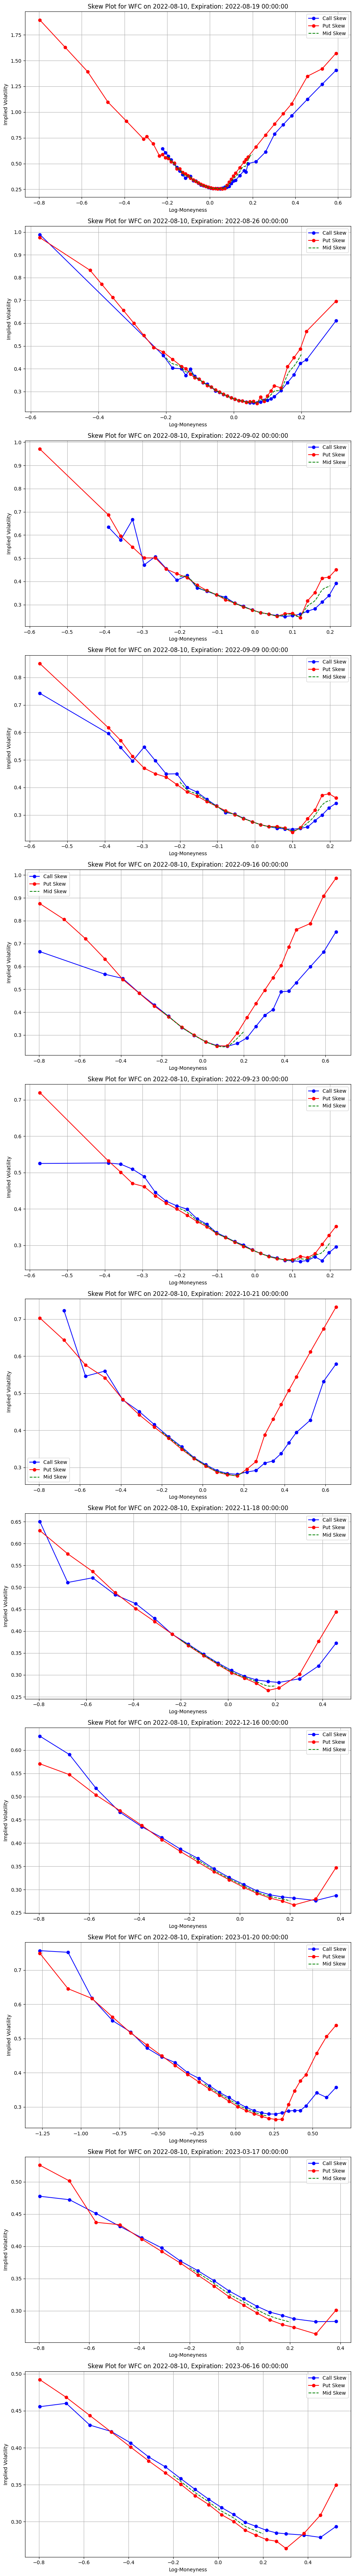

In [24]:
def plot_skew(ticker, date, options_df, stock_price):
    filtered_options = options_df[(options_df['ticker'] == ticker) & (options_df['date'] == date)]
    
    if filtered_options.empty:
        print(f"No options data found for {ticker} on {date}.")
        return
    expirations = filtered_options['expiration'].unique()
    fig, axs = plt.subplots(len(expirations), figsize=(10, 6*len(expirations)))
    
    for i, expiration in enumerate(expirations):
        # Filter options for the current expiration
        options_expiration = filtered_options[filtered_options['expiration'] == expiration]
        
        # Separate calls and puts
        call_options = options_expiration[options_expiration['cp_flag'] == 'C'].dropna(subset=['impl_volatility'])
        put_options = options_expiration[options_expiration['cp_flag'] == 'P'].dropna(subset=['impl_volatility'])
        
        # Compute log-moneyness for calls and puts
        # stock_price = options_expiration['impl_strike'].mean()  # Approximate stock price as mean strike
        call_options['log(K/S)'] = np.log(call_options['impl_strike'].astype(float) / stock_price)
        put_options['log(K/S)'] = np.log(put_options['impl_strike'].astype(float) / stock_price)
        
        # Sort data for proper spline fitting
        call_options = call_options.sort_values(by='log(K/S)')
        put_options = put_options.sort_values(by='log(K/S)')
        
        # Extract values
        log_ks_calls = call_options['log(K/S)'].values
        vols_calls = call_options['impl_volatility'].values
        
        log_ks_puts = put_options['log(K/S)'].values
        vols_puts = put_options['impl_volatility'].values
        
        # Fit cubic splines separately for calls and puts
        spline_calls = CubicSpline(log_ks_calls, vols_calls)
        spline_puts = CubicSpline(log_ks_puts, vols_puts)
        
        # Define a common grid around ATM
        grid = np.linspace(-0.2, 0.2, 100)
        
        # Evaluate both splines on the grid and take their mid implied volatility values
        mid_iv = (spline_calls(grid) + spline_puts(grid)) / 2
        
        # Fit a cubic spline to the mid implied volatility curve
        spline_mid = CubicSpline(grid, mid_iv)
        
        # Plot original data
        axs[i].plot(log_ks_calls, vols_calls, marker='o', linestyle='-', color='b', label="Call Skew")
        axs[i].plot(log_ks_puts, vols_puts, marker='o', linestyle='-', color='r', label="Put Skew")
        
        # Plot fitted mid skew
        axs[i].plot(grid, mid_iv, linestyle="--", color="g", label="Mid Skew")
        
        axs[i].set_xlabel("Log-Moneyness")
        axs[i].set_ylabel("Implied Volatility")
        axs[i].set_title(f"Skew Plot for {ticker} on {date}, Expiration: {expiration}")
        axs[i].legend()
        axs[i].grid(True)
    
    plt.tight_layout()
    plt.show()
    
wells_price = prices_eod_primary[(prices_eod_primary['ticker'] == 'WFC') & (prices_eod_primary['date'] == pd.to_datetime("2022-08-10" ))]
plot_skew('WFC',"2022-08-10", options, wells_price['close'].values[0])


##### These are skew plots for Wells Fargo on 10 August 2022 for various expiries.
 

### Power Law for ATM Skew Graphs

#### Here we show the Power Law for ATM skew for Option for 'WFC' Ticker on 10th August 2022

In [25]:
slope_df = pd.read_csv('slope_df_options2.csv')
slope_df = slope_df[(slope_df['ticker'] == 'WFC') & (slope_df['date'] == '2022-08-10')]
slope_df['abs_slope_c'] = slope_df['skew_slope_c'].abs()
slope_df['abs_slope_p'] = slope_df['skew_slope_p'].abs()
def get_time_to_expiry(date_series, expiration_series):
    """Return time-to-expiry in years."""
    return (expiration_series - date_series).dt.days / 365.0
slope_df['date'] = pd.to_datetime(slope_df['date'])
slope_df['expiration'] = pd.to_datetime(slope_df['expiration'])
slope_df['tau'] = get_time_to_expiry(
    slope_df['date'],
    slope_df['expiration']
)

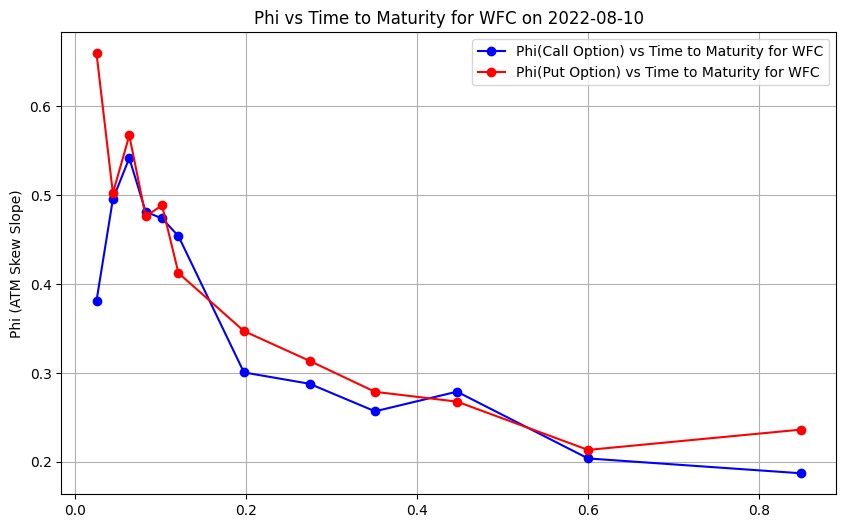

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(slope_df.tau , slope_df.abs_slope_c, marker='o', linestyle='-', color='b', label="Phi(Call Option) vs Time to Maturity for WFC")
plt.plot(slope_df.tau , slope_df.abs_slope_p, marker='o', linestyle='-', color='r', label="Phi(Put Option) vs Time to Maturity for WFC")
plt.ylabel("Phi (ATM Skew Slope)")
plt.title(f"Phi vs Time to Maturity for WFC on 2022-08-10")
plt.legend()
plt.grid(True)
plt.show()

### Industry Wise Analysis

In [229]:
implied_h_values = merged.copy()
merged_data = pd.merge(implied_h_values, industries, left_on='Ticker', right_on='top_tickers', how='inner')
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
industry_monthly_H_implied=merged_data.groupby(['industry', 'Date'])['H_value'].mean().reset_index()
industry_monthly_H_implied=industry_monthly_H_implied.pivot(index='Date', columns='industry',values='H_value')
industry_monthly_H_implied=industry_monthly_H_implied.drop(['US Technology'], axis=1)
industry_monthly_H_implied=industry_monthly_H_implied.astype(float)


### Correlation heatplot

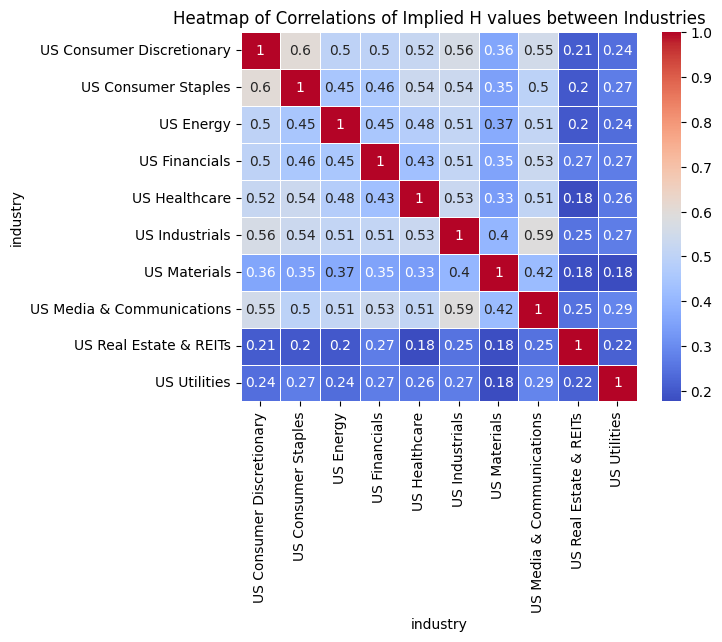

In [230]:
corr = industry_monthly_H_implied.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Correlations of Implied H values between Industries')
plt.show()

- It shows comparatively lesser correlations (once compared to the realized H industry wise correlations).
- Real estate and utilities pairwise have the least implied H correlation with other industries.
- Highest value is 0.6 reached by consumer discretionary and consumer staples, which shows decent amount of correlation but still not too strong 

### Mean annualized implied H-values industry wise to observe industry trends


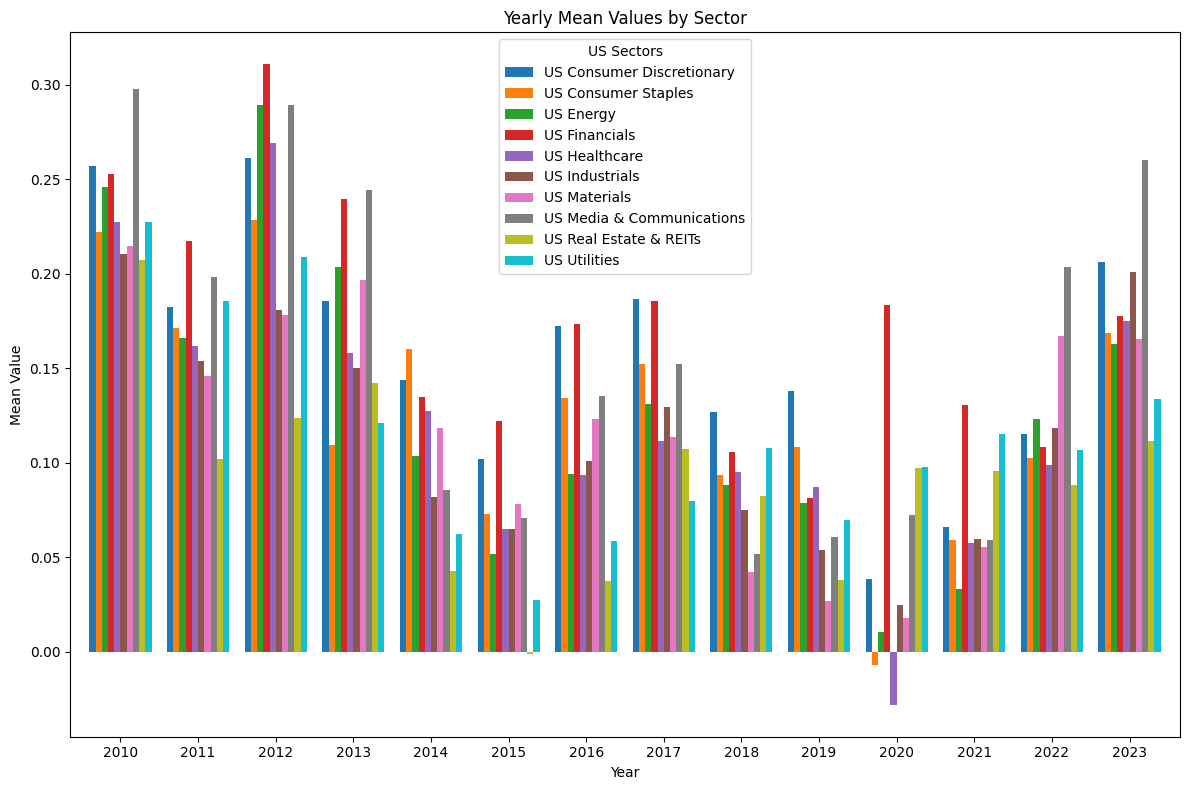

In [231]:
industry_yearly_H = industry_monthly_H_implied.groupby(industry_monthly_H_implied.index.year).mean()
industry_yearly_H.plot(kind='bar', figsize=(12, 8),position=0.5, width=0.8)
plt.title('Yearly Mean Values by Sector')
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.xticks(rotation=0) 
plt.legend(title='US Sectors')
plt.tight_layout()
plt.show()


- Decrease in volatility smoothness observed industry wide near years 2015 and 2019-2021. 
- US FInancials showing relatively higher values of Implied H across the years
- We see estimated values of Implied H reaching a negative mean value in 2020 for the sectors of Healthcare and Consumer Staples, which is partially explained by the turbulent post-covid market conditions.


## Analysis of Realized H values

In [30]:
analysis_industries=['US Consumer Discretionary', 'US Consumer Staples','US Energy', 'US Financials', 'US Healthcare']
industry_monthly_H=betas.groupby(['industry','year','month'])['Realized_H'].mean().reset_index()
industry_monthly_H['month_plot'] = (pd.to_datetime(industry_monthly_H[['year', 'month']].assign(day=1)) + pd.offsets.MonthEnd(0)).dt.to_period('M')
industry_monthly_H=industry_monthly_H.drop(columns=['year','month'])
industry_monthly_H=industry_monthly_H.pivot(index='month_plot', columns='industry',values='Realized_H')
industry_monthly_H=industry_monthly_H.drop(['US Technology'], axis=1)
industry_monthly_H=industry_monthly_H.astype(float)
industry_monthly_H.to_csv('industry_monthly_H.csv')
industry_monthly_H2 = industry_monthly_H[analysis_industries]


In [31]:
volind = vols.copy()
volind['log_ivol_q'] = np.log(volind['ivol_q'])
volind = volind.loc[:, ['log_ivol_q', 'industry', 'DATE']]
volind['DATE'] = pd.to_datetime(volind['DATE'])
volind = volind.groupby(['industry', 'DATE'])['log_ivol_q'].mean().reset_index()
volind = volind.pivot(index='DATE', columns='industry', values='log_ivol_q')
volind_rolling_autocorr = volind.rolling(window=20).apply(lambda x: x.autocorr(lag=1))


### Heatmap of correlations between realized H-values of different industries

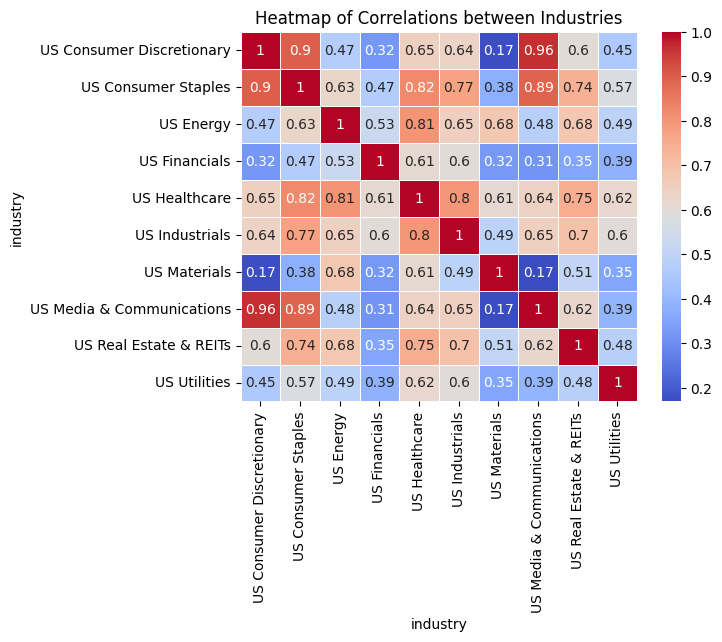

In [32]:
corr = industry_monthly_H.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Correlations between Industries')
plt.show()


#### Observations:

- Except 5 pairs, all other industries see decently correlated monthly H values (>0.6)
- The highest correlations noticed among the pairs of Consumer Staples, Consumer Discretionary and Media&Communications (all pair correlations >= 0.87), indicating that these industries react to shocks in an almost identical manner.
- Lowest correlations noticed amongst industries like Materials and Media, Materials and Consumerables. It shows that the shocks to the prices of these industrial tickers are mostly unrelated and each follow a relatively more independent behaviour.

#### Economic Explanations:

- Strong positive correlations (Values close to 1)
    - US Consumer Discretionary & US Media & Communications (0.95): This strong positive correlation suggests that these two sectors tend to move in the same direction. This could be because consumer spending on discretionary items is often influenced by media and communication trends (e.g., advertising, entertainment). When the economy is doing well, consumers are more likely to spend on both.

    - US Consumer Discretionary & US Consumer Staples (0.88): This high correlation suggests a relationship between consumer cyclical and non-cyclical spending. When the economy is strong, people buy more of both.

- Moderate to Strong Positive Correlations (Values between 0.5 and 0.85)
    - US Healthcare & US Consumer Staples (0.84): These sectors often show a positive correlation as demand is less sensitive to economic cycles. People still need healthcare and basic goods regardless of the economy.

    - US Energy & US Healthcare (0.79): The cost of energy impacts healthcare, and vice versa.

    - US Industrials & US Healthcare (0.82): Industrial production is required for healthcare supplies.

    - US Industrials & US Consumer Staples (0.82): Same explanation as above.

    - US Energy & US Financials (0.71): Energy companies often rely on financing, and the performance of the energy sector can impact financial institutions. Energy sector impacts nearly all other sectors through energy costs.

- Weak Correlations (Values below 0.35)

    - US Materials & US Media & Communications (0.25): It suggests that the performance of the materials sector (which includes companies that discover, develop, and process raw materials) has little relationship with the media and communications sector.

    - US Materials & US Consumer Discretionary (0.3): Another weak correlation, indicating that the materials sector doesn't move closely with consumer discretionary spending.

### Visualization of Daily volatilities, their lagged autocorrelation and realized H-values

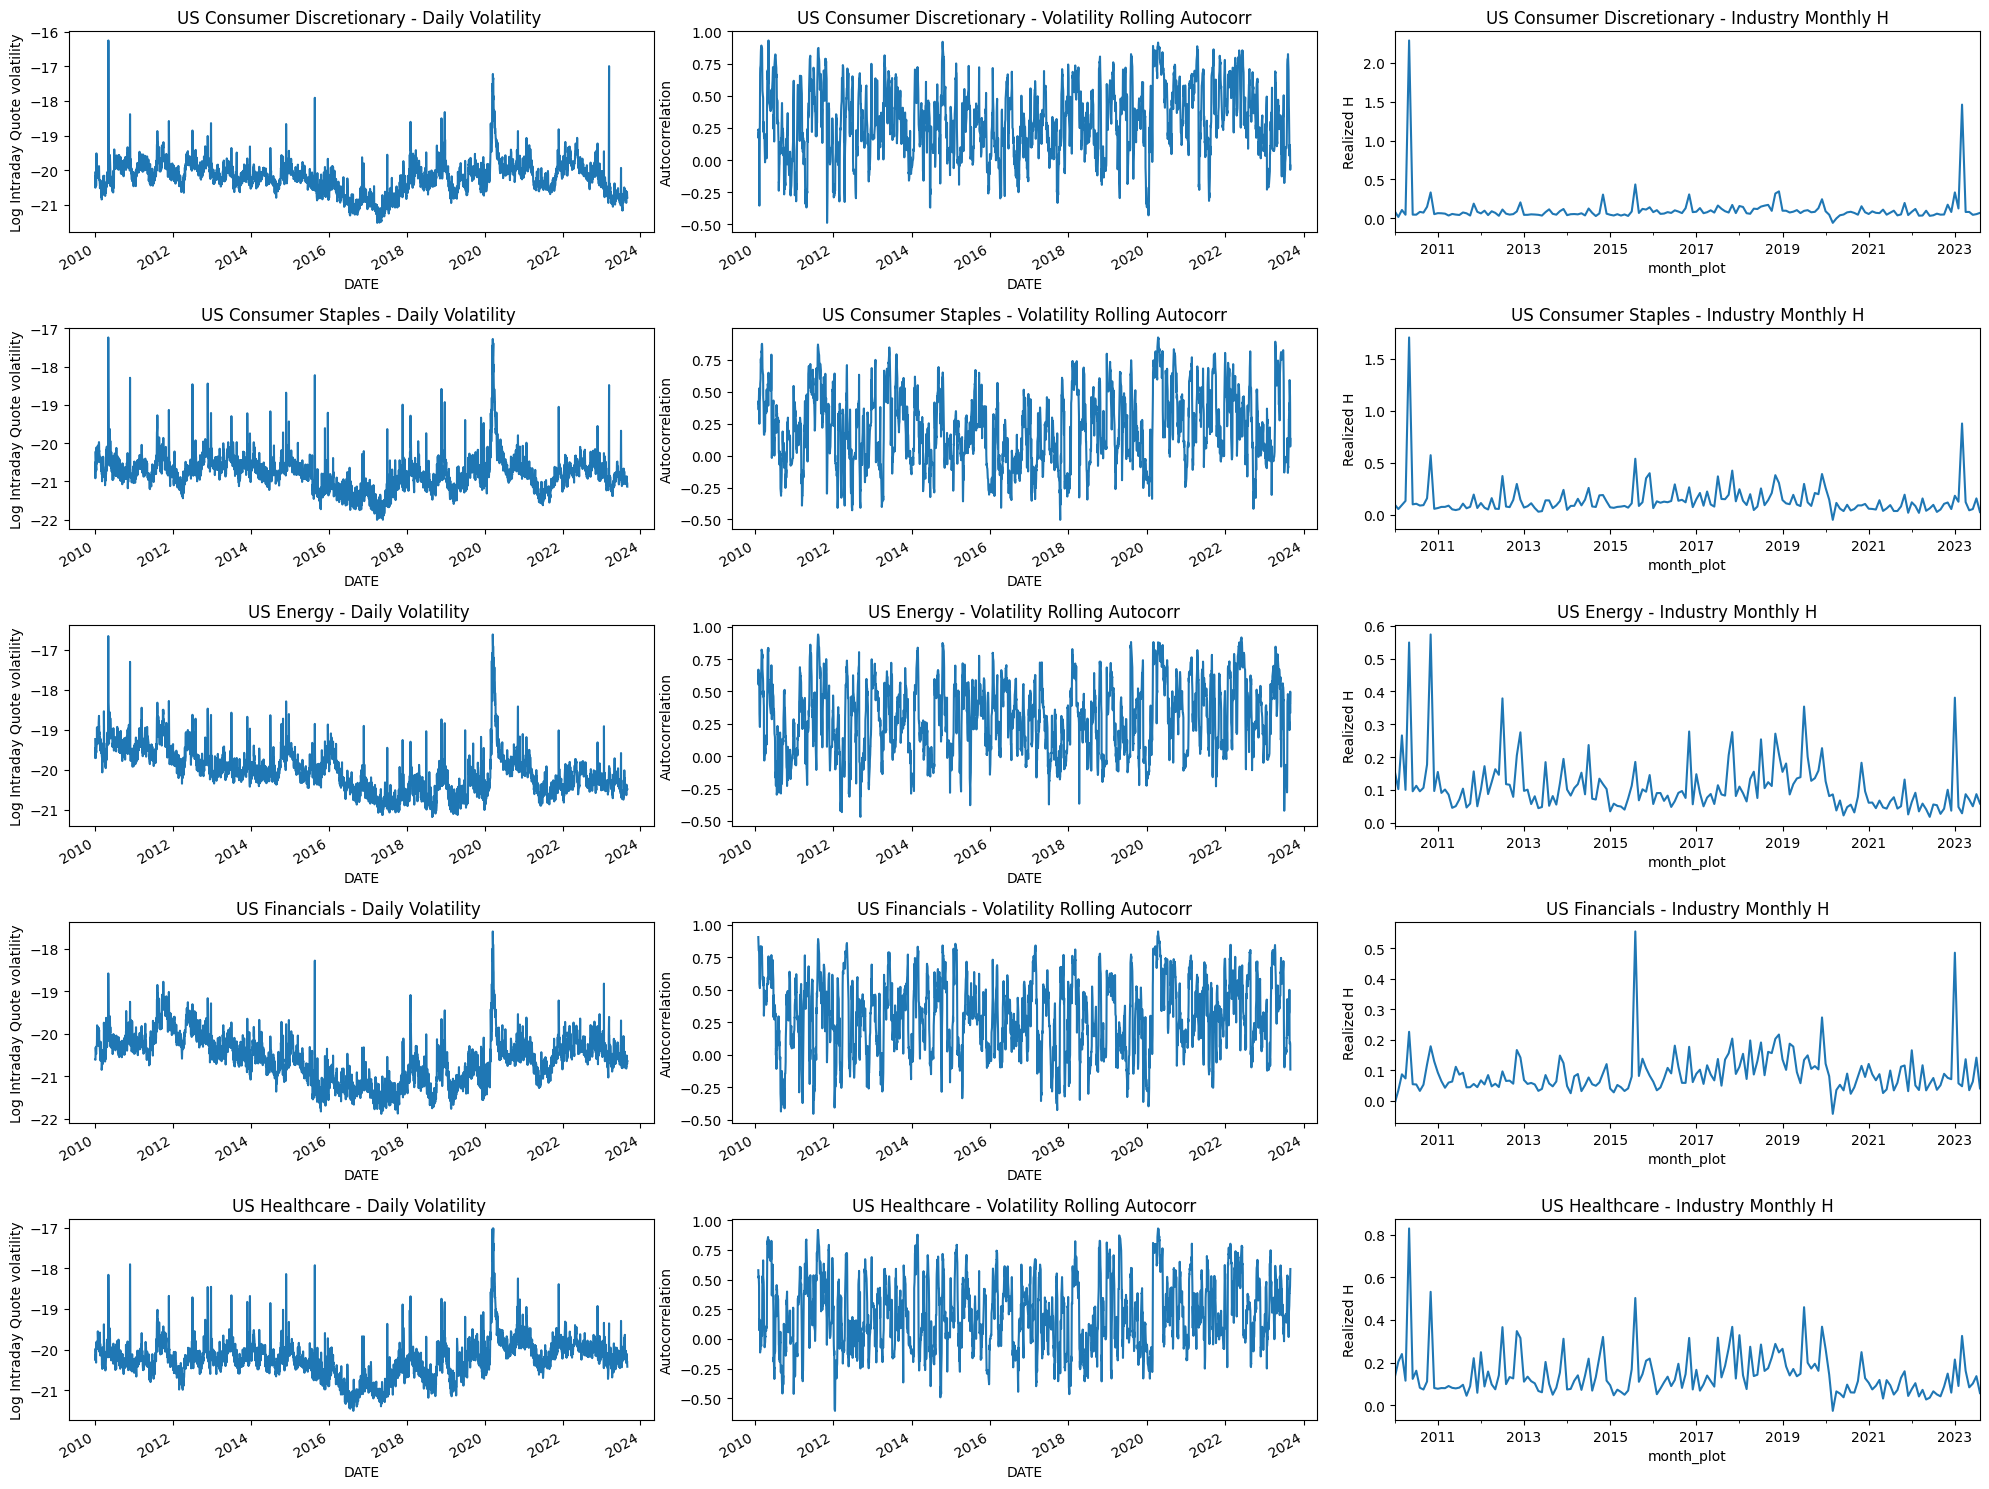

In [33]:
fig, axes = plt.subplots(len(analysis_industries), 3, figsize=(20, 3 * len(analysis_industries)))

for i, industry in enumerate(analysis_industries):
    volind[industry].plot(ax=axes[i, 0], title=f'{industry} - Daily Volatility ')
    axes[i, 0].set_ylabel('Log Intraday Quote volatility')
    
    volind_rolling_autocorr[industry].plot(ax=axes[i, 1], title=f'{industry} - Volatility Rolling Autocorr')
    axes[i, 1].set_ylabel('Autocorrelation')

    industry_monthly_H2[industry].plot(ax=axes[i, 2], title=f'{industry} - Industry Monthly H')
    axes[i, 2].set_ylabel('Realized H')
plt.tight_layout()
plt.show()

#### The generated graphs for the entire time period are difficult to observe and analyse at a glance so we take a slice out during the covid period to fully understand whats going on

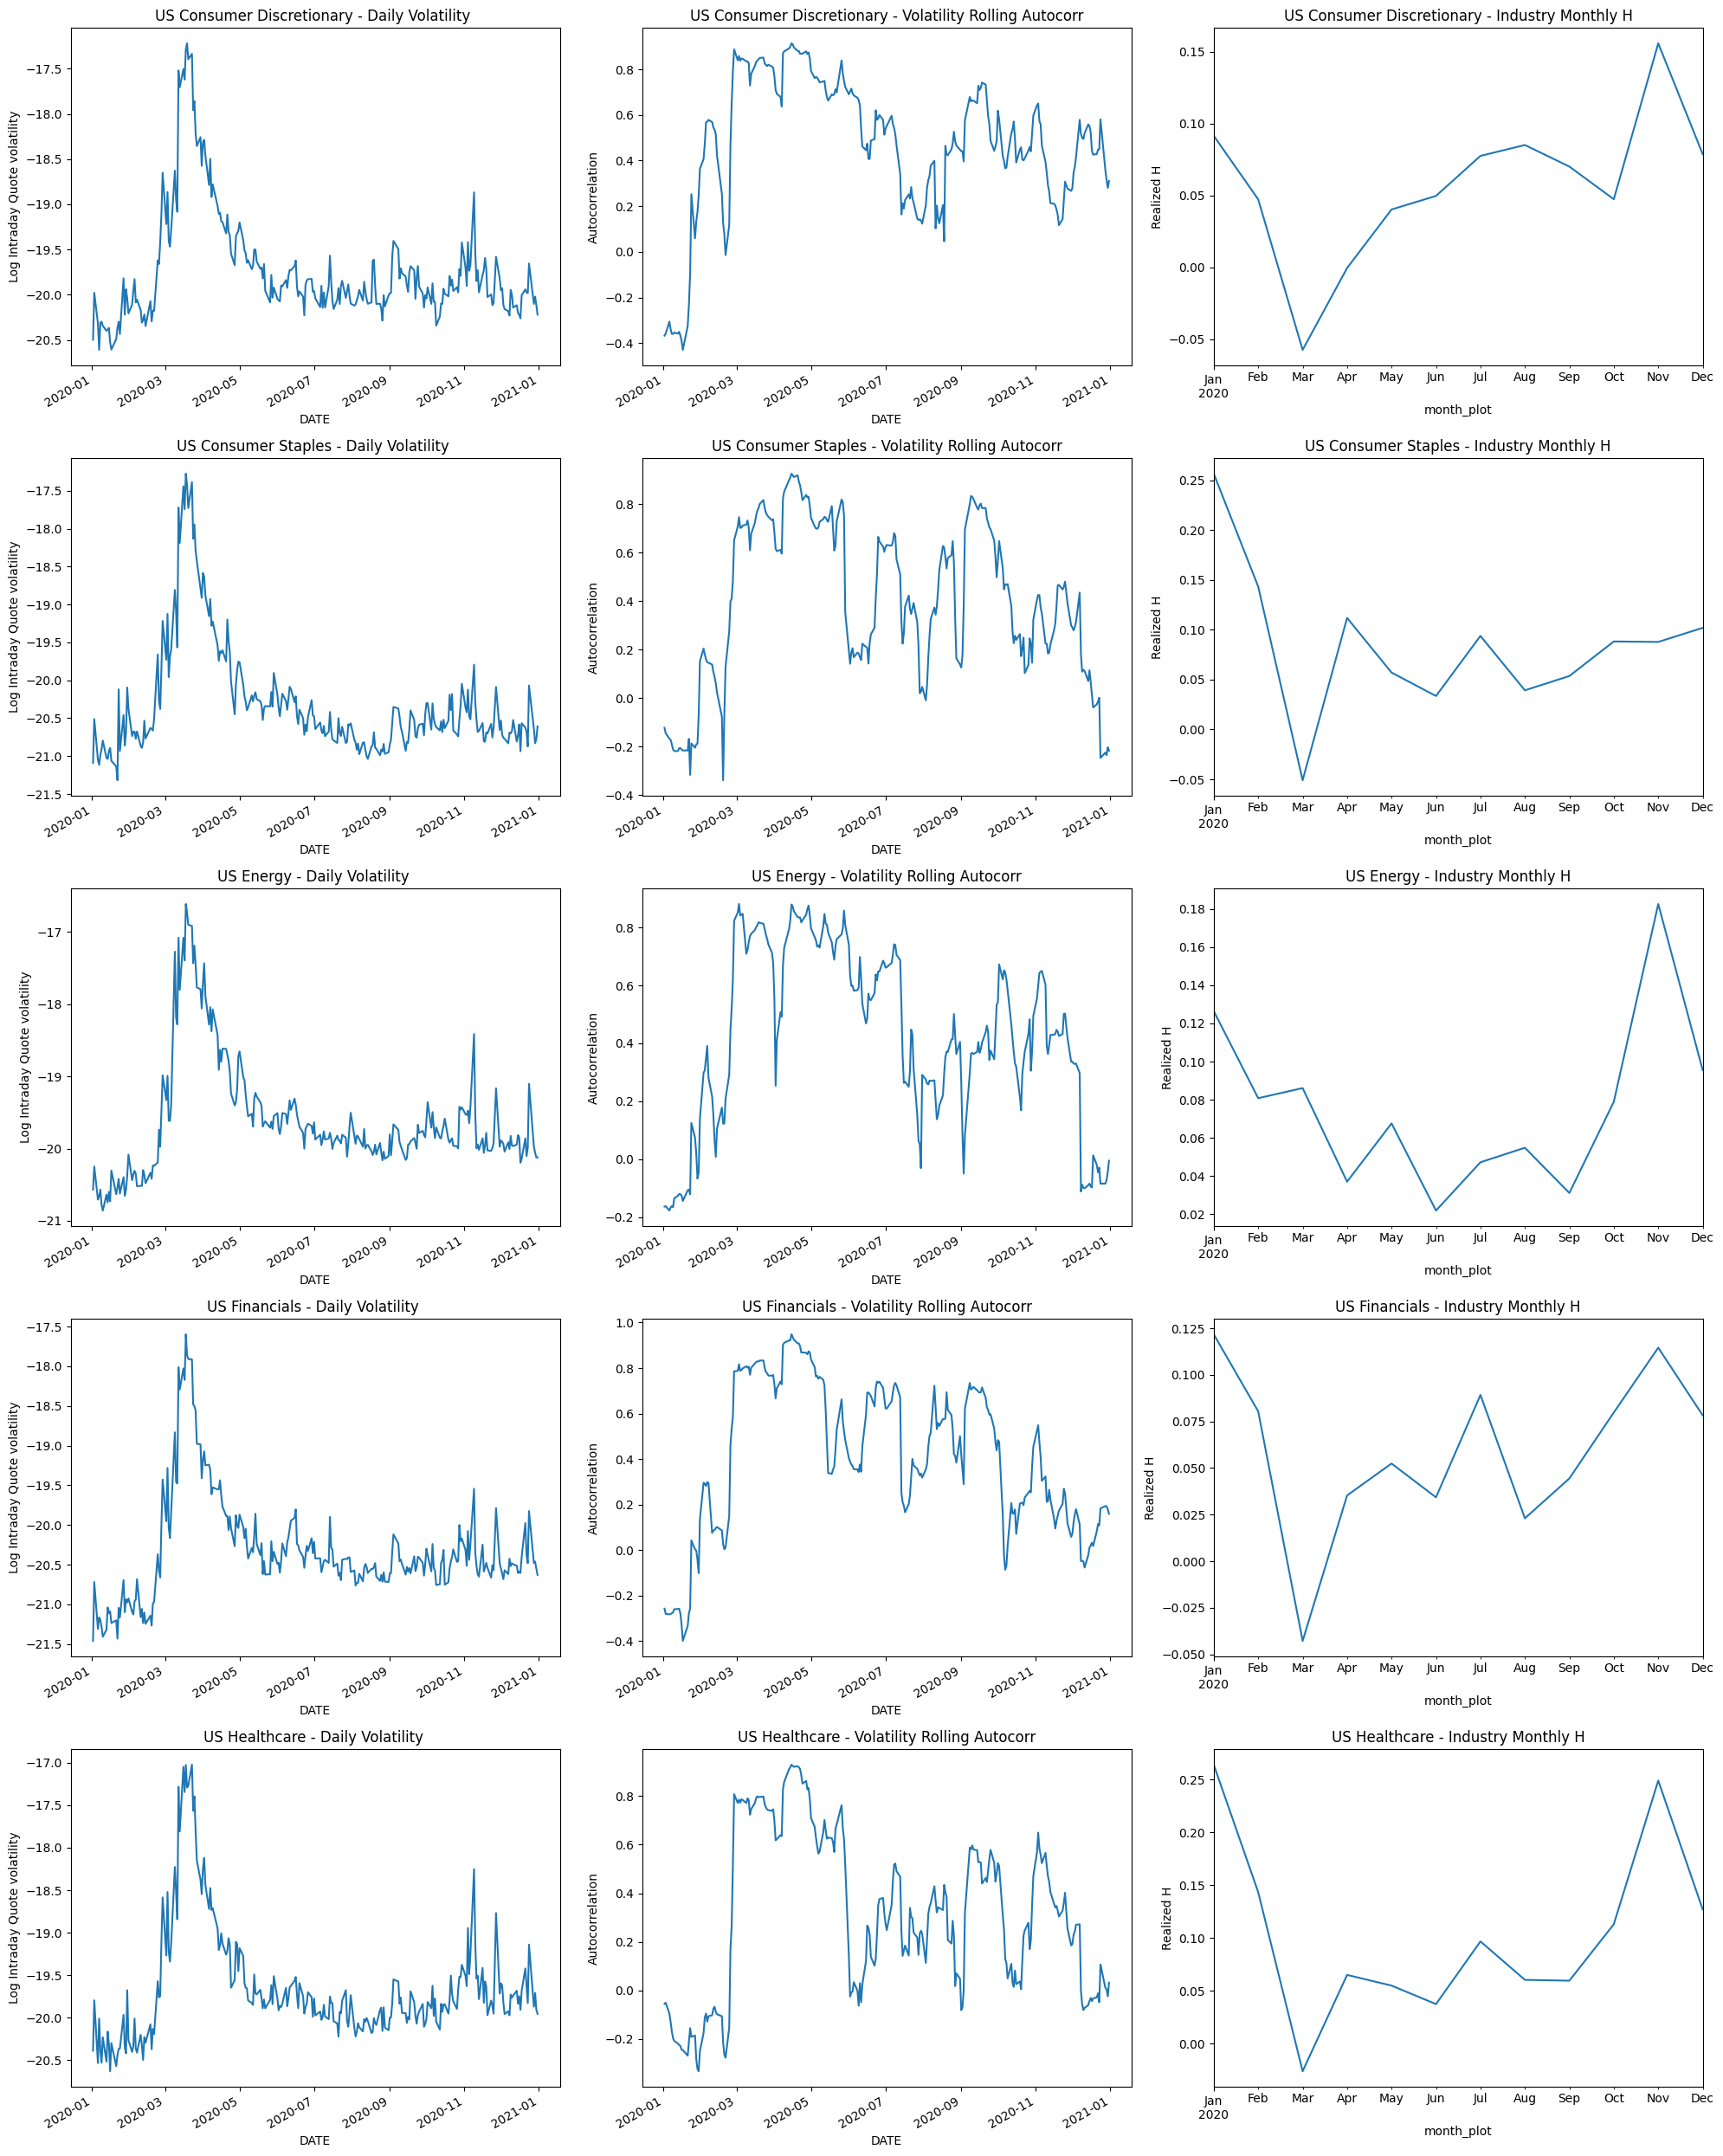

In [34]:
analysis_industries=['US Consumer Discretionary', 'US Consumer Staples', 'US Energy', 'US Financials', 'US Healthcare']
industry_monthly_H2=industry_monthly_H2.loc['2020':'2020']
volind_rolling_autocorr = volind_rolling_autocorr.loc['2020':'2020']
volind = volind.loc['2020':'2020']
fig, axes = plt.subplots(len(analysis_industries), 3, figsize=(20, 5 * len(analysis_industries)))
for i, industry in enumerate(analysis_industries):
    volind[industry].plot(ax=axes[i, 0], title=f'{industry} - Daily Volatility ')
    axes[i, 0].set_ylabel('Log Intraday Quote volatility')
    volind_rolling_autocorr[industry].plot(ax=axes[i, 1], title=f'{industry} - Volatility Rolling Autocorr')
    axes[i, 1].set_ylabel('Autocorrelation')
    industry_monthly_H2[industry].plot(ax=axes[i, 2], title=f'{industry} - Industry Monthly H')
    axes[i, 2].set_ylabel('Realized H')
plt.tight_layout()
plt.show()

#### Observations: 

- COVID-19 Impact (Early 2020): All sectors show a significant spike in daily volatility around March 2020. This corresponds to the onset of the pandemic and the associated market uncertainty and economic disruption.

- Most importantly volatility path gets observably rougher during the turbulent period as compared to other times, we see a dip in the H-values too suggesting rougher movement of volatility asserting our theory of volatility model being modelled by fBM

- We plot the rolling ACF function for the volatility to understand the volatility clustering occurring. Around the covid time the ACF function consistently stays high indicating a high level of volatility clustering.

- Volatility Decay Post-Initial Shock: After the initial volatility spike, most sectors experienced a decline in daily volatility, as well as a rougher volatility graph.

### Mean annualized H-values industry wise to observe industry trends


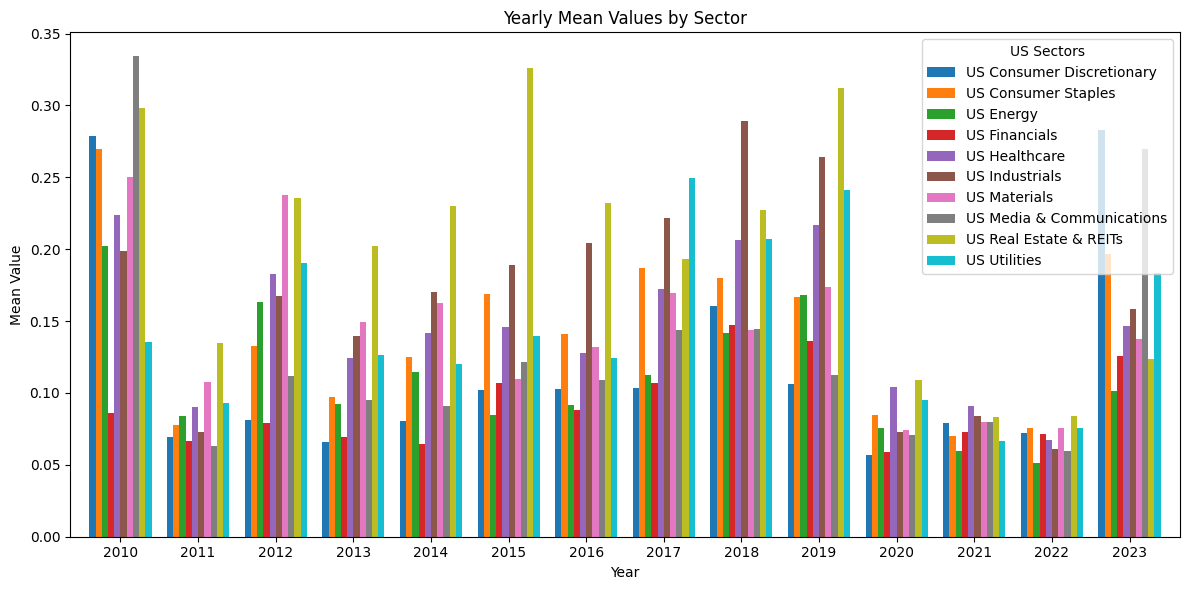

In [35]:
industry_yearly_H = industry_monthly_H.groupby(industry_monthly_H.index.year).mean()
industry_yearly_H.plot(kind='bar', figsize=(12, 6),position=0.5, width=0.8)
plt.title('Yearly Mean Values by Sector')
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.xticks(rotation=0)
plt.legend(title='US Sectors')
plt.tight_layout()
plt.show()


#### Observations:

- Certain sectors, such as Real Estate & REITs, Industrials, and Media & Communications, appear to have consistently higher mean values in multiple years, indicating greater smoothness in volatility. 
- There are notable peaks in specific years for certain sectors. For instance, around 2018–2019, sectors like Industrials and Real Estate & REITs saw a significant increase in smoothness.
- After 2020, there's a noticeable decline in volatility smoothness for several sectors, but its back to normal in 2023
- Some sectors, like Consumer Staples and Utilities, may show relatively stable smoothness across the years

## Descriptive Analysis

### Industry mean and std of H-values across the considered time horizon

In [233]:
implied_H = pd.read_csv('Implied_H/H_values_output_options_final.csv')
implied_H = implied_H.merge(industries, left_on='Ticker', right_on='top_tickers', how='inner').drop(['top_tickers'], axis=1)
implied_H

Ticker        Date      Price   H_value       industry
0        AAPL  2010-01-04  214.00999  0.306627  US Technology
1        AAPL  2010-01-05  214.38000  0.415181  US Technology
2        AAPL  2010-01-06  210.97000  0.278651  US Technology
3        AAPL  2010-01-07  210.58000  0.513268  US Technology
4        AAPL  2010-01-08  211.98000  0.519298  US Technology
...       ...         ...        ...       ...            ...
307334    XOM  2023-08-25  108.25000  0.148601      US Energy
307335    XOM  2023-08-28  109.16000  0.024978      US Energy
307336    XOM  2023-08-29  109.81000  0.104445      US Energy
307337    XOM  2023-08-30  110.88000  0.067330      US Energy
307338    XOM  2023-08-31  111.19000  0.130304      US Energy

[307339 rows x 5 columns]

#### Implied Universe - The subset of the total universe which has options data in the timeframe considered

In [240]:
implied_universe=['ABT','AMZN', 'AXP', 'BAC', 'JPM', 'LNG', 'CVX', 'KO', 'CL',
       'COST', 'EOG', 'XOM', 'GS', 'HD', 'JNJ', 'KMB', 'LLY', 'LOW',
       'MCD', 'MRK', 'MS', 'OKE', 'PEP', 'MO', 'COP', 'PG', 'SLB', 'SBUX',
       'TJX', 'TMO', 'UNH', 'WMT', 'WFC', 'WMB', 'MA', 'PM', 'V', 'TSLA',
       'MDLZ', 'SPGI', 'BKNG', 'PLD', 'AMD', 'APD', 'AEP', 'AMT', 'AAPL',
       'ADP', 'BA', 'CAT', 'CSCO', 'CMCSA', 'CEG', 'CCI', 'DIS', 'D',
       'DUK', 'ETN', 'ECL', 'EQIX', 'NEE', 'FCX', 'GE', 'HON', 'IBM',
       'LMT', 'MLM', 'MSFT', 'NEM', 'NVDA', 'ORCL', 'PCG', 'PEG', 'PSA',
       'O', 'T', 'SRE', 'SHW', 'SPG', 'SO', 'UNP', 'VZ', 'VMC', 'ACN',
       'NFLX', 'CRM', 'DLR', 'AVGO', 'EA', 'LIN', 'TMUS', 'GOOGL', 'WELL']

In [241]:
implied_H_industry = implied_H.groupby(['industry', 'Date'])['H_value'].agg(mean='mean', std='std').reset_index()
implied_H_industry=implied_H_industry.groupby(['industry'])[['mean','std']].mean().reset_index()
implied_H_industry.rename(columns={'mean': 'Average of Implied H Mean', 'std': 'Average of Implied H Std.'}, inplace=True)

industry_H=betas.groupby(['industry','year','month'])['Realized_H'].agg(mean='mean', std='std').reset_index()
industry_H=industry_H.groupby(['industry'])[['mean','std']].mean().reset_index()
industry_H.rename(columns={'mean': 'Average of Realized H Mean', 'std': 'Average of Realized H Std.'}, inplace=True)

betas2=betas.copy()
betas2=betas2[betas2['SYM_ROOT'].isin(implied_universe)]
industry_H_implied=betas2.groupby(['industry','year','month'])['Realized_H'].agg(mean='mean', std='std').reset_index()
industry_H_implied=industry_H_implied.groupby(['industry'])[['mean','std']].mean().reset_index()
industry_H_implied.rename(columns={'mean': 'Average of Realized H on Implied Universe Mean', 'std': 'Average of Realized H on Implied Universe Std.'}, inplace=True)

In [243]:
industry_df = industry_H.merge(implied_H_industry, on='industry', how='inner')
industry_df = industry_df.merge(industry_H_implied, on='industry', how='inner')
industry_df

industry Average of Realized H Mean  \
0   US Consumer Discretionary                   0.113261   
1         US Consumer Staples                    0.13961   
2                   US Energy                   0.110525   
3               US Financials                     0.0906   
4               US Healthcare                   0.145819   
5              US Industrials                   0.163922   
6                US Materials                   0.143226   
7   US Media & Communications                   0.125651   
8      US Real Estate & REITs                   0.201212   
9               US Technology                   0.169575   
10               US Utilities                   0.145457   

    Average of Realized H Std.  Average of Implied H Mean  \
0                     0.110903                   0.154453   
1                     0.127690                   0.125708   
2                     0.113048                   0.126228   
3                     0.084309                   0.172919   
4                     0.127732                   0.119953   
5                     0.159193                   0.112402   
6                     0.133686                   0.116132   
7                     0.129894                   0.153070   
8                     0.187214                   0.090532   
9                     0.209095                   0.150767   
10                    0.130999                   0.113878   

    Average of Implied H Std. Average of Realized H on Implied Universe Mean  \
0                    0.204355                                       0.113672   
1                    0.202940                                       0.139454   
2                    0.259264                                        0.10952   
3                    0.171704                                         0.0906   
4                    0.200447                                       0.142319   
5                    0.185295                                       0.164556   
6                    0.305730                                       0.153482   
7                    0.224942                                       0.125191   
8                    0.312524                                       0.198293   
9                    0.217747                                       0.128936   
10                   0.309242                                       0.138218   

    Average of Realized H on Implied Universe Std.  
0                                         0.109502  
1                                         0.127667  
2                                         0.112341  
3                                         0.084309  
4                                         0.107385  
5                                         0.159457  
6                                         0.139800  
7                                         0.129031  
8                                         0.184486  
9                                         0.111689  
10                                        0.119620

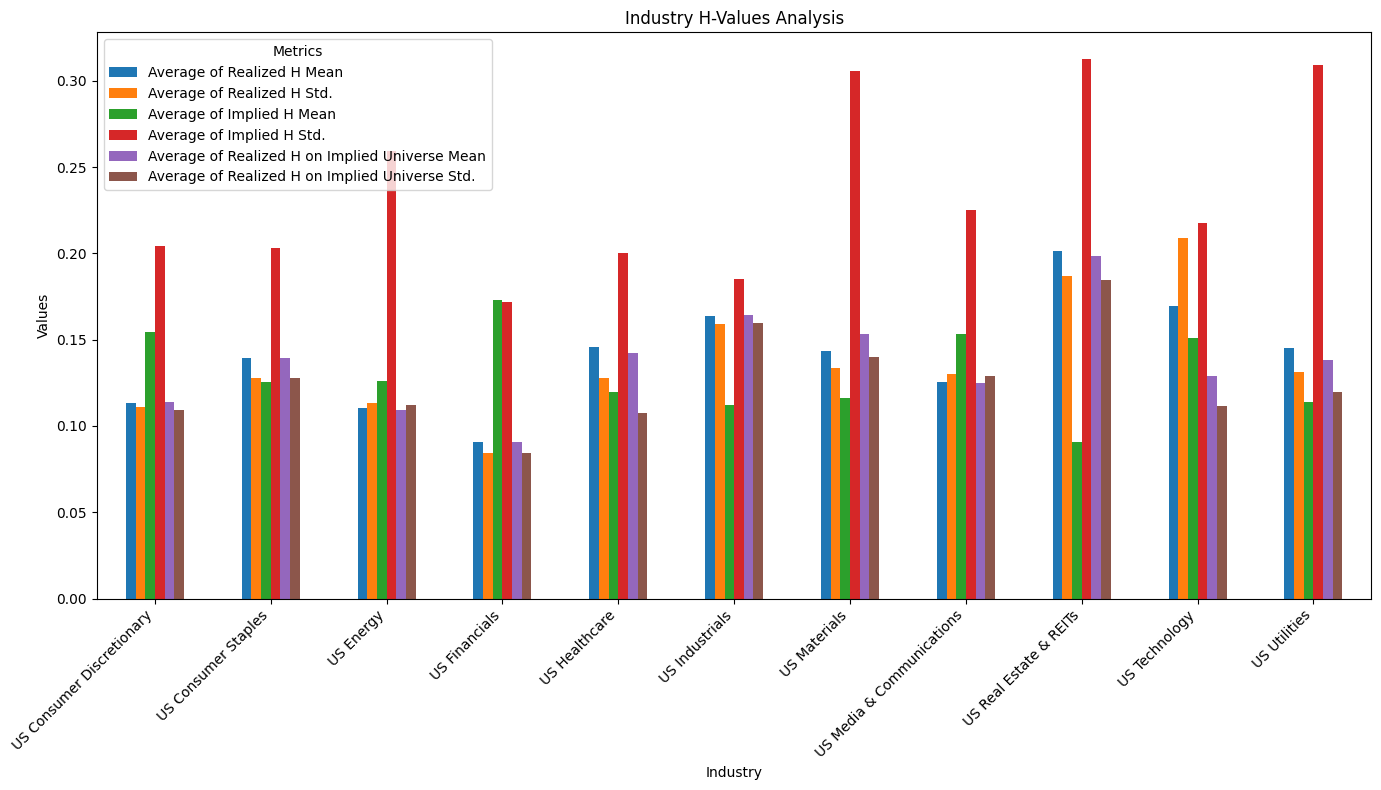

In [245]:
industry_df.set_index('industry').plot(kind='bar', figsize=(14, 8))
plt.title('Industry H-Values Analysis')
plt.xlabel('Industry')
plt.ylabel('Values')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

- Here we have taken the mean and std of H-values over the industry for a particular day and then calculated their means over the entire timeframe(as mentioned by the paper).
- We do this for Realized H values in total universe, Implied H values in implied universe and Realized H values in Implied universe.
- Stats of Implied H on Implied universe are considerably higher than the other 2 categories

In [246]:
IH = implied_H.groupby(['Date'])['H_value'].agg(['mean', 'std', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
IH.columns = ['mean', 'std', 'median', '25th Percentile', '75th Percentile']
IH_net=IH.mean(axis=0)
# IH_net

RH = betas.groupby(['year', 'month'])['Realized_H'].agg(['mean', 'std', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
RH.columns = ['mean', 'std', 'median', '25th Percentile', '75th Percentile']
RH_net=RH.mean(axis=0)

RH_implied = betas[betas['SYM_ROOT'].isin(implied_universe)]
RH_implied = RH_implied.groupby(['year', 'month'])['Realized_H'].agg(['mean', 'std', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
RH_implied.columns = ['mean', 'std', 'median', '25th Percentile', '75th Percentile']
RH_implied_net=RH_implied.mean(axis=0)

In [247]:
table = pd.concat([IH_net, RH_net, RH_implied_net], axis=1)
table.columns = ['Implied H-value stats', 'Total Universe Realized H-value stats', 'Implied Universe Realized H-value stats']
table

Implied H-value stats Total Universe Realized H-value stats  \
mean                          0.131190                              0.142008   
std                           0.263882                              0.190431   
median                        0.122834                              0.083154   
25th Percentile               0.004967                              0.045658   
75th Percentile               0.250085                              0.154352   

                Implied Universe Realized H-value stats  
mean                                           0.136771  
std                                            0.163468  
median                                         0.082355  
25th Percentile                                0.045153  
75th Percentile                                 0.15247

- On comparing this table to the one given in the paper we see that these two mostly agree 

## **Trading Strategy**

In [43]:
import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import zscore
import seaborn as sns
from matplotlib.dates import MonthLocator, DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from datetime import timedelta as td
import statsmodels.api as sm
import random
from functools import reduce
from scipy.stats import skew, kurtosis
import quandl

### **Downloading Data**

#### **H Value Data**

In [44]:
realised_h_df = pd.read_csv(r'./Realized_H/Realized_H_Data2.csv')
realised_h_df.rename(columns={'Realized_H':'H_value'}, inplace=True)
realised_h_df

date ticker      price   H_value
0      2010-01-29   ORCL   23.06000  0.049828
1      2010-02-26   ORCL   24.65000  0.005427
2      2010-03-31   ORCL   25.71000  0.108720
3      2010-04-30   ORCL   25.86750  0.023036
4      2010-05-28   ORCL   22.57000  7.055720
...           ...    ...        ...       ...
15457  2023-04-28   TSLA  164.31000  0.030113
15458  2023-05-31   TSLA  203.92999  0.023652
15459  2023-06-30   TSLA  261.76999  0.035020
15460  2023-07-31   TSLA  267.42999  0.026858
15461  2023-08-31   TSLA  258.07999  0.043508

[15462 rows x 4 columns]

In [45]:
implied_h_df = pd.read_csv(r'./Implied_H/H_values_output_options_final_monthly.csv')
implied_h_df.rename(columns={'Price':'price','Ticker':'ticker','Date':'date','close': 'price'}, inplace=True)
implied_h_df

ticker        date    price   H_value
0       AAPL  2010-01-29  192.063  0.418456
1       AAPL  2010-02-26  204.620  0.115471
2       AAPL  2010-03-31  235.000  0.341356
3       AAPL  2010-04-30  261.090  0.419943
4       AAPL  2010-05-31  256.880  0.042454
...      ...         ...      ...       ...
14666    XOM  2023-04-28  118.340  0.126797
14667    XOM  2023-05-31  102.180  0.134396
14668    XOM  2023-06-30  107.250  0.238618
14669    XOM  2023-07-31  107.240  0.292218
14670    XOM  2023-08-31  111.190  0.172328

[14671 rows x 4 columns]

#### **Downloading Daily blended LIBOR/SOFR Data**

In [46]:
# sofr_data = pd.read_csv(r"/Users/pr/Downloads/UChicago MSFM/Winter Quarter/QTS/Project/buy-rough-sell-smooth/FINM33150_Interp_LIBOR_SOFR_to_2025.tab", sep="\t")
# # Rename the first column to "date"
# sofr_data.rename(columns={sofr_data.columns[0]: "date", sofr_data.columns[1]:"sofr"}, inplace=True)

# import pandas as pd

# # Example: sofr_data has columns ["date", "sofr"] with daily data
# # 1) Convert "date" column to datetime
# sofr_data["date"] = pd.to_datetime(sofr_data["date"])

# # 2) Sort by date to ensure chronological order
# sofr_data.sort_values("date", inplace=True)

# # 3) Set "date" as the index (needed for rolling)
# sofr_data.set_index("date", inplace=True)

# # 4) Forward-fill any missing SOFR values
# sofr_data["sofr"] = sofr_data["sofr"].ffill()

# # 5) Compute the 3-month (90-day) rolling average
# #    If you want at least some average even when fewer than 90 days of data are available, use min_periods=1
# sofr_data["sofr_3M_Rolling_Avg"] = sofr_data["sofr"].rolling(window=90, min_periods=1).mean()

# # 6) (Optional) Reset the index so "date" is a column again
# sofr_data.reset_index(inplace=True)

# # Display the result
# print(sofr_data.tail())


#### **Downloading Monthly Ticker Values**

In [47]:
monthly_prices = pd.read_csv(r"./monthly_ticker_prices.csv")
monthly_prices

PERMNO        date TICKER        PRC
0       10104  2010-01-29   ORCL   23.06000
1       10104  2010-02-26   ORCL   24.65000
2       10104  2010-03-31   ORCL   25.71000
3       10104  2010-04-30   ORCL   25.86750
4       10104  2010-05-28   ORCL   22.57000
...       ...         ...    ...        ...
17752   93436  2023-04-28   TSLA  164.31000
17753   93436  2023-05-31   TSLA  203.92999
17754   93436  2023-06-30   TSLA  261.76999
17755   93436  2023-07-31   TSLA  267.42999
17756   93436  2023-08-31   TSLA  258.07999

[17757 rows x 4 columns]

### Downloading SPY data 

- for calculating downside beta later on

In [48]:
pravallika = {'Quandl':'Ccbn7K3VToRXnKFzzH2X'}

In [49]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.environ["HOME"], "Downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=pravallika['Quandl'], **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

In [50]:
eod_price_data = fetch_quandl_table('QUOTEMEDIA/PRICES', avoid_download=True)

Skipping any possible download of QUOTEMEDIA/PRICES


In [51]:
import pandas as pd

# Filter for SPY data and sort by date
spy_df = eod_price_data[eod_price_data["ticker"] == "SPY"].copy()
spy_df = spy_df.sort_values("date")

# Convert 'date' column to datetime
spy_df["date"] = pd.to_datetime(spy_df["date"])

# Resample to get the last business day of each month (BM frequency)
monthly_spy = spy_df.set_index("date").resample("BM").last().reset_index()

# Keep only the necessary columns
monthly_spy = monthly_spy[["date", "adj_close"]]

# Compute monthly returns as a fraction (e.g., 0.02 means +2%)
monthly_spy["spy_return"] = monthly_spy["adj_close"].pct_change().fillna(0)

display(monthly_spy.head())

date  adj_close  spy_return
0 1993-01-29  24.358021    0.000000
1 1993-02-26  24.617858    0.010667
2 1993-03-31  25.169487    0.022408
3 1993-04-30  24.525427   -0.025589
4 1993-05-31  25.186866    0.026970

### **Trading Strategy Implementation**

#### **Ranking Methodology: Quintile Ranking of H_value**

The ranking process assigns each ticker a rank from 1 to 5 within each month based on its roughness using the Hurst Index (H) values:

1. **Within-Month Sorting:**  
   Tickers are ordered by their H value on each month.  
   - The ticker with the highest H value is placed at the top.
   - The ticker with the lowest H value is placed at the bottom.

2. **Quintile Assignment:**  
   The ordered list is then divided into five equally sized groups (quintiles).  
   - **Rank 1:** Tickers with the highest H values.
   - **Rank 5:** Tickers with the lowest H values.
   - Intermediate ranks indicate middle groupings.

#### **Ranking Interpretation**
Within each month, every ticker receives an integer rank from **1** to **5**:
- **Rank 1:** Represents the most favorable condition for short positions.
- **Rank 5:** Represents the most favorable condition for long positions.
- Tickers with intermediate ranks remain neutral.

---

#### **Signal Generation**

Based on the quintile rankings:
- **Short Signal:** Issued to tickers with a rank equal to the predefined short threshold (Rank 1).
- **Long Signal:** Issued to tickers with a rank equal to the predefined long threshold (Rank 5).
- **Neutral:** Tickers with intermediate ranks receive no position.

By default, the strategy assumes trading 1 share per asset, though this can be adjusted as needed.

---

#### **Position Allocation**
At the start of each canonical monthly date (from the monthly_prices data):
- **Closing Positions:**  
  Any open positions from the previous month are closed at the current month’s price, realizing PnL and incurring closing transaction costs.
- **Opening New Positions:**  
  - **If New Signal Data is Available:**  
    New positions are opened at the current month’s ticker prices.  
    - **Equal Allocation:** If weighted_allocation is set to False, each ticker in a group (longs or shorts) receives an equal share of the allocated capital.
    - **Weighted Allocation:** If weighted_allocation is True, then:
      - **For Longs:** The allocation is weighted by `(max(H_value) - H_value)` so that tickers with lower H_value receive a higher weight.
      - **For Shorts:** The allocation is weighted by `(H_value - min(H_value))` so that tickers with higher H_value receive a higher weight.
    Opening positions incurs an opening transaction cost (a fraction of the allocated capital).
  - **If Signal Data is Missing for a particular month:**  
    The strategy closes any open positions (realizing PnL, subject to closing costs) and does not open new positions. This ensures that positions are never inadvertently carried over beyond the month with available h-value data.

#### **Profit/Loss (PnL) and Return Calculation**
- **Realized PnL:**  
  - For each month, the PnL is calculated from closing positions:
  
    $$
    \text{PnL} = \text{Allocation} \times \frac{\text{(Closing Price - Entry Price)}}{\text{Entry Price}}
    $$
  
    (For short positions, the return is reversed.)
  - Transaction costs are subtracted both at closing and opening.

  
- **Portfolio Value Update:**  
  The portfolio value is updated by adding the realized PnL to the previous month’s equity.
  
- **Monthly Return:**  
  Computed as the percentage change in portfolio value relative to the prior month’s equity.
  
- **Cumulative Return:**  
  Calculated as the total gain (or loss) relative to the initial equity.

#### Summary
- **Dynamic Rebalancing:**  
  The portfolio is rebalanced monthly—any open positions are closed each month, and new positions are opened only if valid signal data is available for that month.
  
- **Allocation Flexibility:**  
  Depending on the parameter **weighted_allocation**, allocations among tickers can be either equal or weighted by H_value (favoring lower H_value for longs and higher H_value for shorts).

- **Performance Tracking:**  
  The strategy tracks monthly realized PnL, portfolio value, monthly return, and cumulative return. Additional flags indicate whether a position was opened or closed in a given month.

This methodology ensures that the trading strategy:
- Uses H_value-based quintile ranking to generate clear long/short signals.
- Allocates capital based on either equal or weighted rules.
- Closes positions at each monthly rebalancing date so that positions are not held longer than a month when signal data is missing.
- Computes performance metrics on a normalized, capital-adjusted basis.

In [52]:
# Modify the function to rank h_vals into groups per date
def rank_H_quintiles(df, groups=5):
    # Ensure date column is in datetime format
    monthly = df.copy()
    monthly["date"] = pd.to_datetime(monthly["date"])
    
    # Sort values by date and h_val
    monthly = monthly.sort_values(["date", "H_value"])
    
    # Assign quintile ranks (1 to 5) based on h_val per date
    monthly["h_rank"] = (
    monthly.groupby("date")["H_value"]
    .transform(lambda x: pd.qcut(-x, q=groups, labels=False, duplicates='drop') + 1)
    )
    
    # Sort final result by ticker & date
    monthly = monthly.sort_values(["ticker", "date"]).reset_index(drop=True)
    
    return monthly

In [53]:
def generate_signal(rank_val, long=5, short=1, strat="long-short"):
    """
    Example signal generator for demonstration.
    Adjust as needed for your actual logic.
    """
    if strat == "long":
        return 1 if rank_val == long else 0
    elif strat == "short":
        return -1 if rank_val == short else 0
    else:  # long-short
        if rank_val == long:
            return 1 
        elif rank_val == short:
            return -1
        else:
            return 0

In [54]:
def trading_strategy(
    df,                    # DataFrame: at least ['date','ticker','price','h_rank','H_value']
    monthly_prices,        # DataFrame: columns ['PERMNO','date','TICKER','PRC'] (the canonical set of monthly points)
    long=5,
    short=1,
    transaction_cost=0.00001,     # fraction of allocated capital as transaction cost
    initial_equity=1_000_000,
    leverage=5,
    strat="long/short",
    weighted_allocation=True      # If True, weight allocation by H_value; if False, use equal weighting.
):
    """
    Implements a monthly rebalanced long/short strategy with the following rules:
      Scenario 1: Had an open position → close it (pay closing cost) → if data is available, open new position (pay opening cost).
      Scenario 2: Had an open position → close it (pay closing cost) → if data is missing (NaN), do not open a new position.
      Scenario 3: No position open → if new data is available, open position (pay opening cost).
      Scenario 4: No position open → if data is missing, remain with no position (no cost).

    PnL is realized from closing an old position and new positions are opened based solely on the current month's signal.
    'PRC' is used as fallback if 'price' is missing.
    
    The allocation for new positions can be computed in one of two ways:
      - If weighted_allocation is True: for longs, tickers with lower H_value get higher weight;
        for shorts, tickers with higher H_value get higher weight.
      - Otherwise, allocation is equal (long_exposure/n_long, etc.) as before.

    Returns:
      merged  -> The merged DataFrame with signals and intermediate columns.
      perf_df -> Monthly performance tracking DataFrame with:
                 date, realized_pnl, portfolio_val, monthly_return, cum_return,
                 position_open, position_close, no_position.
    """
    import pandas as pd
    import numpy as np

    ######################################
    # 1) Prepare & Merge Data
    ######################################
    df_copy = df.copy()
    df_copy["date"] = pd.to_datetime(df_copy["date"])
    df_copy.sort_values(["ticker", "date"], inplace=True)

    # Generate signals (if not already present)
    df_copy["h_signal"] = df_copy["h_rank"].apply(lambda r: generate_signal(r, long, short, strat))

    # Convert monthly_prices to datetime and sort
    mp_copy = monthly_prices.copy()
    mp_copy["date"] = pd.to_datetime(mp_copy["date"])
    mp_copy.sort_values(["TICKER", "date"], inplace=True)

    # Merge df_copy onto mp_copy by matching date and TICKER.
    merged = pd.merge(
        mp_copy, 
        df_copy[["date", "ticker", "price", "H_value", "h_rank", "h_signal"]],
        left_on=["date", "TICKER"],
        right_on=["date", "ticker"],
        how="left"
    )
    merged.drop(columns=["ticker"], inplace=True)
    merged.sort_values(["TICKER", "date"], inplace=True, ignore_index=True)

    ######################################
    # 2) Iterate Month-by-Month
    ######################################
    prev_equity = initial_equity

    # Dictionary to track open positions from the prior month.
    # open_positions[ticker] = {"signal": ..., "entry_price": ..., "allocation": ...}
    open_positions = {}

    monthly_pnl_records = []

    all_dates = merged["date"].unique()
    for dt in all_dates:
        current_slice = merged[merged["date"] == dt].copy()

        # Flags to track events this month.
        position_closed = False
        position_opened = False

        # -----------------------------
        # 2A) Close out prior positions
        # -----------------------------
        realized_pnl = 0.0
        if open_positions:
            position_closed = True
            for tk, pos in list(open_positions.items()):
                old_signal = pos["signal"]
                old_price = pos["entry_price"]
                allocation = pos["allocation"]

                # Find the row for this TICKER in the current_slice.
                row_ticker = current_slice[current_slice["TICKER"] == tk]
                if not row_ticker.empty:
                    # Prefer 'price' and fallback to 'PRC'
                    close_price = row_ticker["price"].iloc[0]
                    if pd.isna(close_price):
                        close_price = row_ticker["PRC"].iloc[0]
                    if pd.notna(close_price):
                        ret = (close_price - old_price) / old_price
                        if old_signal == -1:
                            ret = -ret
                        pos_pnl = allocation * ret
                        pos_pnl -= allocation * transaction_cost  # Closing cost
                        realized_pnl += pos_pnl
                    else:
                        realized_pnl -= allocation * transaction_cost
                else:
                    realized_pnl -= allocation * transaction_cost

                # Remove the closed position.
                open_positions.pop(tk)
        
        if pd.isna(realized_pnl):
            realized_pnl = 0.0

        portfolio_val_after_close = prev_equity + realized_pnl

        # -----------------------------
        # 2B) Open new positions this month
        # -----------------------------
        valid_slice = current_slice.dropna(subset=["h_signal"])

        # Split into long and short slices.
        long_slice = valid_slice[valid_slice["h_signal"] == 1].copy()
        short_slice = valid_slice[valid_slice["h_signal"] == -1].copy()
        n_long = len(long_slice)
        n_short = len(short_slice)

        total_exposure = portfolio_val_after_close
        long_exposure = total_exposure / 2 if n_long > 0 else 0
        short_exposure = total_exposure / 2 if n_short > 0 else 0

        if weighted_allocation:
            # For long positions: weight = max(H_value) - H_value.
            if n_long > 0:
                long_slice["weight"] = long_slice["H_value"].max() - long_slice["H_value"]
                weight_sum = long_slice["weight"].sum()
                if weight_sum != 0:
                    long_slice["weight"] = long_slice["weight"] / weight_sum
                else:
                    long_slice["weight"] = 1.0 / n_long
            # For short positions: weight = H_value - min(H_value).
            if n_short > 0:
                short_slice["weight"] = short_slice["H_value"] - short_slice["H_value"].min()
                weight_sum = short_slice["weight"].sum()
                if weight_sum != 0:
                    short_slice["weight"] = short_slice["weight"] / weight_sum
                else:
                    short_slice["weight"] = 1.0 / n_short
        else:
            # Equal weighting.
            if n_long > 0:
                long_slice["weight"] = 1.0 / n_long
            if n_short > 0:
                short_slice["weight"] = 1.0 / n_short

        # Open positions for longs.
        if n_long > 0:
            for idx, row in long_slice.iterrows():
                tk = row["TICKER"]
                open_price = row["price"]
                if pd.isna(open_price):
                    continue
                allocation = long_exposure * row["weight"]
                open_cost = allocation * transaction_cost
                realized_pnl -= open_cost
                open_positions[tk] = {"signal": 1, "entry_price": open_price, "allocation": allocation}
            position_opened = True

        # Open positions for shorts.
        if n_short > 0:
            for idx, row in short_slice.iterrows():
                tk = row["TICKER"]
                open_price = row["price"]
                if pd.isna(open_price):
                    continue
                allocation = short_exposure * row["weight"]
                open_cost = allocation * transaction_cost
                realized_pnl -= open_cost
                open_positions[tk] = {"signal": -1, "entry_price": open_price, "allocation": allocation}
            position_opened = True

        # -----------------------------
        # 2C) Record performance for this month.
        # -----------------------------
        new_equity = prev_equity + realized_pnl
        monthly_ret = realized_pnl / prev_equity if prev_equity != 0 else 0

        # Determine if no new position was taken and no closing occurred.
        no_position = not (position_closed or position_opened)

        monthly_pnl_records.append({
            "date": dt,
            "realized_pnl": realized_pnl,
            "portfolio_val": new_equity,
            "monthly_return": monthly_ret,
            "position_open": position_opened,
            "position_close": position_closed,
            "no_position": no_position
        })

        prev_equity = new_equity

    perf_df = pd.DataFrame(monthly_pnl_records).sort_values("date")
    perf_df["realized_pnl"] = perf_df["realized_pnl"].fillna(0)
    perf_df["cum_return"] = (perf_df["portfolio_val"] - initial_equity) / initial_equity

    return merged, perf_df


### Monthly returns dataframe returned from the strategy for realized roughness

In [55]:
realised_h_rank_df = rank_H_quintiles(realised_h_df)
realised_h_positions, realised_h_strat_returns = trading_strategy(
    realised_h_rank_df,
    monthly_prices,
    long=5,
    short=1,
    strat = "long-short",
    weighted_allocation=True
)
realised_h_strat_returns

date  realized_pnl  portfolio_val  monthly_return  position_open  \
0   2010-01-29    -10.000000   9.999900e+05       -0.000010           True   
1   2010-02-26   1887.621714   1.001878e+06        0.001888           True   
2   2010-03-31  10039.419296   1.011917e+06        0.010021           True   
3   2010-04-30 -70112.685360   9.418044e+05       -0.069287           True   
4   2010-05-28    352.331860   9.421567e+05        0.000374           True   
..         ...           ...            ...             ...            ...   
159 2023-04-28  10670.088108   8.526918e+05        0.012672           True   
160 2023-05-31   5922.075176   8.586138e+05        0.006945           True   
161 2023-06-30 -25182.856779   8.334310e+05       -0.029330           True   
162 2023-07-31 -15714.520696   8.177165e+05       -0.018855           True   
163 2023-08-31 -20225.475350   7.974910e+05       -0.024734           True   

     position_close  no_position  cum_return  
0             False        False   -0.000010  
1              True        False    0.001878  
2              True        False    0.011917  
3              True        False   -0.058196  
4              True        False   -0.057843  
..              ...          ...         ...  
159            True        False   -0.147308  
160            True        False   -0.141386  
161            True        False   -0.166569  
162            True        False   -0.182284  
163            True        False   -0.202509  

[164 rows x 8 columns]

### Monthly returns dataframe returned from the strategy for implied return 

In [56]:
implied_h_rank_df = rank_H_quintiles(implied_h_df)
implied_h_positions, implied_h_strat_returns = trading_strategy(
    implied_h_rank_df,
    monthly_prices,
    long=5,
    short=1,
    strat = "long-short",
    weighted_allocation=True
)
implied_h_strat_returns

date  realized_pnl  portfolio_val  monthly_return  position_open  \
0   2010-01-29    -10.000000   9.999900e+05       -0.000010           True   
1   2010-02-26   -361.079057   9.996289e+05       -0.000361           True   
2   2010-03-31 -14354.001831   9.852749e+05       -0.014359           True   
3   2010-04-30  -7650.754843   9.776242e+05       -0.007765           True   
4   2010-05-28   2587.250091   9.802114e+05        0.002646          False   
..         ...           ...            ...             ...            ...   
159 2023-04-28  31278.387715   1.207442e+06        0.026594           True   
160 2023-05-31 -20345.513048   1.187097e+06       -0.016850           True   
161 2023-06-30   1663.131171   1.188760e+06        0.001401           True   
162 2023-07-31 -20951.189755   1.167809e+06       -0.017624           True   
163 2023-08-31   -938.511018   1.166870e+06       -0.000804           True   

     position_close  no_position  cum_return  
0             False        False   -0.000010  
1              True        False   -0.000371  
2              True        False   -0.014725  
3              True        False   -0.022376  
4              True        False   -0.019789  
..              ...          ...         ...  
159            True        False    0.207442  
160            True        False    0.187097  
161            True        False    0.188760  
162            True        False    0.167809  
163            True        False    0.166870  

[164 rows x 8 columns]

## **Backtesting / Analysis**

In [57]:
def plot_monthly_pnl(pnl_df: pd.DataFrame, window: int = 4) -> pd.DataFrame:
    """
    Plots the monthly PnL time-series with a moving average line, cumulative PnL, and rolling volatility.
    
    Parameters:
      pnl_df: DataFrame with a 'date' column and columns 'pnl' and 'cum_pnl'.
      window: The window (in months) over which to compute the moving average and volatility (default is 3 months).
      
    Returns:
      summary_df: A DataFrame with summary statistics for pnl and cum_pnl.
    """
    # Create a copy and ensure 'date' is datetime and set as index.
    df = pnl_df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    # Compute the moving average for pnl.
    df['Moving_Avg'] = df['monthly_return'].rolling(window=window).mean()
    
    # Compute rolling volatility (standard deviation) for pnl.
    df['Rolling_Vol'] = df['monthly_return'].rolling(window=window).std()
    # Annualize the volatility (for monthly data, use sqrt(12))
    df['Annualized_Vol'] = df['Rolling_Vol'] * np.sqrt(12)
    
    # Create the plot with 3 subplots (vertical layout)
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    
    # --- Plot 1: Monthly PnL with Moving Average ---
    axes[0].plot(df.index, df['monthly_return'], linestyle='-', label='Monthly Return', alpha=0.7)
    axes[0].plot(df.index, df['Moving_Avg'], color='red', linewidth=2, label=f'{window}-month Moving Avg')
    axes[0].set_title('Monthly Return with Moving Average')
    axes[0].set_ylabel('Monthly Return')
    axes[0].legend()
    axes[0].grid(True)
    
    # --- Plot 2: Cumulative PnL ---
    axes[1].plot(df.index, df['cum_return'], linestyle='-', color='green', linewidth=2, label='Cumulative Return')
    axes[1].set_title('Cumulative Return Over Time')
    axes[1].set_ylabel('Cumulative Return')
    axes[1].legend()
    axes[1].grid(True)
    
    # --- Plot 3: Rolling Volatility ---
    axes[2].plot(df.index, df['Rolling_Vol'], linestyle='-', color='blue', linewidth=2, label=f'{window}-month Rolling Volatility')
    axes[2].plot(df.index, df['Annualized_Vol'], linestyle='--', color='orange', linewidth=2, label='Annualized Volatility')
    axes[2].set_title('Rolling Volatility of Monthly Return')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Volatility')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate summary statistics for pnl and cum_pnl.
    summary_df = df[['monthly_return']].describe().T.style.format("{:.3f}")
    
    return summary_df

In [58]:
def compute_tail_metrics(data: pd.Series, level: float) -> tuple:
    """Compute VaR and Expected Shortfall for a given quantile level."""
    var = data.quantile(level)
    es = data[data <= var].mean()  # average loss below the quantile
    return var, es

def plot_pnl_distribution(pnl_df: pd.DataFrame, column: str = 'monthly_return', bins: int = 30) -> pd.DataFrame:
    """
    Plots the PnL distribution with histogram and KDE, and calculates tail metrics.
    
    Parameters:
      pnl_df: DataFrame containing a PnL column (default name 'pnl').
      column: The column name in pnl_df to use for the PnL data.
      bins: Number of bins for the histogram (default is 30).
      
    Returns:
      summary_df: A styled DataFrame with summary metrics including quantiles, VaR, ES, skewness, and kurtosis.
    """
    # Extract and drop NaN values from the PnL data.
    data = pnl_df[column].dropna()
    
    mean_val = data.mean()
    median_val = data.median()
    mode_series = data.mode()
    # If you want to display the mode, you can uncomment the following line:
    # mode_val = mode_series.iloc[0] if not mode_series.empty else np.nan
    
    plt.figure(figsize=(10, 6))
    
    # Plot histogram and KDE of the PnL data.
    sns.histplot(data, bins=bins, stat="density", color="skyblue", edgecolor="black", alpha=0.6, label="Return Histogram")
    sns.kdeplot(data, color='red', lw=2, label='KDE')
    
    # Plot vertical lines for mean and median.
    plt.axvline(mean_val, color='green', linestyle='--', lw=2, label=f'Mean: {mean_val:.3f}')
    plt.axvline(median_val, color='blue', linestyle='--', lw=2, label=f'Median: {median_val:.3f}')
    # To include the mode, uncomment the following:
    # plt.axvline(mode_val, color='purple', linestyle='--', lw=2, label=f'Mode: {mode_val:.2f}')
    
    plt.title("Distribution of Monthly Return")
    plt.xlabel("Return")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Compute tail metrics and moments.
    q1 = data.quantile(0.01)
    q99 = data.quantile(0.99)
    var_1, es_1 = compute_tail_metrics(data, 0.01)
    var_5, es_5 = compute_tail_metrics(data, 0.05)
    skew_val = skew(data)
    kurt_val = kurtosis(data)
    
    summary = {
        '1% Quantile': q1,
        '99% Quantile': q99,
        '1% VaR': var_1,
        '1% ES': es_1,
        '5% VaR': var_5,
        '5% ES': es_5,
        'Skewness': skew_val,
        'Kurtosis': kurt_val
    }
    
    summary_df = pd.DataFrame(summary, index=["Value"]).style.format("{:.2f}")
    return summary_df

In [59]:
import numpy as np
import pandas as pd

def calculate_performance_metrics(pnl_df: pd.DataFrame, monthly_spy: pd.DataFrame, equity: float = 1_000_000) -> pd.DataFrame:
    """
    Calculates a range of performance metrics from the monthly performance DataFrame.
    
    Expects pnl_df to have at least the following columns:
      - 'monthly_return' (monthly return as a decimal, e.g., 0.02 for +2%)
      - 'cum_return' (cumulative return as a decimal, e.g., 0.50 for +50%)
      - 'realized_pnl' (monthly realized PnL in dollars)
      
    Additionally, monthly_spy is expected to have columns:
      - 'date'
      - 'spy_return' (SPY's monthly return as a decimal)
      
    Additional metrics calculated:
      - Median Monthly Return
      - Cumulative Monthly Return (final cum_return)
      - Total PnL
      - Number of Trades (months with nonzero pnl)
      - Average PnL per Trade
      - Average Winning Trade (mean pnl of winning months)
      - Average Losing Trade (mean pnl of losing months)
      - Maximum Trade Win (max monthly pnl)
      - Maximum Trade Loss (min monthly pnl)
      - Win Ratio (%) (percentage of months with positive pnl)
      - Profit Factor (sum of winning pnl divided by absolute sum of losing pnl)
      - Max Consecutive Wins and Losses (over monthly returns)
      - Annualized Sharpe and Sortino Ratios (based on monthly_return)
      - Maximum Drawdown (from cum_return)
      - Downside Beta (beta computed using only months where SPY return is negative)
    """
    # Basic statistics for returns:
    avg_return = pnl_df['monthly_return'].mean()
    std_return = pnl_df['monthly_return'].std()
    sharpe = (avg_return / std_return * np.sqrt(12)) if std_return != 0 else np.nan
    
    # Final cumulative monthly return:
    final_cum_return = pnl_df['cum_return'].iloc[-1] if len(pnl_df) > 0 else np.nan
    
    # Median monthly return:
    median_return = pnl_df['monthly_return'].median() if len(pnl_df) > 0 else np.nan

    # Maximum drawdown:
    running_max = pnl_df['cum_return'].cummax()
    max_dd = (pnl_df['cum_return'] - running_max).min()

    num_periods = len(pnl_df)

    # Sortino ratio:
    downside = pnl_df.loc[pnl_df['monthly_return'] < 0, 'monthly_return']
    downside_std = downside.std() if len(downside) > 0 else np.nan
    sortino = (avg_return / downside_std * np.sqrt(12)) if downside_std and not np.isnan(downside_std) else np.nan

    # Win ratio and profit factor:
    win_ratio = (pnl_df['monthly_return'] > 0).mean() * 100
    sum_wins = pnl_df.loc[pnl_df['monthly_return'] > 0, 'monthly_return'].sum()
    sum_losses = pnl_df.loc[pnl_df['monthly_return'] < 0, 'monthly_return'].sum()
    profit_factor = sum_wins / abs(sum_losses) if sum_losses != 0 else np.nan

    # Trade-based metrics using 'realized_pnl':
    total_pnl = pnl_df['realized_pnl'].sum()
    trade_mask = pnl_df['realized_pnl'].abs() > 1e-6
    num_trades = trade_mask.sum()
    avg_pnl_per_trade = total_pnl / num_trades if num_trades > 0 else np.nan
    winning_trades = pnl_df.loc[pnl_df['realized_pnl'] > 0, 'realized_pnl']
    losing_trades = pnl_df.loc[pnl_df['realized_pnl'] < 0, 'realized_pnl']
    avg_win = winning_trades.mean() if len(winning_trades) > 0 else np.nan
    avg_loss = losing_trades.mean() if len(losing_trades) > 0 else np.nan
    max_win = pnl_df['realized_pnl'].max() if not pnl_df['realized_pnl'].empty else np.nan
    max_loss = pnl_df['realized_pnl'].min() if not pnl_df['realized_pnl'].empty else np.nan

    # Maximum consecutive wins/losses:
    monthly_returns = pnl_df['monthly_return'].values
    max_consec_wins = 0
    max_consec_losses = 0
    current_wins = 0
    current_losses = 0
    for r in monthly_returns:
        if r > 0:
            current_wins += 1
            current_losses = 0
        else:
            current_losses += 1
            current_wins = 0
        max_consec_wins = max(max_consec_wins, current_wins)
        max_consec_losses = max(max_consec_losses, current_losses)
    
    # Downside Beta: calculate beta of strategy returns to SPY returns in months when SPY is negative.
    # Merge pnl_df with monthly_spy on 'date'
    df_merged = pd.merge(pnl_df, monthly_spy[['date','spy_return']], on='date', how='inner')
    df_downside = df_merged[df_merged['spy_return'] < 0]
    if len(df_downside) > 1:
        cov_matrix = np.cov(df_downside['monthly_return'], df_downside['spy_return'])
        cov_val = cov_matrix[0, 1]
        var_val = np.var(df_downside['spy_return'])
        downside_beta = cov_val / var_val if var_val != 0 else np.nan
    else:
        downside_beta = np.nan

    metrics = {
        'Average Monthly Return': avg_return,
        'Std Monthly Return': std_return,
        'Median Monthly Return': median_return,
        'Cumulative Monthly Return': final_cum_return,
        'Annualized Sharpe Ratio': sharpe,
        'Annualized Sortino Ratio': sortino,
        'Maximum Drawdown': max_dd,
        'Number of Periods (Months)': num_periods,
        'Win Ratio (%)': win_ratio,
        'Profit Factor': profit_factor,
        'Max Consecutive Wins': max_consec_wins,
        'Max Consecutive Losses': max_consec_losses,
        'Total PnL ($)': total_pnl,
        'Number of Trades': num_trades,
        'Average PnL per Trade ($)': avg_pnl_per_trade,
        'Average Winning Trade ($)': avg_win,
        'Average Losing Trade ($)': avg_loss,
        'Maximum Win ($)': max_win,
        'Maximum Loss ($)': max_loss,
        'Downside Beta': downside_beta
    }
    
    summary_df = pd.DataFrame(metrics, index=["Value"]).T.style.format("{:.4f}")
    return summary_df


In [60]:
def run_various_long_short_positions(
    df,
    monthly_prices,
    strategy_list,         # e.g., a list of dicts: [{"long":1,"short":None,"strat":"long_only","col_name":"1 Smooth"}, ...]
    weighted_allocation=True
):
    """
    Runs trading_strategy for multiple configurations (long, short, strat, etc.),
    calculates performance metrics for each, and returns a DataFrame where:
      - rows = metric names (e.g. Average Monthly Return, Std Monthly Return, etc.)
      - columns = scenario labels (taken from strategy_list[i]["col_name"])
    
    Example strategy_list:
      [
        {"long":1, "short":None, "strat":"long_only", "col_name":"1 Smooth"},
        {"long":2, "short":None, "strat":"long_only", "col_name":"2"},
        {"long":5, "short":1, "strat":"long/short", "col_name":"5-1"}
      ]
    """
    import pandas as pd

    final_df = None  # We'll build this up by horizontally concatenating columns.

    for config in strategy_list:
        # 1) Run the strategy with the given config
        implied_h_positions, implied_h_strat_returns = trading_strategy(
            df,
            monthly_prices,
            long=config.get("long", 5),
            short=config.get("short", None),
            strat=config["strat"],
            weighted_allocation=weighted_allocation
        )

        # 2) Calculate performance metrics (returns a styled DataFrame)
        perf_summary = calculate_performance_metrics(implied_h_strat_returns, monthly_spy)

        # 3) Convert the styled DataFrame to an unstyled DataFrame
        #    Typically, perf_summary.data is a single-column DataFrame with index=metric names, col="Value".
        unstyled_df = perf_summary.data  # e.g., index=["Average Monthly Return", ...], columns=["Value"]

        # 4) Use the user-provided col_name for this scenario
        scenario_label = config["col_name"]  # user must ensure col_name is present in config

        # 5) Convert unstyled_df into a single-column DF with scenario_label as the column name
        scenario_df = pd.DataFrame(unstyled_df["Value"])
        scenario_df.columns = [scenario_label]

        # 6) Concatenate side-by-side
        if final_df is None:
            final_df = scenario_df
        else:
            final_df = pd.concat([final_df, scenario_df], axis=1)

    return final_df


### **Performance of portfolios sorted on realized roughness**

### Weighted portfolio (based on H-values)

In [61]:
# Example strategy configurations:
strategy_list_5 = [
    {"long":1, "short":None, "strat":"long", "col_name":"1 Smooth"},    # scenario: long=1, short=None => "long_only"
    {"long":2, "short":None, "strat":"long", "col_name":"2"},
    {"long":3, "short":None, "strat":"long", "col_name":"3"},
    {"long":4, "short":None, "strat":"long", "col_name":"4"},
    {"long":5, "short":None, "strat":"long", "col_name":"5 Rough"},              # scenario: long=2, short=None => "long_only"
    {"long":5, "short":1, "strat":"long-short", "col_name":"5-1"}       # scenario: long=5, short=1 => "long/short"
]

# Run them all (assuming weighted_allocation=True or False as you prefer)
realised_h_rank_df_5 = rank_H_quintiles(realised_h_df, groups=5)
comparison_df = run_various_long_short_positions(
    realised_h_rank_df_5,
    monthly_prices,strategy_list_5,
    weighted_allocation=True
)

# Inspect results
comparison_df.style.format("{:.4f}")


The results in the second table reveal several key differences from the findings in the paper. While the expectation was that a long position in the roughest quintile (5 Rough) would outperform the smoothest (1 Smooth), and that a long-short (5-1) strategy would generate consistent returns, the actual implementation presents deviations.

##### **1. Long-Only Strategies Perform Better Than Long-Short**
- The long-only strategy on the roughest quintile (**5 Rough**) delivers a **higher cumulative return (1.8881)** compared to the long-short (**5-1**) strategy, which has a **negative cumulative return (-0.2025)**.
- This suggests that while rough assets might carry a return premium, **shorting smooth assets (1 Smooth) has not generated sufficient gains and may even have contributed to losses**.

##### **2. Lower Returns for Long-Short Strategy Compared to the Paper**
- The **mean return of the 5-1 strategy** in the paper was **0.38**, but in this implementation, it has yielded a **negative monthly return of -0.0012**.
- The **Sharpe Ratio for 5-1 is negative (-0.2147)**, indicating that the risk-adjusted return is unfavorable, whereas **the 5 Rough strategy has a Sharpe Ratio of 0.9867**.
- Possible reasons for this discrepancy include:
  1. **Difference in Universe**:  
     - The paper includes **thousands of stocks**, whereas this strategy is limited to **~100 tickers** due to data constraints, particularly from the options dataset.
  2. **Methodology Differences**:  
     - Differences in how the **Hurst exponent (H value)** is computed, the **portfolio weighting scheme**, and execution methodology may impact results.

##### **3. Risk Metrics: Sharpe Ratios and Drawdowns**
- **Maximum Drawdowns** show that the **5 Rough strategy (-0.2023) is much better than 5-1 (-0.3125)**, suggesting that the long-only strategy has been more resilient.
- The **Sortino Ratio**, which penalizes downside risk, is also much higher for **5 Rough (1.6250)** than for **5-1 (-0.3499)**, further reinforcing that **shorting smooth assets has not added value in this dataset**.

##### **4. Downside Beta and Market Risk Sensitivity**
- The **downside beta for 5 Rough is 0.4556**, meaning it has lower sensitivity to market downturns than the **1 Smooth (0.4933)** strategy.
- Interestingly, the **5-1 strategy has a downside beta of -0.0127**, meaning **its returns are largely uncorrelated with market declines**.  
  - This suggests that the long-short portfolio **is not effectively capturing systematic risk and return relationships**.

##### **5. Win Ratios and Profit Factor Indicate Favorable Long Positions**
- The **win ratio (%) for 5 Rough (64.02%)** suggests that it has positive returns in nearly two-thirds of the months.
- The **profit factor (2.0267) for 5 Rough** is strong, meaning **gains outweigh losses**.
- In contrast, **the profit factor for 5-1 is just 0.8465**, indicating that **losses dominate gains in the long-short portfolio**.

---

##### **Interpretation**
- The results confirm that **going long in rough assets (5 Rough) can yield superior returns**, aligning with the theoretical expectation.
- However, **the 5-1 long-short strategy has underperformed significantly**, likely due to:
  - **Limitations in data coverage** (e.g., smaller investment universe).
  - **Weighting methodology differences**.
  - **Liquidity constraints** affecting execution.

Rather than dismissing the rough-smooth hypothesis, **these results suggest that careful selection of assets, improved execution, and a larger dataset may be necessary to fully capture the expected returns from a long-short portfolio**.  

A potential improvement could involve refining the **short leg of the strategy** (e.g., by selecting only a subset of smooth assets based on liquidity or volatility characteristics).

Thus, while the **long-only rough portfolio aligns with theoretical expectations**, the **underperformance of the long-short portfolio requires further exploration into data selection, portfolio weighting, and risk controls**.


### Equally Weighted Portfolio

In [62]:
realised_h_rank_df_5 = rank_H_quintiles(realised_h_df, groups=5)
comparison_df = run_various_long_short_positions(
    realised_h_rank_df_5,
    monthly_prices,strategy_list_5,
    weighted_allocation=False
)

# Inspect results
comparison_df.style.format("{:.4f}")

The table above shows the **equally weighted** results for each quintile (1 Smooth through 5 Rough) and the long‐short (5–1) approach. Previously, we observed performance metrics under an **H‐weighted** scheme, where positions in each quintile were scaled according to how extreme the H‐values were (i.e., rougher assets got higher allocations for the long side).

1. **Overall Returns and Risk**  
   - **Equally weighted** returns tend to be lower (or more moderate) than in the H‐weighted version, especially for the long only portfolios.
   - Whereas, for the long‐short (5–1) portfolio, the returns are less negative comparatively.  
   - **Maximum Drawdown** and other risk measures (Sharpe, Sortino) may shift accordingly. In many cases, the H‐weighted portfolios previously exhibited higher returns (and sometimes higher volatility) because they concentrated capital in the tickers with the most extreme roughness.

2. **5 Rough vs. 5–1**  
   - As before, **5 Rough** often outperforms **5–1** under the equal‐weight approach. The roughest assets still appear to deliver stronger returns in a long‐only format than in a long‐short pairing with smooth assets.

3. **Difference from H‐Weighted Logic**  
   - **H‐weighted** invests more heavily in the most extreme H‐value tickers (lowest H for longs, highest H for shorts), which can amplify returns (and risk).  
   - **Equally weighted** spreads capital evenly among all tickers in each quintile, resulting in less exposure to the most “extreme” roughness signals, often producing more moderate performance outcomes.

4. **Practical Implications**  
   - If the H‐value signal is strong, **H‐weighted** allocation can yield higher returns (as the capital is focused on the most pronounced roughness signals).  
   - However, equally weighted portfolios can be more stable and less susceptible to outliers if the signal is noisy or if there are liquidity concerns in the most extreme H‐value tickers.

#### Conclusion

- **H‐weighted** strategies may outperform in a market where the roughness signal is consistent and reliable, as capital is concentrated in the most promising tickers.  
- **Equally weighted** strategies can act as a more conservative baseline, distributing risk more evenly.  
- In these results, the **equally weighted** approach shows somewhat lower returns than the **H‐weighted** version for the same quintiles, but it may exhibit less extreme drawdowns and be more robust if the roughness signal is less reliable. 

### Switching from **quintiles (5 groups)** to **deciles (10 groups)** 
provides a more granular partition of the universe. Instead of splitting tickers into just “smoothest,” “roughest,” and three intermediate tiers, you now have ten distinct brackets of H values. This can:

1. **Reveal finer patterns**:  
   - If certain returns or risk characteristics vary gradually across the H spectrum, deciles might show a clearer trend than broad quintiles.

2. **Isolate the extremes more precisely**:  
   - The “lowest 10%” vs. “highest 10%” in roughness might capture subtleties missed by the 20% cutoffs in quintiles.

3. **Potential trade‐off**:  
   - Each decile will contain fewer tickers if your overall universe is not very large, which can increase volatility or reduce stability in each group’s performance.  
   - You might see more month‐to‐month noise, especially in deciles with fewer assets.

Overall, **deciles** offer a **more refined lens** to analyze how roughness (H values) correlates with returns and risk, at the cost of potentially higher variance in each group’s metrics due to fewer stocks per bucket.


In [63]:
# Example strategy configurations:
strategy_list_10 = [
    {"long":1, "short":None, "strat":"long", "col_name":"1 Smooth"},    # scenario: long=1, short=None => "long_only"
    {"long":2, "short":None, "strat":"long", "col_name":"2"},
    {"long":3, "short":None, "strat":"long", "col_name":"3"},
    {"long":4, "short":None, "strat":"long", "col_name":"4"},
    {"long":5, "short":None, "strat":"long", "col_name":"5"},             
    {"long":6, "short":None, "strat":"long", "col_name":"6"},
    {"long":7, "short":None, "strat":"long", "col_name":"7"},   
    {"long":8, "short":None, "strat":"long", "col_name":"8"},
    {"long":9, "short":None, "strat":"long", "col_name":"9"},
    {"long":10, "short":None, "strat":"long", "col_name":"10 Rough"},
    {"long":10, "short":1, "strat":"long-short", "col_name":"10-1"}     
]

# Run them all (assuming weighted_allocation=True or False as you prefer)
realised_h_rank_df_10 = rank_H_quintiles(realised_h_df, groups=10)
comparison_df = run_various_long_short_positions(
    realised_h_rank_df_10,
    monthly_prices,strategy_list_10,
    weighted_allocation=True
)

# Inspect results
comparison_df.style.format("{:.4f}")

### **Decile‐Based Roughness Strategy Results: Concise Interpretation**

Switching from **quintiles** to **deciles** refines how H values (roughness) are split:

1. **Finer Gradation**  
   - **Deciles** (10% slices) provide a more detailed view of performance than quintiles (20% slices).  
   - This additional granularity highlights subtle differences in the mid‐range deciles and isolates the most extreme roughness more precisely (decile 10) vs. the smoothest assets (decile 1).

2. **Rough Assets (Decile 10) Still Outperform**  
   - As with the quintile analysis, the **roughest decile** generally shows **higher returns** and better risk‐adjusted metrics (Sharpe, Sortino) than the smoother deciles.  
   - This consistency reaffirms that **going long on the roughest assets** is the most effective approach in this dataset.

3. **Long–Short (10–1) Remains Unprofitable**  
   - Like the 5–1 strategy under quintiles, the **10–1 decile** approach underperforms or even shows negative returns.  
   - The short leg on the smoothest decile has not contributed enough to boost performance, suggesting that **long–short** in this data sample fails to add value.

4. **Key Takeaways**  
   - **Deciles** confirm the **rough > smooth** return relationship with finer resolution.  
   - The **best returns** still come from a **long‐only** position in the **lowest H** (roughest) group.  
   - **Shorting** the smooth group (highest H) remains detrimental in this dataset.

In summary, the decile analysis refines the earlier quintile results but leads to the same core conclusion: **long‐only exposure to the most “rough” assets outperforms any long–short combination involving “smooth” assets.**

### Descriptive Stats and Graphs of Long Rough (5) strategy of realised roughness

In [64]:
realised_h_positions, realised_h_strat_returns_long_5 = trading_strategy(
    realised_h_rank_df_5,
    monthly_prices,
    long=5,
    short=1,
    strat = "long",
    weighted_allocation=True
)

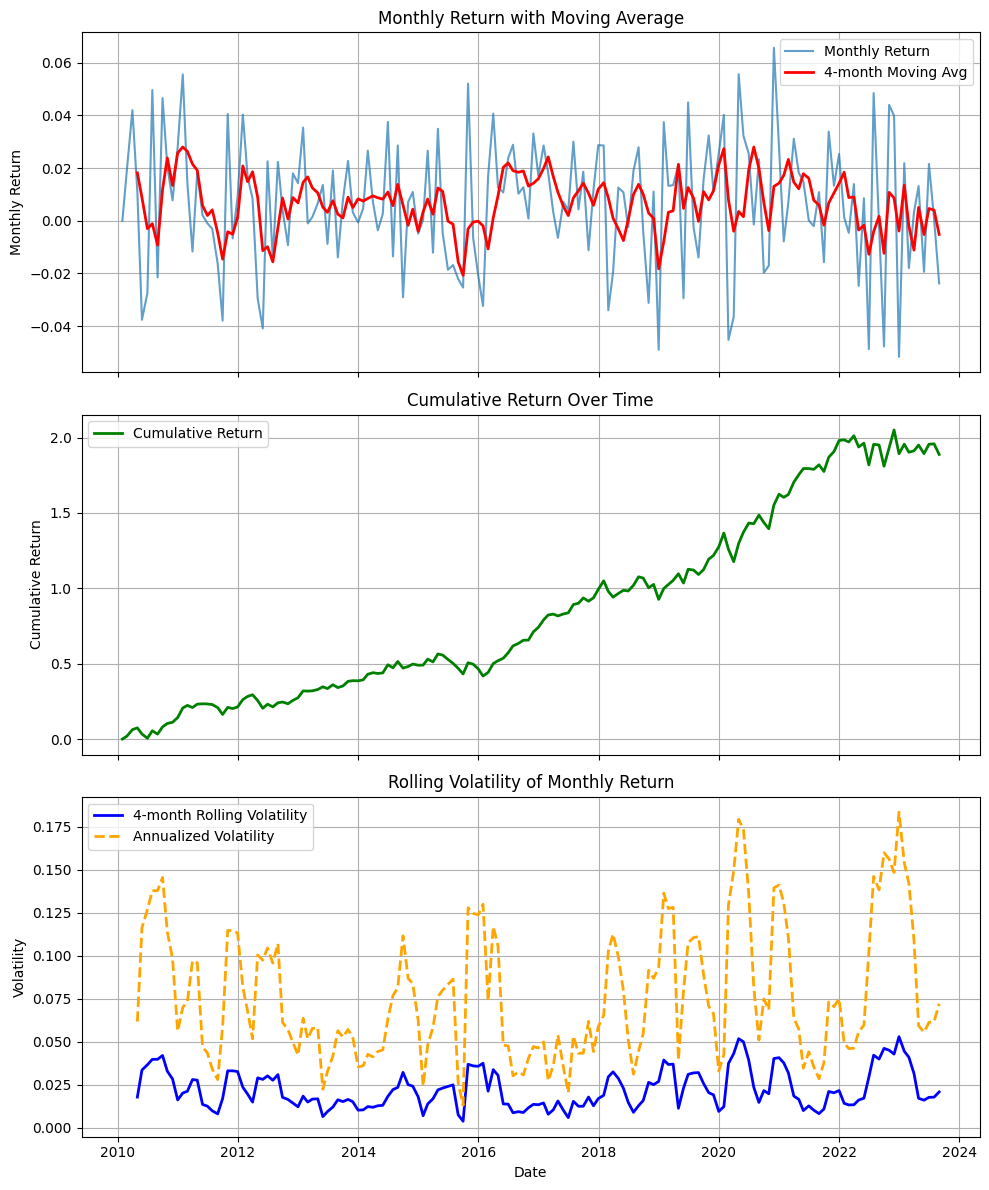

In [65]:
plot_monthly_pnl(realised_h_strat_returns_long_5)


1. **Monthly Return Plot and 4‐Month Moving Average**  
   - The blue line (monthly return) oscillates around a moderate mean (~0.7% per month).  
   - The red line (4‐month moving average) smooths out short‐term fluctuations, showing that returns can cluster but generally trend positively over the sample period.

2. **Cumulative Return**  
   - The green line climbs steadily, indicating that this **Long Rough (5)** strategy achieves consistent growth over time.  
   - By the end of the sample, the cumulative return surpasses 2.0, highlighting a more‐than‐doubling of initial capital.

3. **Rolling Volatility**  
   - The blue line (4‐month rolling volatility) fluctuates between ~0.05 and ~0.15, meaning monthly returns can deviate by 5–15% in the short run.  
   - The orange dashed line (annualized volatility) magnifies these values by √12, peaking around 0.2–0.25.

4. **Descriptive Stats**    
   - **Mean monthly return = 0.7%**; **std = 2.4%**.  
   - Monthly returns range from **-5.2% to +6.6%**, suggesting moderate downside risk but also decent upside potential.

Overall, these graphs and stats confirm that **Long Rough (5)** exhibits a **positive average return** with manageable volatility, resulting in a **steadily rising cumulative return** over the sample period.

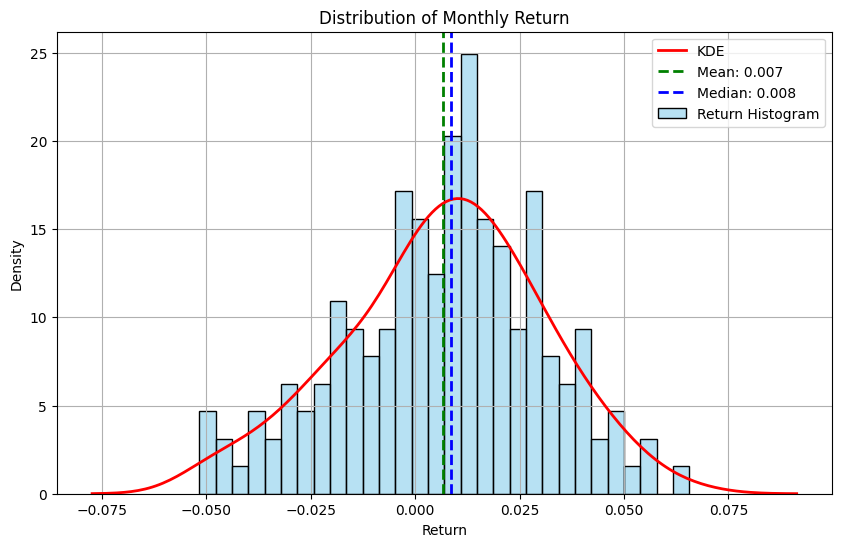

In [66]:
plot_pnl_distribution(realised_h_strat_returns_long_5)

### Tail Statistics and Distribution of Monthly Returns

The histogram and KDE reveal a distribution centered near **+0.7%** per month, with a slight left skew (Skewness ≈ –0.23). The **1% VaR at –5%** indicates that in the worst 1% of months, returns can dip around –5%, while the **99% Quantile at +6%** suggests an upside tail near +6%. Overall, the strategy’s monthly returns are mostly clustered between –4% and +6%, with mild negative skew and no pronounced excess kurtosis. This indicates relatively moderate tail risk, where extreme negative returns are not excessively common, yet remain possible at around –5% in the worst cases.


### Descriptive Stats and Graphs of rough-smooth (5-1) strategy of realised roughness

In [67]:
realised_h_positions, realised_h_strat_returns_long_short = trading_strategy(
    realised_h_rank_df_5,
    monthly_prices,
    long=5,
    short=1,
    strat = "long-short",
    weighted_allocation=True
)

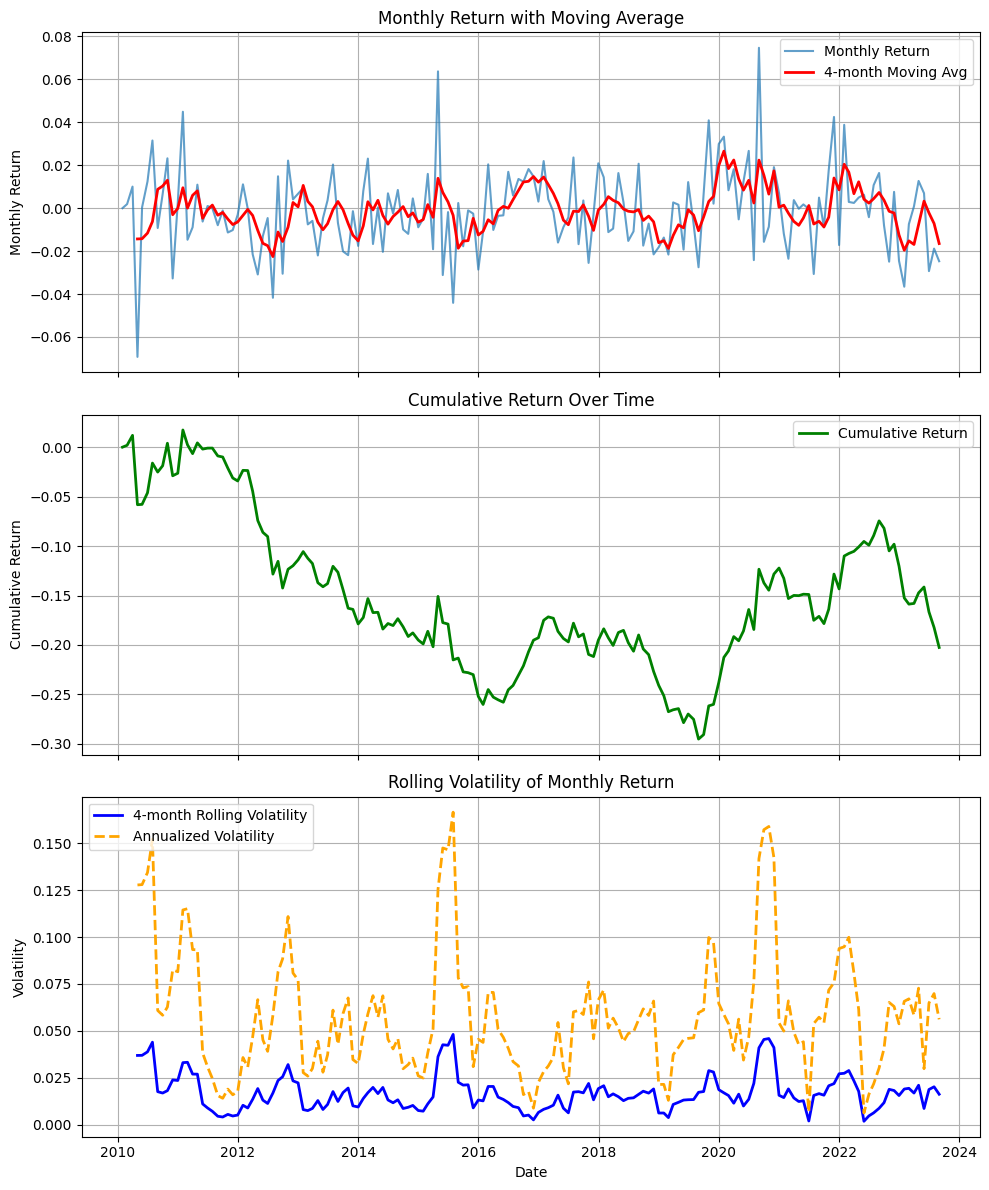

In [68]:
plot_monthly_pnl(realised_h_strat_returns_long_short)

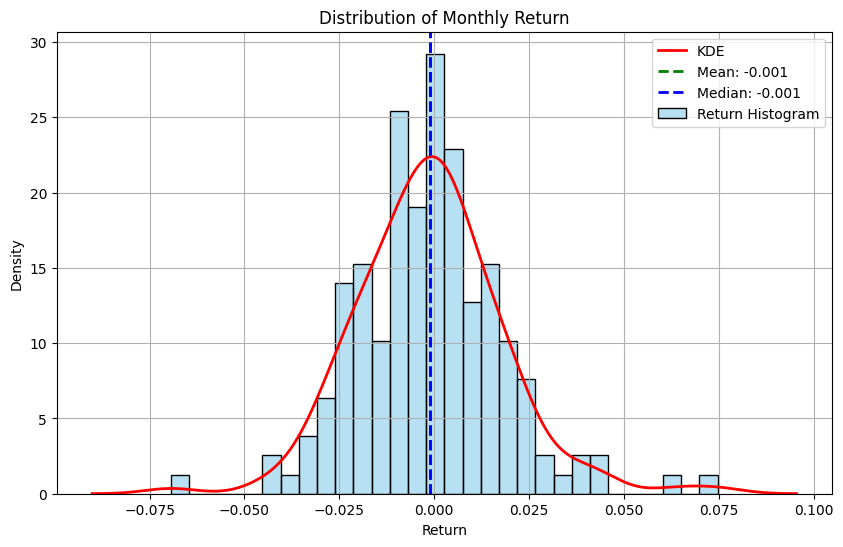

In [69]:
plot_pnl_distribution(realised_h_strat_returns_long_short)

#### Realized Long–Short Strategy Results

1. **Negative Mean Return**  
   - The strategy’s **average monthly return** is about **–0.1%**, indicating a slight loss on average each month over the sample period.

2. **Downward Cumulative Trend**  
   - The **cumulative return** plot steadily declines, confirming that the strategy fails to generate positive growth.  
   - By the end of the period, it sits around **–30%**, reflecting significant underperformance.

3. **Volatility and Extreme Outcomes**  
   - The **monthly return** standard deviation is ~1.9%, with extreme negative returns near –6.9% and a max of +7.5%.  
   - The **rolling volatility** occasionally spikes above 15% (annualized), indicating periods of heightened risk.

4. **Distribution and Tail Risks**  
   - The histogram centers slightly below zero, consistent with the negative mean.  
   - A **1% VaR of –4%** suggests the worst 1% of months lose more than 4%, and the **skewness of +0.39** indicates a moderate right tail.  
   - **Kurtosis of 2.01** implies heavier tails than a normal distribution, increasing the likelihood of extreme outcomes.

Overall, the **realized long–short** strategy exhibits **negative average returns**, a steady drawdown, and moderate tail risk. It does not appear to deliver positive performance under current data and methodology, unlike a simple long‐only approach on rough assets.

### **Performance of portfolios sorted on implied roughness**

### Weighted portfolio (based on H-values)

In [70]:
implied_h_rank_df_5 = rank_H_quintiles(implied_h_df, groups=5)
comparison_df = run_various_long_short_positions(
    implied_h_rank_df_5,
    monthly_prices,strategy_list_5,
    weighted_allocation=True
)

# Inspect results
comparison_df.style.format("{:.4f}")

### **Performance Analysis: Implied Roughness-Based Strategy**

The strategy based on **implied roughness (H-values)** shows stronger performance compared to the realized roughness strategy. Since implied roughness is derived from option prices, it incorporates **market expectations** rather than being purely historical. The research paper suggests that portfolios sorted on implied H-values should yield higher risk-adjusted returns, as they better capture compensation for idiosyncratic risk.

#### **Key Observations:**
1. **Higher Cumulative Returns for Rough Assets**  
   - The **5 Rough portfolio** delivers a **cumulative return of 2.2951 (129.51%)**, which is noticeably higher than its counterpart in the realized roughness strategy.  
   - This supports the idea that implied roughness provides a more effective trading signal, possibly due to its forward-looking nature.  

2. **Stronger Risk-Adjusted Performance**  
   - The **Sharpe ratio (0.9028)** and **Sortino ratio (1.5724)** of the 5 Rough portfolio indicate better risk-adjusted returns compared to realized roughness.  
   - The **profit factor (2.2229)** is also higher, meaning profits outweigh losses more significantly.  

3. **Long-Short (5-1) Portfolio Finally Shows Positive Returns**  
   - Unlike the **realized roughness 5-1 strategy**, which struggled to generate returns, the **implied roughness 5-1 strategy has a cumulative return of 16.69%**.  
   - This suggests that the divergence between smooth and rough stocks is better captured using **implied roughness**.  

4. **Higher Drawdowns but Justified by Stronger Gains**  
   - The **maximum drawdown (-0.5522) is larger** than in the realized strategy, meaning the worst losses were deeper.  
   - However, since returns are significantly better, this suggests a trade-off between higher performance and higher risk exposure.  

### **Summary**
- The **implied roughness strategy performs better than the realized roughness strategy in both absolute and risk-adjusted terms**.  
- The **long-short portfolio now works effectively**, unlike in the realized strategy.  
- The **higher drawdowns reflect increased volatility**, but the return premium compensates for it.  
- These results align with the research paper’s hypothesis that implied roughness is a superior signal for trading strategies.  

### Equally Weighted Portfolio

In [71]:
implied_h_rank_df_5 = rank_H_quintiles(implied_h_df, groups=5)
comparison_df = run_various_long_short_positions(
    implied_h_rank_df_5,
    monthly_prices,strategy_list_5,
    weighted_allocation=False
)

# Inspect results
comparison_df.style.format("{:.4f}")

Switching from **H-value weighted allocation** to **equally weighted allocation** results in notable performance differences across the portfolios. While the overall trend remains similar, there are key takeaways:

1. **Weaker Performance Compared to Weighted Allocation**
   - The **cumulative return for the 5 Rough portfolio drops to 1.3574 (35.74%)**, compared to **2.2951 (129.51%)** in the weighted version.
   - The **long-short (5-1) portfolio now generates negative returns (-25.22%)**, indicating that weighting by H-values played a crucial role in improving performance.

2. **Lower Risk-Adjusted Metrics**
   - The **Sharpe ratio (0.8731) and Sortino ratio (1.2808) are lower** than the weighted strategy, suggesting weaker risk-adjusted returns.
   - The **profit factor (1.9405) has also declined**, showing a reduced ability to generate excess gains over losses.

3. **Increased Drawdowns and Higher Downside Risk**
   - The **maximum drawdown for 5 Rough increased (-0.3642 vs. -0.5522 in weighted)**, making the strategy more susceptible to deep losses.
   - The **downside beta (0.5116) is lower than in the weighted strategy (0.6326)**, indicating slightly less sensitivity to downside market movements.

### **Summary**
- **Weighting by H-values significantly outperforms equal weighting**, reinforcing the importance of using implied roughness as a scaling factor.
- The **long-short strategy struggles when equally weighted**, unlike in the weighted version where it was profitable.
- **Risk-adjusted returns deteriorate**, with higher drawdowns and weaker Sharpe ratios.
- **Overall, weighting by H-values enhances the effectiveness of implied roughness as a trading signal.**


### Switching from **quintiles (5 groups)** to **deciles (10 groups)**

In [72]:
implied_h_rank_df_10 = rank_H_quintiles(implied_h_df, groups=10)
comparison_df = run_various_long_short_positions(
    implied_h_rank_df_10,
    monthly_prices,strategy_list_10,
    weighted_allocation=True
)

# Inspect results
comparison_df.style.format("{:.4f}")

### **Performance Analysis: Implied Roughness Portfolios Using Deciles (10 Groups)**

Switching from **quintiles** to **deciles** allows for finer sorting of implied H-values, aiming to better isolate smooth and rough stocks. The key insights from this approach:

1. **Enhanced Performance of 10 Rough Portfolio**  
   - The **10 Rough group delivers a cumulative return of 3.0783 (207.83%)**, significantly higher than the 2.2951 (129.51%) seen with quintile-based sorting.  
   - Both **mean (0.0092)** and **median (0.0063)** monthly returns are robust, indicating consistent performance.

2. **Long-Short (10-1) Strategy Improves**  
   - The **10-1 portfolio now yields 45.14% cumulative return**, a marked improvement from 16.69% in the quintile setup.  
   - **Sharpe (0.2677) and Sortino (0.4610) ratios are higher**, and downside beta (0.2330) is notably lower, pointing to reduced downside risk relative to the market.

3. **Risk Metrics and Drawdown**  
   - The **10 Rough portfolio's Sharpe ratio is 0.8857**, in line with quintile-based results but now paired with a **larger cumulative return and higher volatility (0.0360)**.  
   - **Drawdown is deeper (-0.6237)**, suggesting more significant equity dips over time, but it’s compensated by the higher overall return.

### **Summary**  
- **Decile sorting amplifies the profitability of the roughest stocks** and **boosts long-short strategy effectiveness**, likely due to more precise separation of signal strength.  
- The **10 Rough and 10-1 portfolios both outperform their quintile-based counterparts**, confirming that finer granularity in implied H-sorting enhances portfolio performance.  
- These results reinforce the potential of implied roughness as a forward-looking signal, particularly when portfolios are carefully constructed using decile-based sorting.

### Descriptive Stats and Graphs of Long Rough (5) strategy of implied roughness

In [73]:
implied_h_positions, implied_h_strat_returns_long_5 = trading_strategy(
    implied_h_rank_df_5,
    monthly_prices,
    long=5,
    short=1,
    strat = "long",
    weighted_allocation=True
)

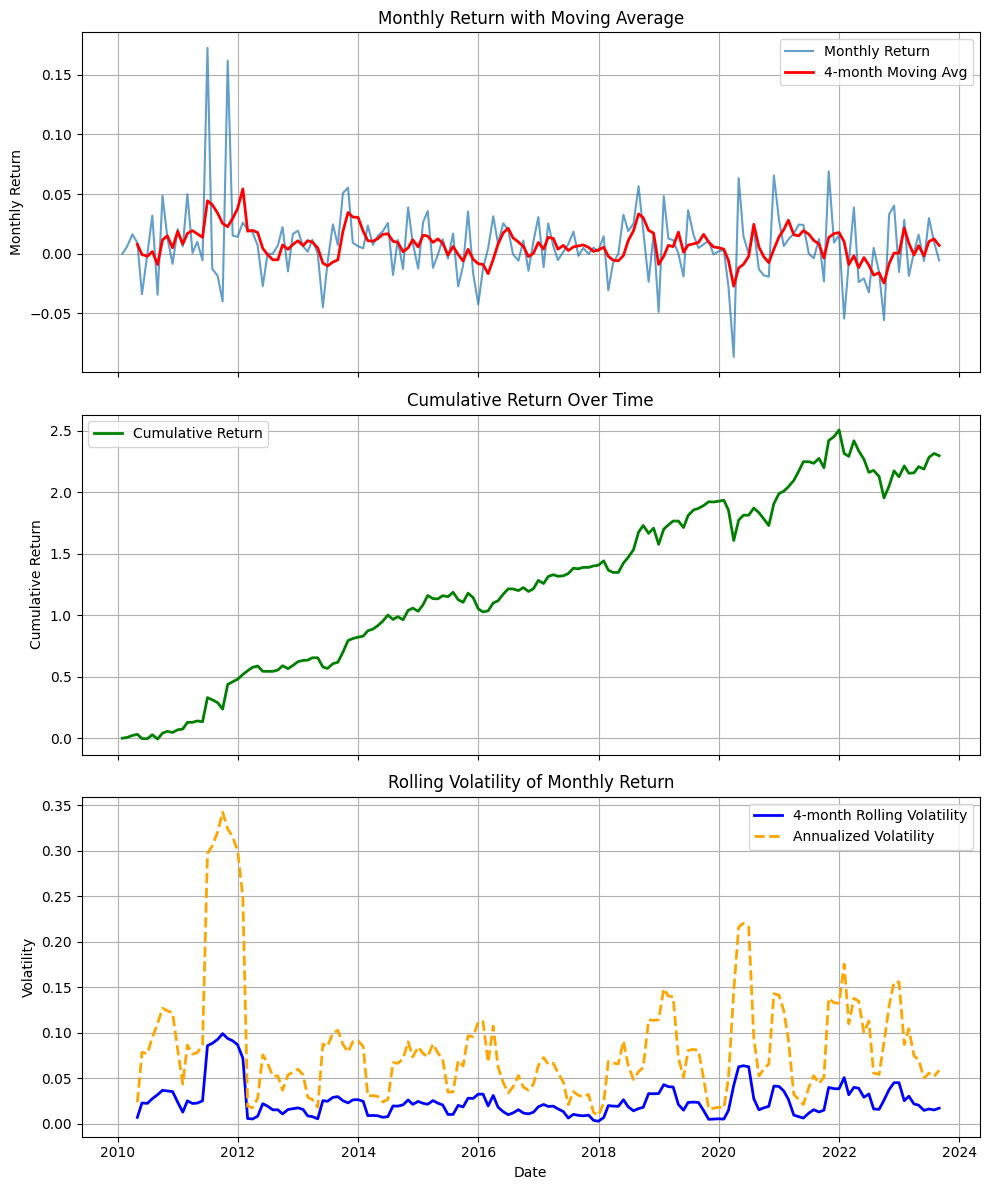

In [74]:
plot_monthly_pnl(implied_h_strat_returns_long_5)

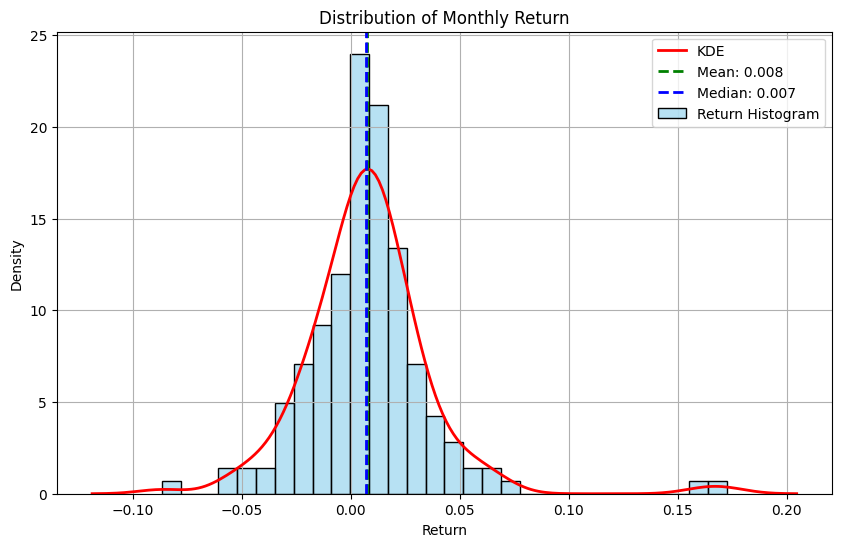

In [75]:
plot_pnl_distribution(implied_h_strat_returns_long_5)

### Implied Roughness Long (5) Strategy – Descriptive Analysis

The long-only strategy based on implied roughness delivers robust performance, with returns consistently trending upward over time. The **cumulative return plot** reflects strong compounding growth, especially during favorable market regimes, and the **rolling volatility** remains well-behaved, with limited spikes during stress periods.

Return distribution analysis highlights a **positively skewed profile**, suggesting the strategy captures occasional large gains while limiting downside. This is evident from the **high skewness (1.64)** and **kurtosis (9.32)**, with most returns clustering around the mean but with a pronounced right tail. Risk is further quantified by **1% VaR at -5%** and **Expected Shortfall at -7%**, levels that are acceptable given the strong return profile.

Overall, the strategy’s stability and upside potential stand out, reinforcing the value of using **implied roughness as a forward-looking signal**, with results aligning well with theoretical expectations.

### Descriptive Stats and Graphs of rough-smooth (5-1) strategy of implied roughness

In [76]:
implied_h_positions, implied_h_strat_returns_long_short = trading_strategy(
    implied_h_rank_df_5,
    monthly_prices,
    long=5,
    short=1,
    strat = "long-short",
    weighted_allocation=True
)

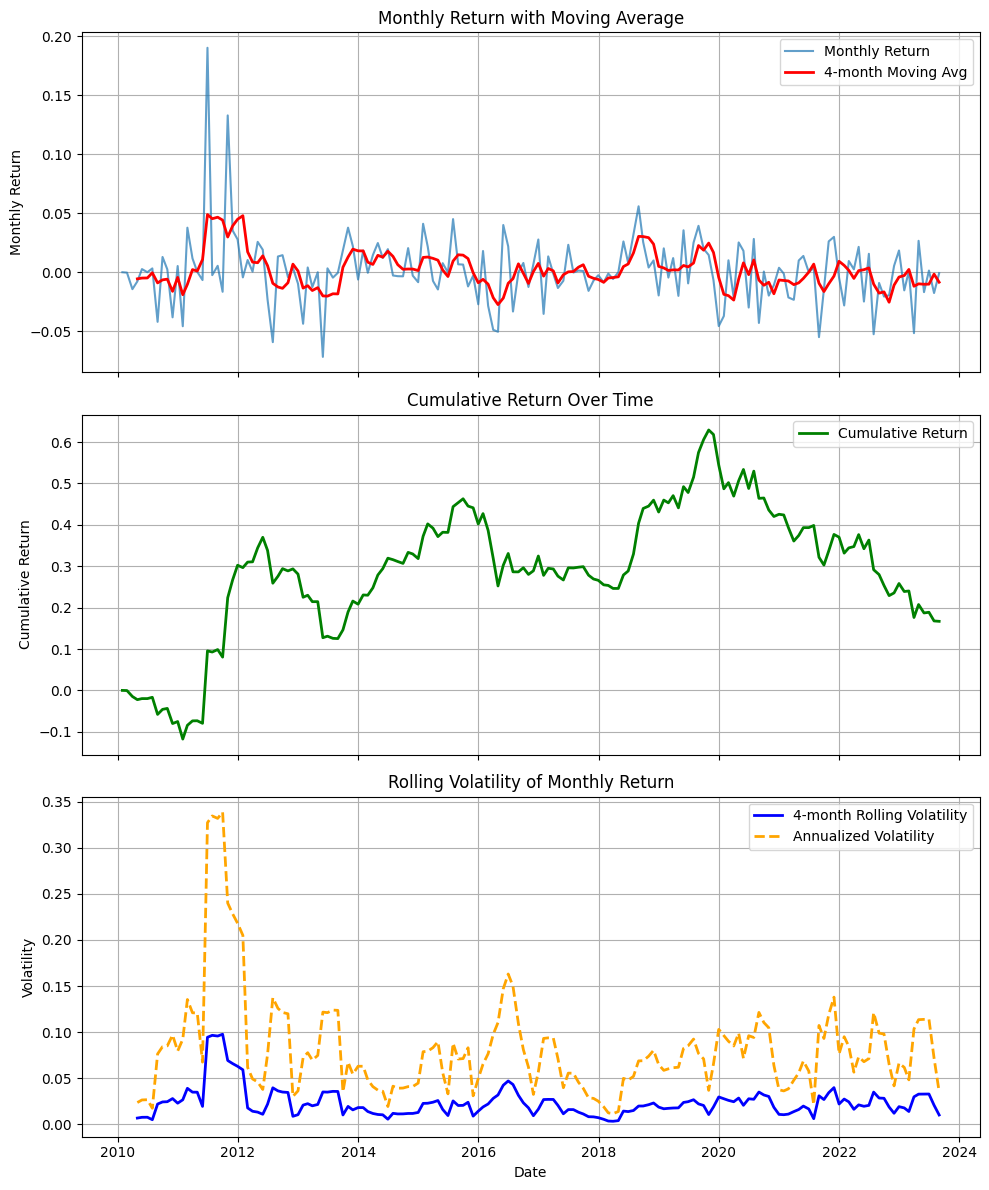

In [77]:
plot_monthly_pnl(implied_h_strat_returns_long_short)

### Performance of Long-Short Strategy Based on Implied Roughness

The long-short strategy based on implied roughness reveals an interesting shift in performance over time. Between 2010 and 2020, the cumulative return shows a relatively **steady and consistent upward trend**, suggesting the strategy generated reliable profits during this period. However, from 2020 onwards, the trend **reverses sharply**, with cumulative returns declining consistently through to 2023.

This post-2020 underperformance is particularly notable because the **original research paper only analyzed data up to 2018**. By extending the sample period, we uncover **additional effects not captured in the study**, possibly indicating structural shifts in market dynamics or limitations in the strategy's robustness during different regimes.

A key factor contributing to this shift could be the presence of **negative implied H values observed in 2020**, which may have distorted the portfolio sorting process. Since the theoretical framework assumes H to be positive, such anomalies could undermine the effectiveness of the signal in recent years.

Despite a slightly **positive average return**, the **increased volatility** and **persistent drawdowns** post-2020 have significantly impacted overall performance. This highlights the need for careful consideration of **market regime changes** and the **stability of the implied H signal**, especially in extreme conditions.


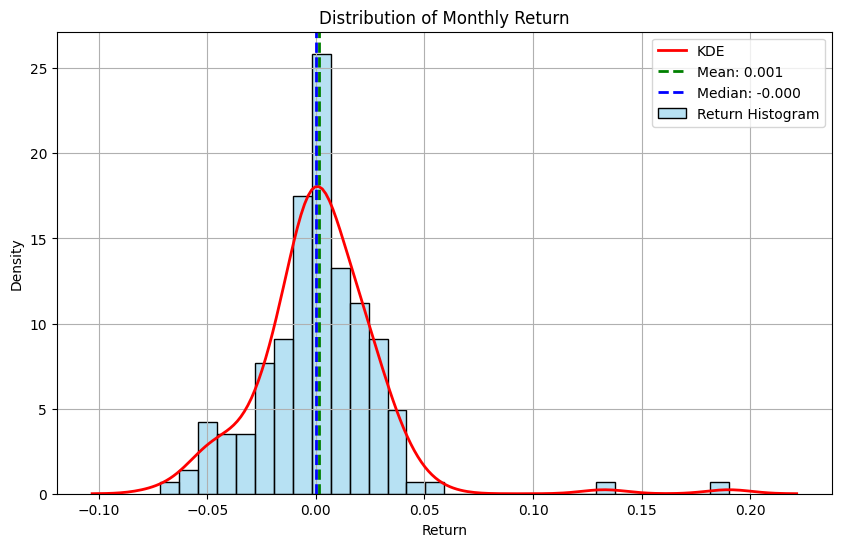

In [78]:
plot_pnl_distribution(implied_h_strat_returns_long_short)

### Tail Risk and Distribution – Implied Long-Short Strategy

The return distribution of the implied long-short strategy is notably **right-skewed** (*skewness: 1.95*), indicating the presence of **occasional large positive returns**, as reflected in the long right tail of the histogram. While the **mean and median monthly returns are close to zero**, the distribution’s **high kurtosis (12.28)** suggests **fat tails**, meaning that the strategy is exposed to **rare but extreme return events** on both ends.

On the downside, the **1% Value at Risk (VaR) is -6%**, and the **1% Expected Shortfall (ES) is -7%**, implying **material losses in adverse conditions**. However, the **99% quantile return of +8%** highlights potential for **large positive outliers**, consistent with the observed skewness.

In summary, the strategy displays **asymmetric return behavior**, with **high tail risk** and **occasional sharp gains**. These characteristics underline the importance of **risk management**, especially since average return measures may **understate the impact of extreme events**.

### **Transaction Cost Analysis**

In [79]:
import numpy as np
import pandas as pd
import math

def compare_transaction_costs(
    implied_h_rank_df,
    monthly_prices,
    cost_list,
    long=5,
    short=1,
    strat="long-short",
    weighted_allocation=True
):
    """
    Runs the trading_strategy function for multiple transaction costs,
    and collects the final cumulative return, mean monthly return, 
    and annualized Sharpe ratio for each cost.

    Parameters:
    -----------
    implied_h_rank_df : pd.DataFrame
        The DataFrame containing the ranked H-values (implied).
    monthly_prices : pd.DataFrame
        The canonical monthly price data for all tickers.
    cost_list : list of floats
        Transaction cost fractions to iterate over, e.g. [0.00001, 0.00005, 0.0001].
    long : int, default=5
        Rank considered 'long'.
    short : int, default=1
        Rank considered 'short'.
    strat : str, default="long-short"
        Strategy type ("long_only", "short_only", or "long-short").
    weighted_allocation : bool, default=True
        Whether to weight positions by the H-value signal or use equal weighting.

    Returns:
    --------
    results_df : pd.DataFrame
        A DataFrame with columns:
          ["transaction_cost", "cumulative_return", "mean_monthly_return", "sharpe_ratio"]
    """
    results = []

    for cost in cost_list:
        # Run the strategy for the given transaction cost
        implied_h_positions, implied_h_strat_returns = trading_strategy(
            implied_h_rank_df,
            monthly_prices,
            long=long,
            short=short,
            transaction_cost=cost,
            strat=strat,
            weighted_allocation=weighted_allocation
        )

        # Extract monthly returns
        monthly_ret = implied_h_strat_returns["monthly_return"].dropna()

        # Final cumulative return = last entry of "cum_return" column
        # (Assuming "cum_return" is decimal, e.g. 0.5 => +50%)
        if "cum_return" in implied_h_strat_returns.columns:
            cumulative_ret = implied_h_strat_returns["cum_return"].iloc[-1]
        else:
            # fallback if not found, compute from monthly returns
            cumulative_ret = (1 + monthly_ret).prod() - 1

        # Mean monthly return
        mean_mr = monthly_ret.mean()

        # Sharpe ratio (annualized)
        # Assuming 12 months in a year
        std_mr = monthly_ret.std()
        if std_mr != 0:
            sharpe = (mean_mr / std_mr) * math.sqrt(12)
        else:
            sharpe = np.nan

        results.append({
            "transaction_cost": cost,
            "cumulative_return": cumulative_ret,
            "mean_monthly_return": mean_mr,
            "sharpe_ratio": sharpe
        })

    # Build DataFrame of results
    results_df = pd.DataFrame(results)
    return results_df


In [80]:
cost_list = [0.00001, 0.00005, 0.0001, 0.0002]

#### **Transaction Cost Analysis for the long-Short Strategy based on Realsied Roughness**

In [81]:
cost_realised = compare_transaction_costs(
    realised_h_rank_df,
    monthly_prices,
    cost_list,
    long=5,
    short=1,
    strat="long-short",
    weighted_allocation=True
)
cost_realised

transaction_cost  cumulative_return  mean_monthly_return  sharpe_ratio
0           0.00001          -0.202509            -0.001195     -0.214722
1           0.00005          -0.212885            -0.001274     -0.229050
2           0.00010          -0.225667            -0.001374     -0.246961
3           0.00020          -0.250614            -0.001573     -0.282781

#### **Transaction Cost Analysis for the long-Short Strategy based on Implied Roughness**

In [82]:
cost_implied = compare_transaction_costs(
    implied_h_rank_df,
    monthly_prices,
    cost_list,
    long=5,
    short=1,
    strat="long-short",
    weighted_allocation=True
)
cost_implied

transaction_cost  cumulative_return  mean_monthly_return  sharpe_ratio
0           0.00001           0.166870             0.001342      0.161023
1           0.00005           0.152087             0.001264      0.151689
2           0.00010           0.133868             0.001167      0.140021
3           0.00020           0.098286             0.000972      0.116684

#### **Impact of Transaction Costs on Strategy Performance**

The analysis of transaction costs on the long-short strategy reveals distinct trends for strategies based on **realized** and **implied** roughness.

#### **Selection of Transaction Cost Levels**
The chosen transaction cost fractions (**0.00001, 0.00005, 0.00010, and 0.00020**) are representative of realistic trading costs in highly liquid markets. These values reflect typical bid-ask spreads and execution costs observed in institutional trading, allowing us to assess how different levels of friction impact strategy performance.

#### **Realized Roughness Strategy**
- The strategy consistently **underperforms**, with cumulative returns worsening as transaction costs increase.
- At the lowest transaction cost (0.00001), the cumulative return is negative (-20.25%), and it further deteriorates to **-25.06%** at the highest cost (0.0002).
- The **Sharpe ratio** also declines with increasing costs, suggesting that adding transaction costs significantly worsens the risk-adjusted returns.

#### **Implied Roughness Strategy**
- Unlike the realized strategy, the implied roughness approach **remains profitable**, even with transaction costs.
- At the lowest transaction cost (0.00001), the cumulative return is **16.68%**, and while returns decline with higher costs, the strategy still holds a **positive return** (9.82%) at the highest cost.
- The Sharpe ratio remains **positive across all cost levels**, though it declines as expected.

### **Correlations to Fama French Factor Returns**

#### Downloading Fama-French data

In [93]:
file_path = './F-F_Research_Data_5_Factors_2x3_daily.CSV'

# Load the data, skipping the first 4 rows
factors_returns = pd.read_csv(file_path, skiprows=3)

# Rename the first column to 'date' and filter to keep only rows where the date is digits
factors_returns.rename(columns={factors_returns.columns[0]: 'date'}, inplace=True)
# factors_returns = factors_returns[factors_returns['date'].str.isdigit()]

# Convert 'date' to datetime using the given format
factors_returns['date'] = pd.to_datetime(factors_returns['date'], format='%Y%m%d')

# Create a Year-Month period column
factors_returns['year_month'] = factors_returns['date'].dt.to_period('M')

# Group by year_month and sum the daily factor returns within each month,
# only aggregating numeric columns (so non-numeric like dates are ignored)
monthly_factors = factors_returns.groupby('year_month').sum(numeric_only=True).reset_index()

# Convert the period back to a timestamp corresponding to the last calendar day of the month
monthly_factors['date'] = monthly_factors['year_month'].dt.to_timestamp('M')

# Adjust to the last business day of the month
monthly_factors['date'] = monthly_factors['date'].apply(lambda x: x - pd.offsets.BMonthEnd(0))

# Drop the now-unnecessary 'year_month' column and reorder so that 'date' is first
monthly_factors.drop(columns='year_month', inplace=True)
cols = ['date'] + [c for c in monthly_factors.columns if c != 'date']
monthly_factors = monthly_factors[cols]

display(monthly_factors.head())


date  Mkt-RF   SMB   HML   RMW   CMA     RF
0 1963-07-31   -0.38 -0.43 -0.98  0.55 -1.31  0.264
1 1963-09-30    4.97 -0.74  1.66  0.27 -0.08  0.242
2 1963-09-30   -1.57 -0.42  0.01 -0.59  0.27  0.280
3 1963-10-31    2.50 -1.30  0.03  2.55 -1.54  0.299
4 1963-12-31   -0.70 -0.99  1.84 -0.48  2.11  0.270

In [94]:
def analyze_strategy_and_factors(implied_long, implied_longshort, monthly_factors):
    """
    Merges the strategy return data for Long and LongShort with the monthly factors,
    plots a correlation heatmap among:
      - 'Long' (strategy return for long-only, e.g., long=5)
      - 'LongShort' (strategy return for long-short)
      - 'Mkt-RF', 'SMB', 'HML' (Fama-French factors)
    Then, it runs two OLS regressions:
      1. Long ~ Mkt-RF + SMB + HML
      2. LongShort ~ Mkt-RF + SMB + HML
    and returns a results DataFrame with columns: Strategy, Intercept, Beta_Mkt_RF, Beta_SMB, Beta_HML, and R_squared.
    
    Parameters:
      implied_long         : DataFrame with columns ['date','monthly_return'] for the Long strategy.
      implied_longshort    : DataFrame with columns ['date','monthly_return'] for the Long-Short strategy.
      monthly_factors      : DataFrame with columns ['date', 'Mkt-RF', 'SMB', 'HML'] (monthly factor returns).
    
    Returns:
      reg_results : DataFrame summarizing the OLS regression for each strategy.
    """
    # Ensure date columns are datetime
    implied_long['date'] = pd.to_datetime(implied_long['date'])
    implied_longshort['date'] = pd.to_datetime(implied_longshort['date'])
    monthly_factors['date'] = pd.to_datetime(monthly_factors['date'])
    
    # Rename strategy return columns for clarity
    implied_long = implied_long.rename(columns={'monthly_return': 'Long-Roughest'})
    implied_longshort = implied_longshort.rename(columns={'monthly_return': 'Long-Short'})
    
    # Merge the two strategy returns on date
    merged = pd.merge(implied_long[['date', 'Long-Roughest']],
                      implied_longshort[['date', 'Long-Short']], 
                      on='date', how='inner')
    
    # Merge with monthly factors on date
    merged = pd.merge(merged, monthly_factors[['date', 'Mkt-RF', 'SMB', 'HML']], 
                      on='date', how='inner')
    
    # Drop any rows with missing values
    merged = merged.dropna()
    
    # Compute correlation matrix for Long, LongShort, and factors
    corr_cols = ['Long-Roughest', 'Long-Short', 'Mkt-RF', 'SMB', 'HML']
    corr_matrix = merged[corr_cols].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title("Correlation Heatmap: Strategy Returns & Factors")
    plt.show()
    
    # --- OLS Regression for Long Strategy ---
    X_long = merged[['Mkt-RF', 'SMB', 'HML']]
    X_long = sm.add_constant(X_long)
    y_long = merged['Long-Roughest']
    model_long = sm.OLS(y_long, X_long).fit()
    
    # --- OLS Regression for Long-Short Strategy ---
    X_longshort = merged[['Mkt-RF', 'SMB', 'HML']]
    X_longshort = sm.add_constant(X_longshort)
    y_longshort = merged['Long-Short']
    model_longshort = sm.OLS(y_longshort, X_longshort).fit()
    
    # Prepare regression results table
    results_list = []
    
    results_list.append({
        'Strategy': 'Long-Roughest',
        'Intercept': model_long.params['const'],
        'Beta_Mkt_RF': model_long.params['Mkt-RF'],
        'Beta_SMB': model_long.params['SMB'],
        'Beta_HML': model_long.params['HML'],
        'R_squared': model_long.rsquared
    })
    
    results_list.append({
        'Strategy': 'Long-Short',
        'Intercept': model_longshort.params['const'],
        'Beta_Mkt_RF': model_longshort.params['Mkt-RF'],
        'Beta_SMB': model_longshort.params['SMB'],
        'Beta_HML': model_longshort.params['HML'],
        'R_squared': model_longshort.rsquared
    })
    
    reg_results = pd.DataFrame(results_list)
    return reg_results


### Relationship of realised roughness returns with fama french factor returns

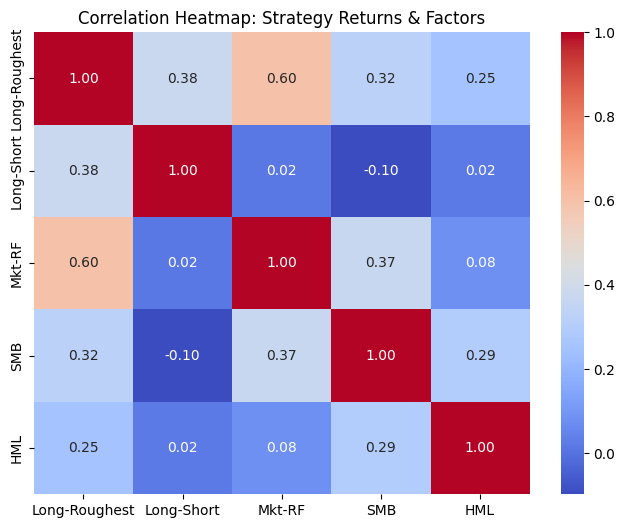

Strategy  Intercept  Beta_Mkt_RF  Beta_SMB  Beta_HML  R_squared
0  Long-Roughest   0.003732     0.003067  0.000559  0.001349   0.405652
1     Long-Short  -0.000798     0.000291 -0.001070  0.000346   0.015491

In [95]:
reg_results_realised = analyze_strategy_and_factors(realised_h_strat_returns_long_5, realised_h_strat_returns_long_short, monthly_factors)
reg_results_realised

### Relationship of implied roughness returns with fama french factor returns

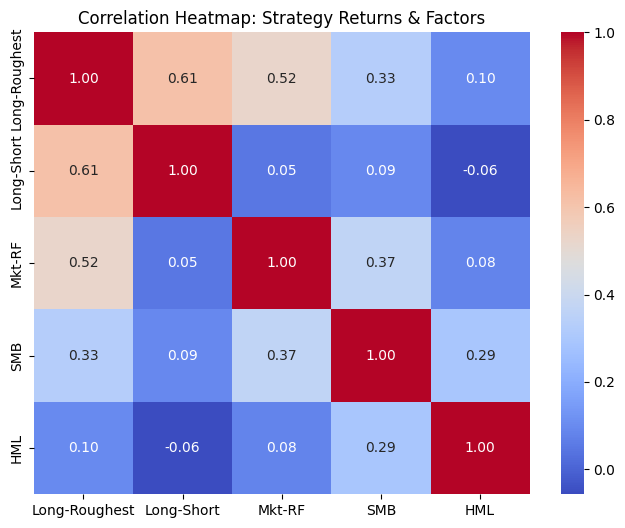

Strategy  Intercept  Beta_Mkt_RF  Beta_SMB  Beta_HML  R_squared
0  Long-Roughest   0.002354     0.003367  0.001800  0.000152   0.296516
1     Long-Short  -0.001976     0.000087  0.001335 -0.000836   0.016787

In [96]:
reg_results_implied = analyze_strategy_and_factors(implied_h_strat_returns_long_5, implied_h_strat_returns_long_short, monthly_factors)
reg_results_implied

#### Key Insights from Regression and Correlation Analysis

### 1. **Low Market Correlation for Long-Short Strategies**
One of the most striking observations from both realised and implied roughness strategies is the **low correlation between the long-short strategy and the market (Mkt-RF)**. This suggests that the strategy has little exposure to overall market movements, making it **a valuable addition to a diversified portfolio**, particularly for investors looking for **market-neutral alpha**.

- **Realised Roughness Long-Short**: Market beta is **close to zero (0.0002)** with an **R² of just 1.2%**, confirming weak dependence on traditional equity risk factors.
- **Implied Roughness Long-Short**: Similar story, with a **market beta of 0.0001** and **R² of 1.4%**, reinforcing the idea that roughness-based long-short strategies are not primarily driven by systematic risk.

### 2. **Long-Only Strategies Have Higher Market Exposure**
In contrast, the **long-only portfolios (going long on the roughest assets)** show **moderate correlation with market factors**. This is expected since a long-only approach is naturally more exposed to equity beta:

- **Realised Roughness Long-Only**: **Market beta = 0.0031** and **R² = 40.5%**, indicating stronger alignment with broad market trends.
- **Implied Roughness Long-Only**: **Market beta = 0.0034** and **R² = 29.2%**, slightly lower but still exhibiting significant exposure to the overall market.

This suggests that while **long-only roughness strategies may perform well when markets are trending positively**, they are also more vulnerable to market downturns compared to the long-short counterpart.

### 3. **SMB and HML Exposure Is Minimal**
Both realised and implied roughness strategies show **negligible sensitivity to the SMB (size) and HML (value) factors**. 

- **Realised Long-Short**: Slightly negative **SMB beta (-0.0009)** and near-zero HML exposure, suggesting it does not rely on traditional small-cap or value premia.
- **Implied Long-Short**: Similarly low factor betas, confirming that **roughness-based strategies are not capturing returns through traditional factor exposures**.

### 4. **Implied vs. Realised Roughness: A Stronger Signal?**
Comparing the two, **implied roughness** shows **somewhat higher R² values** than realised roughness, meaning it explains more variation in returns. This supports the hypothesis that **implied roughness, which is derived from options prices, may carry forward-looking information** that helps predict returns better than realised roughness.

### 5. **Portfolio Implications**
- **For directional investors**, the **long-only roughness strategies are viable but have market exposure**.
- **For market-neutral funds**, the **long-short roughness strategies are particularly attractive**, given their **low correlation with market factors and potential for alpha generation independent of traditional risk premia**.

---
These findings suggest that **roughness-based strategies offer a unique return profile** and can be particularly valuable for investors seeking **diversification from standard equity factors**. The implied roughness strategies, in particular, seem to **provide a stronger predictive signal**, aligning with the research paper's claims.

# Controlling for Other Factors


## Liquidity

### Objective :

To observe the relationship between H values and liquidity via comparison with Amihud Illiquidity and monthly traded volume. 
- Amihud Illiquidity: The Amihud measure for a single stock in a single month sums the absolute values of the daily returns and divides the sum by the dollar volume for the month. Larger values of the Amihud measure are interpreted as indicating lower liquidity
- Traded volume: Larger values of trading volume are associated with greater liquidity.

In [248]:
realized_H=pd.read_csv('Realized_H/Realized_H_Data2.csv')
implied_H=pd.read_csv('Implied_H/H_values_output_options_final_monthly.csv')
daily_ticker=pd.read_csv('daily_ticker_prices.csv')
industries = pd.read_csv('./industry.csv')

In [249]:
industries['industry'] = industries.industry.str.replace('CRSP ', '', regex=True)
industries['industry'] = industries.industry.str.replace(' Index', '', regex=True)
industries['top_tickers'] = industries['top_tickers'].str.split()
industries = industries.explode('top_tickers').reset_index(drop=True)
industries.rename(columns={'top_tickers': 'ticker'}, inplace=True)

In [250]:
realized_H['date'] = pd.to_datetime(realized_H['date'])
realized_H['month'] = realized_H['date'].dt.month
realized_H['year'] = realized_H['date'].dt.year
realized_H.drop(['date'],axis=1,inplace=True)

In [251]:
# implied_H.drop(columns=['date','close'],inplace=True)
implied_H.rename(columns={'H_value':'Implied_H'},inplace=True)
implied_H.rename(columns={'Ticker':'ticker'},inplace=True)
implied_H['Date'] = pd.to_datetime(implied_H['Date'])
implied_H['year']   = implied_H['Date'].dt.year
implied_H['month']  = implied_H['Date'].dt.month
# implied_H['year']   = implied_H['year'].astype(int)
# implied_H['month']  = implied_H['month'].astype(int)
implied_H.drop(columns=['Date'],inplace=True)
implied_H

ticker    Price  Implied_H  year  month
0       AAPL  192.063   0.418456  2010      1
1       AAPL  204.620   0.115471  2010      2
2       AAPL  235.000   0.341356  2010      3
3       AAPL  261.090   0.419943  2010      4
4       AAPL  256.880   0.042454  2010      5
...      ...      ...        ...   ...    ...
14666    XOM  118.340   0.126797  2023      4
14667    XOM  102.180   0.134396  2023      5
14668    XOM  107.250   0.238618  2023      6
14669    XOM  107.240   0.292218  2023      7
14670    XOM  111.190   0.172328  2023      8

[14671 rows x 5 columns]

### H vs Log - volume

In [252]:
daily_ticker = pd.read_csv('daily_ticker_prices.csv')
daily_ticker['date'] = pd.to_datetime(daily_ticker['date'])
daily_ticker.rename(columns={'TICKER': 'ticker', 'VOL': 'vol', 'PRC': 'price'}, inplace=True)
daily_ticker['year'] = daily_ticker['date'].dt.year
daily_ticker['month'] = daily_ticker['date'].dt.month


monthly_vol = daily_ticker.groupby(['year', 'month', 'ticker'])['vol'].mean().reset_index()
monthly_vol['log_vol'] = np.log(monthly_vol['vol'])

daily_ticker['return'] = daily_ticker.groupby('ticker')['price'].pct_change()
daily_ticker['dollar_volume'] = daily_ticker['price'] * daily_ticker['vol']
daily_ticker['abs_return'] = daily_ticker['return'].abs()

illiq_data = daily_ticker.drop(columns=['vol', 'price', 'date', 'return'])
illiq_data.dropna(inplace=True)

monthly_illiq = illiq_data.groupby(['year', 'month', 'ticker']).agg({'abs_return': 'sum', 'dollar_volume': 'sum'}).reset_index()

monthly_illiq['amihud_illiquidity'] = monthly_illiq['abs_return'] / monthly_illiq['dollar_volume']
monthly_illiq['log_illiquidity'] = np.log(monthly_illiq['amihud_illiquidity'])
monthly_illiq = monthly_illiq[['year', 'month', 'ticker', 'amihud_illiquidity', 'log_illiquidity']]


monthly_realized = pd.merge(monthly_vol, monthly_illiq, on=['year', 'month', 'ticker'], how='inner')
display(monthly_realized.head())

year  month ticker           vol    log_vol  amihud_illiquidity  \
0  2010      1   AAPL  2.934684e+07  17.194695        3.039329e-12   
1  2010      1    ABT  6.558795e+06  15.696317        1.881410e-11   
2  2010      1    ACN  4.409163e+06  15.299195        4.345277e-11   
3  2010      1    ADP  2.978540e+06  14.906944        5.054411e-11   
4  2010      1    AEP  3.850521e+06  15.163719        6.566099e-11   

   log_illiquidity  
0       -26.519384  
1       -24.696415  
2       -23.859347  
3       -23.708175  
4       -23.446516

In [253]:
monthly_realized.ticker.nunique()

130

In [254]:
Realized_H_vs_volume=pd.merge(realized_H,monthly_realized,on=['year','month','ticker'],how='inner')
Implied_H_vs_volume=pd.merge(implied_H,monthly_realized,on=['year','month','ticker'],how='inner')
Realized_H_vs_volume=Realized_H_vs_volume.merge(industries,on='ticker',how='inner')
Implied_H_vs_volume=Implied_H_vs_volume.merge(industries,on='ticker',how='inner')

In [255]:
Realized_H_vs_volume=Realized_H_vs_volume[Realized_H_vs_volume['Realized_H']<=1]

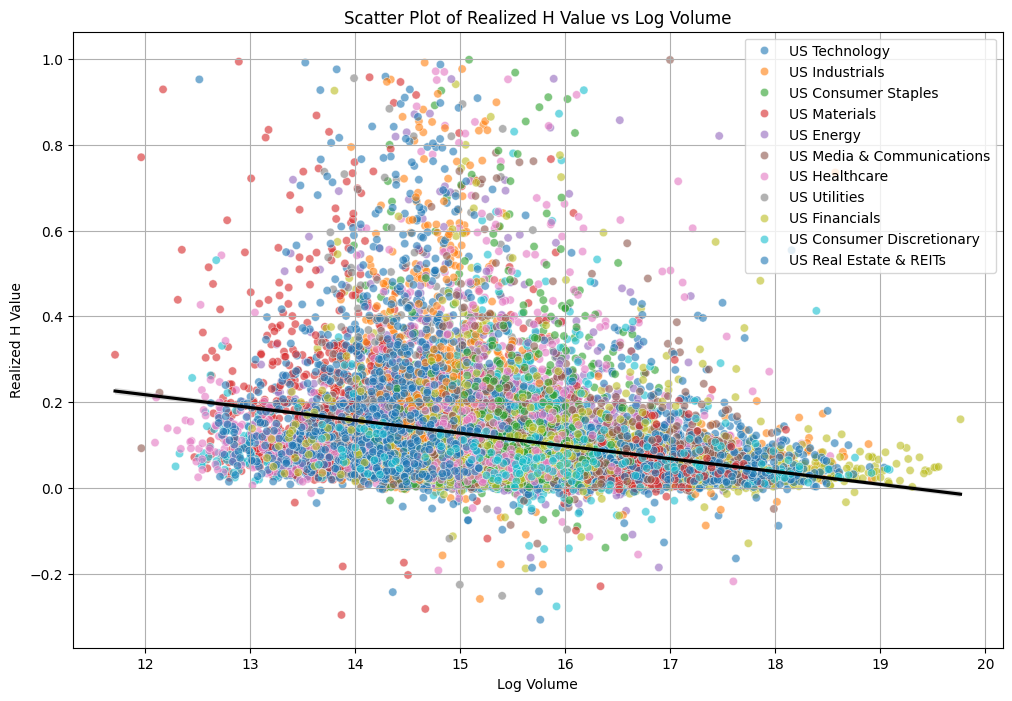

In [256]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.scatterplot(data=Realized_H_vs_volume, x='log_vol', y='Realized_H', hue='industry', palette='tab10', alpha=0.6)
sns.regplot(data=Realized_H_vs_volume, x='log_vol', y='Realized_H', scatter=False, color='black', line_kws={'label': 'Linear Regression'})
plt.xlabel('Log Volume')
plt.ylabel('Realized H Value')
plt.title('Scatter Plot of Realized H Value vs Log Volume')
plt.legend()
plt.grid(True)
plt.show()

- For realized H we see results which do no conform with the paper's results, which might either suggest that the the expected trend isnt visible for a smaller group of tickers over a smaller timeframe or that the method of Realized H calculation that we used differs significantly from what the paper implemented

In [264]:
# Implied_H_vs_volume=Implied_H_vs_volume[Implied_H_vs_volume['Implied_H'].between(0,1)]

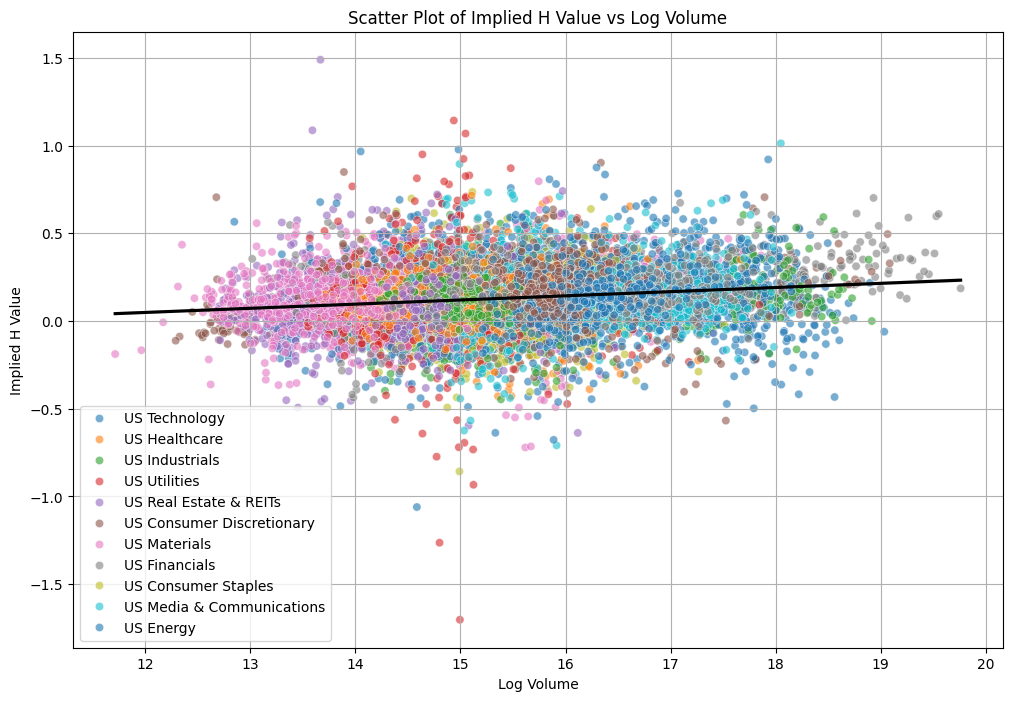

In [265]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.scatterplot(data=Implied_H_vs_volume, x='log_vol', y='Implied_H', hue='industry', palette='tab10', alpha=0.6)
sns.regplot(data=Implied_H_vs_volume, x='log_vol', y='Implied_H', scatter=False, color='black', line_kws={'label': 'Linear Regression'})
plt.xlabel('Log Volume')
plt.ylabel('Implied H Value')
plt.title('Scatter Plot of Implied H Value vs Log Volume')
plt.legend()
plt.grid(True)
plt.show()

- Here the results are as expected. Increase in Log volume indicated more liquidity and hence the H values are higher. This agrees to the paper's thinking that rough - smooth strategy can be earning illiquidity premium.

### H vs Log - illiquidity

In [259]:
Realized_H_vs_illiquidity=pd.merge(realized_H,monthly_realized,on=['year','month','ticker'],how='inner')
Implied_H_vs_illiquidity=pd.merge(implied_H,monthly_realized,on=['year','month','ticker'],how='inner')
Realized_H_vs_illiquidity=Realized_H_vs_illiquidity.merge(industries,on='ticker',how='inner')
Implied_H_vs_illiquidity=Implied_H_vs_illiquidity.merge(industries,on='ticker',how='inner')

In [260]:
Realized_H_vs_illiquidity=Realized_H_vs_illiquidity[Realized_H_vs_illiquidity['Realized_H']<=1]

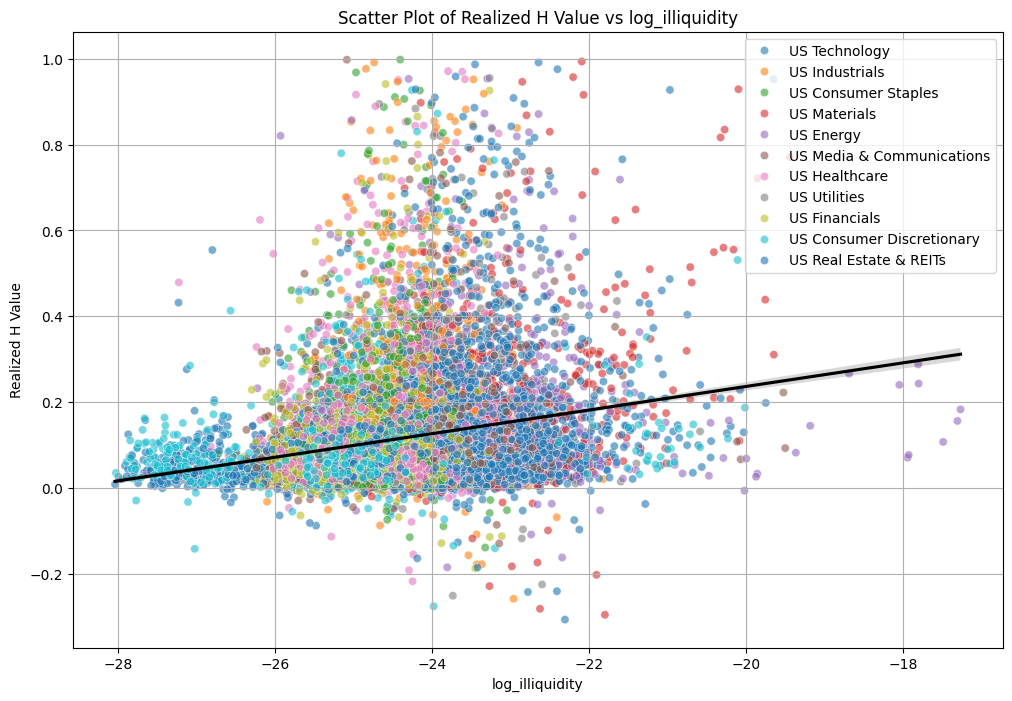

In [261]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.scatterplot(data=Realized_H_vs_illiquidity, x='log_illiquidity', y='Realized_H', hue='industry', palette='tab10', alpha=0.6)
sns.regplot(data=Realized_H_vs_illiquidity, x='log_illiquidity', y='Realized_H', scatter=False, color='black', line_kws={'label': 'Linear Regression'})
plt.xlabel('log_illiquidity')
plt.ylabel('Realized H Value')
plt.title('Scatter Plot of Realized H Value vs log_illiquidity')
plt.legend()
plt.grid(True)
plt.show()

- Again we see a result that doesnt agree with the paper, raising the same concerns.

In [262]:
# Implied_H_vs_illiquidity=Implied_H_vs_illiquidity[Implied_H_vs_illiquidity['Implied_H'].between(0,1)]

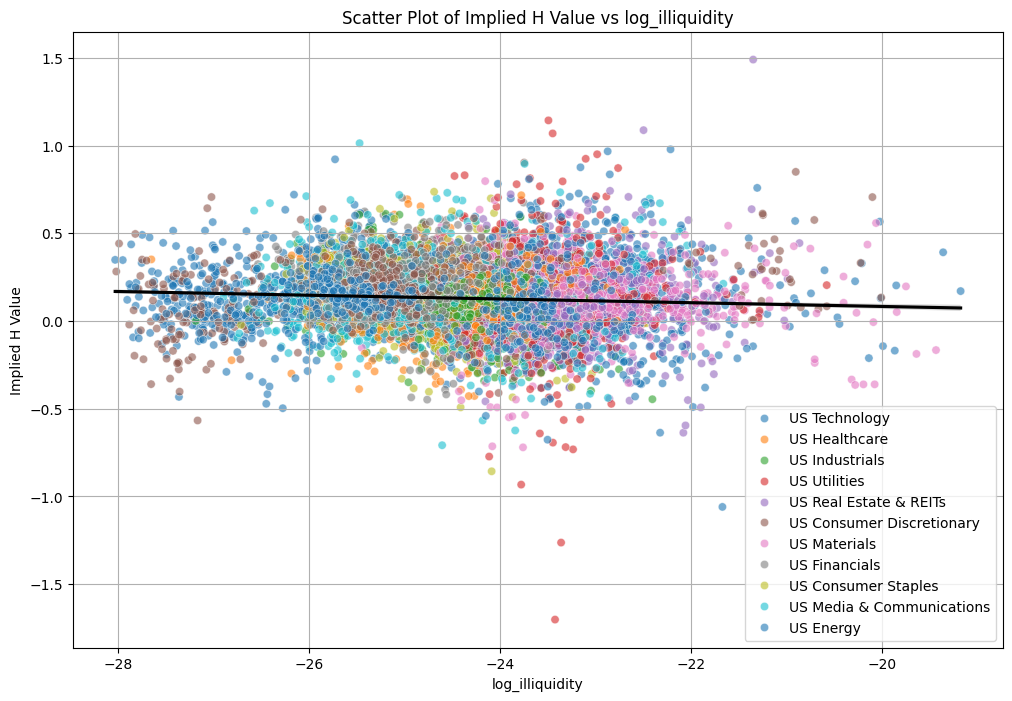

In [263]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.scatterplot(data=Implied_H_vs_illiquidity, x='log_illiquidity', y='Implied_H', hue='industry', palette='tab10', alpha=0.6)
sns.regplot(data=Implied_H_vs_illiquidity, x='log_illiquidity', y='Implied_H', scatter=False, color='black', line_kws={'label': 'Linear Regression'})
plt.xlabel('log_illiquidity')
plt.ylabel('Implied H Value')
plt.title('Scatter Plot of Implied H Value vs log_illiquidity')
plt.legend()
plt.grid(True)
plt.show()

- Implied H vs Illiquidity here, suggests that more illiquidity leads to lower H value again implying that rough - smooth strategy can be earning illiquidity premium.

## Double Sorts

### Objective
We examine whether realized and implied roughness (H) capture return-relevant information beyond standard factors like liquidity, volume, skewness, size, and volatility. Using double sorting, we control for these factors to assess whether roughness independently explains stock returns.


In [113]:
# # ----- Calculate XZZ skew from options data -----
# # Merge options_data with end-of-day prices (using existing prices_eod_primary)
# merged_skew = pd.merge(
#     options_data,
#     prices_eod_primary[['ticker', 'date', 'close']],
#     on=['ticker', 'date'],
#     how='left'
# )

# merged_skew.dropna(subset=['impl_volatility', 'impl_strike', 'close'], inplace=True)
# merged_skew['K/S'] = merged_skew['impl_strike'] / merged_skew['close']
# df_30 = merged_skew[merged_skew['days'] == 30]

# def get_iv_skew(group):
#     # For each group (ticker and date), select:
#     # - The call with K/S closest to 1 (ATM implied volatility)
#     # - The put with K/S closest to 0.9 (for skew measure)
#     call_df = group[group["cp_flag"] == "C"].copy()
#     put_df = group[group["cp_flag"] == "P"].copy()
    
#     sigma_call = np.nan
#     sigma_put = np.nan
    
#     if not call_df.empty:
#         call_df["dist"] = abs(call_df["K/S"] - 1)
#         sigma_call = call_df.nsmallest(1, "dist")["impl_volatility"].iloc[0]
#     if not put_df.empty:
#         put_df["dist"] = abs(put_df["K/S"] - 0.9)
#         sigma_put = put_df.nsmallest(1, "dist")["impl_volatility"].iloc[0]
    
#     return pd.Series({
#         "sigma_call": sigma_call,
#         "sigma_put": sigma_put,
#         "XZZ_skew": sigma_put - sigma_call
#     })

# daily_skew = df_30.groupby(["ticker", "date"]).apply(get_iv_skew).reset_index()
# daily_skew["date"] = pd.to_datetime(daily_skew["date"])
# daily_skew["year_month"] = daily_skew["date"].dt.to_period("M")

# monthly_skew = daily_skew.groupby(["ticker", "year_month"])["XZZ_skew"].mean().reset_index()
# monthly_skew.to_csv('monthly_skew_4.csv', index=False)
# display(monthly_skew.head())


#### The Above code cell calculates monthly Implied Volatility Skewness and saves it in a file monthly_skew.csv

In [114]:
monthly_skew = pd.read_csv('monthly_skew.csv')
monthly_skew['year_month'] = pd.to_datetime(monthly_skew['year_month'])
monthly_skew['year'] = monthly_skew['year_month'].dt.year
monthly_skew['month'] = monthly_skew['year_month'].dt.month
monthly_skew.drop(columns = ['year_month'], inplace=True)

In [115]:
monthly_skew.ticker.nunique()

95

In [116]:
monthly_realized.ticker.nunique()

130

In [117]:
realized_Ht=realized_H.merge(monthly_realized, left_on=['month', 'year', 'ticker'], right_on=['month', 'year', 'ticker'], how='inner')
realized_Htt=realized_Ht.merge(monthly_skew, left_on=['month', 'year', 'ticker'], right_on=['month', 'year', 'ticker'], how='inner')
realized_Htt = realized_Htt[['vol', 'amihud_illiquidity', 'XZZ_skew', 'Realized_H', 'year', 'month', 'ticker', 'price']]
realized_Htt.tail()

vol  amihud_illiquidity  XZZ_skew  Realized_H  year  month  \
13864  1.317802e+08        1.106731e-12  0.026411    0.030113  2023      4   
13865  1.218911e+08        9.288490e-13  0.035748    0.023652  2023      5   
13866  1.638539e+08        6.762842e-13  0.008353    0.035020  2023      6   
13867  1.196715e+08        6.963545e-13  0.005237    0.026858  2023      7   
13868  1.088225e+08        8.701003e-13  0.019618    0.043508  2023      8   

      ticker      price  
13864   TSLA  164.31000  
13865   TSLA  203.92999  
13866   TSLA  261.76999  
13867   TSLA  267.42999  
13868   TSLA  258.07999

In [118]:
H_control_df=realized_Htt.merge(implied_H, left_on=['month', 'year', 'ticker'], right_on=['month', 'year', 'ticker'], how='inner').drop(['Price'], axis=1)
H_control_df.head()

vol  amihud_illiquidity  XZZ_skew  Realized_H  year  month ticker  \
0  3.193766e+07        1.192741e-11  0.062768    0.049828  2010      1   ORCL   
1  3.037651e+07        1.849766e-11  0.073889    0.005427  2010      2   ORCL   
2  2.877642e+07        1.039303e-11  0.042504    0.108720  2010      3   ORCL   
3  2.657337e+07        8.745058e-12  0.033017    0.023036  2010      4   ORCL   
4  3.703376e+07        1.915365e-11  0.055913    7.055720  2010      5   ORCL   

     price  Implied_H  
0  23.0600   0.115609  
1  24.6500   0.180596  
2  25.7100   0.320189  
3  25.8675   0.354995  
4  22.5700   0.126244

In [119]:
H_df = (
    H_control_df
    .groupby(['year', 'month'])
    .apply(lambda grp: grp.assign(
        vol_decile=pd.qcut(grp['vol'], 10, labels=False, duplicates='drop') + 1,
        amihud_decile=pd.qcut(grp['amihud_illiquidity'], 10, labels=False, duplicates='drop') + 1,
        XZZ_decile=pd.qcut(grp['XZZ_skew'], 10, labels=False, duplicates='drop') + 1
    )[["ticker", "price", "vol_decile", "amihud_decile", "XZZ_decile", "year", "month", "Realized_H", "Implied_H"]])
    .reset_index(drop=True)
)

Ht_df = (
    H_df
    .groupby(['year', 'month', 'vol_decile'])
    .apply(lambda grp: grp.assign(
        H_Realized_vol=pd.qcut(grp['Realized_H'], 10, labels=False, duplicates='drop') + 1,
        H_Implied_vol=pd.qcut(grp['Implied_H'], 10, labels=False, duplicates='drop') + 1
    )[["ticker", "price", "vol_decile", "amihud_decile", "XZZ_decile", "year", "month", "Realized_H", "Implied_H", "H_Realized_vol", "H_Implied_vol"]])
    .reset_index(drop=True)
)

Htt_df = (
    Ht_df
    .groupby(['year', 'month', 'amihud_decile'])
    .apply(lambda grp: grp.assign(
        H_Realized_amihud=pd.qcut(grp['Realized_H'], 10, labels=False, duplicates='drop') + 1,
        H_Implied_amihud=pd.qcut(grp['Implied_H'], 10, labels=False, duplicates='drop') + 1
    )[["ticker", "price", "vol_decile", "amihud_decile", "XZZ_decile", "year", "month", "Realized_H", "Implied_H", "H_Realized_vol", "H_Implied_vol", "H_Realized_amihud", "H_Implied_amihud"]])
    .reset_index(drop=True)
)

Httt_df = (
    Htt_df
    .groupby(['year', 'month', 'XZZ_decile'])
    .apply(lambda grp: grp.assign(
        H_Realized_XZZ=pd.qcut(grp['Realized_H'], 10, labels=False, duplicates='drop') + 1,
        H_Implied_XZZ=pd.qcut(grp['Implied_H'], 10, labels=False, duplicates='drop') + 1
    )[["ticker", "price", "vol_decile", "amihud_decile", "XZZ_decile", "year", "month", "Realized_H", "Implied_H", "H_Realized_vol", "H_Implied_vol", "H_Realized_amihud", "H_Implied_amihud", "H_Realized_XZZ", "H_Implied_XZZ"]])
    .reset_index(drop=True)
)
display(Httt_df)
H_control_df_deciles = Httt_df

ticker   price  vol_decile  amihud_decile  XZZ_decile  year  month  \
0         GS  148.72           8              1         1.0  2010      1   
1       AMZN  125.41           7              2         1.0  2010      1   
2        FCX   66.69           9              3         1.0  2010      1   
3        SRE   50.75           3              8         1.0  2010      1   
4        TJX   38.01           5              8         1.0  2010      1   
...      ...     ...         ...            ...         ...   ...    ...   
13806   MDLZ   71.26           7              6        10.0  2023      8   
13807     MO   44.22           8              6        10.0  2023      8   
13808    KMB  128.83           2              8        10.0  2023      8   
13809      O   56.04           7              8        10.0  2023      8   
13810    MLM  446.41           1             10        10.0  2023      8   

       Realized_H  Implied_H  H_Realized_vol  H_Implied_vol  \
0       -0.064310   0.481760             1.0           10.0   
1       -0.001464   0.477744             4.0           10.0   
2        0.017560   0.314935             5.0            2.0   
3        0.174671   0.276119             8.0            9.0   
4        0.154899   0.176601            10.0            5.0   
...           ...        ...             ...            ...   
13806    0.018441   0.182431             2.0            3.0   
13807    0.029202   0.153265             5.0            5.0   
13808    0.015422   0.138837             1.0            5.0   
13809    0.041183   0.171971             7.0            2.0   
13810    0.226400   0.135973             9.0            7.0   

       H_Realized_amihud  H_Implied_amihud  H_Realized_XZZ  H_Implied_XZZ  
0                    1.0               8.0             1.0            9.0  
1                    5.0              10.0             2.0            7.0  
2                    2.0               9.0             3.0            5.0  
3                    8.0               8.0             6.0            4.0  
4                    6.0               1.0             5.0            2.0  
...                  ...               ...             ...            ...  
13806                1.0               4.0             5.0            8.0  
13807                3.0               3.0             7.0            5.0  
13808                2.0               4.0             3.0            3.0  
13809                4.0               7.0             9.0            7.0  
13810               10.0               8.0            10.0            2.0  

[13811 rows x 15 columns]

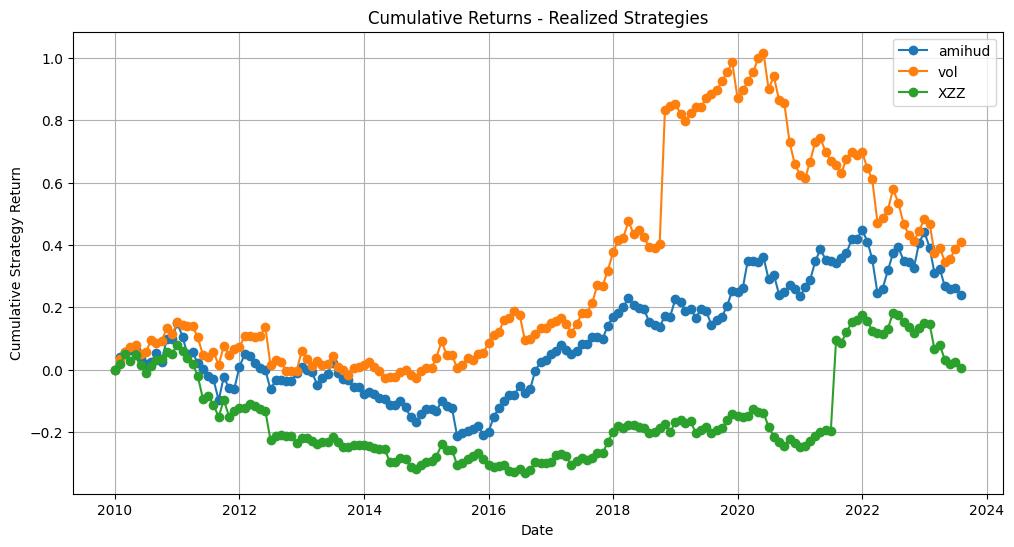

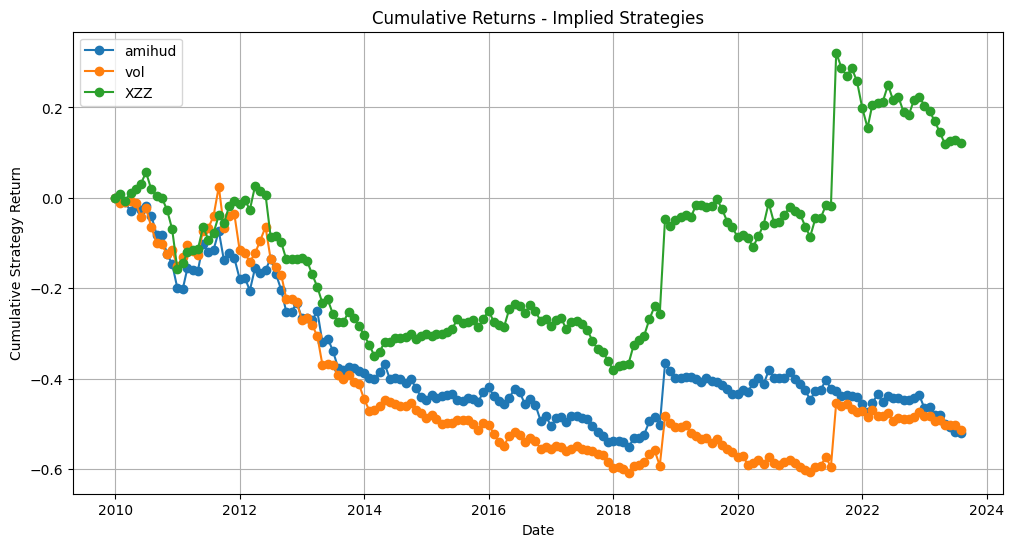


Realized Strategies:

Strategy: amihud
Trade Log:
     year  month  strategy_ret  cum_strategy_ret       date
0    2010      1      0.000000          0.000000 2010-01-01
1    2010      2      0.041767          0.041767 2010-02-01
2    2010      3      0.014908          0.057297 2010-03-01
3    2010      4      0.004523          0.062080 2010-04-01
4    2010      5      0.000405          0.062509 2010-05-01
..    ...    ...           ...               ...        ...
159  2023      4      0.010142          0.324004 2023-04-01
160  2023      5     -0.042858          0.267261 2023-05-01
161  2023      6     -0.007771          0.257412 2023-06-01
162  2023      7      0.002762          0.260885 2023-07-01
163  2023      8     -0.016042          0.240658 2023-08-01

[164 rows x 5 columns]

Performance Metrics:
Average Monthly Return: 0.0017
Monthly Volatility: 0.0294
Annualized Sharpe Ratio: 0.2057
Max Drawdown: -0.3155

Strategy: vol
Trade Log:
     year  month  strategy_ret  cum_strategy_

In [121]:
def trading_strategies_parallel(Ht_df, trading_months_per_year=12):
    # Sort and compute ticker returns (common return)
    Ht_df = Ht_df.sort_values(['ticker', 'year', 'month']).copy()
    Ht_df['ret'] = Ht_df.groupby('ticker')['price'].pct_change().fillna(0)
    
    # Define separate dictionaries for realized and implied H values
    realized_strats = {
        'amihud': 'H_Realized_amihud',
        'vol': 'H_Realized_vol',
        'XZZ': 'H_Realized_XZZ'
    }
    implied_strats = {
        'amihud': 'H_Implied_amihud',
        'vol': 'H_Implied_vol',
        'XZZ': 'H_Implied_XZZ'
    }
    
    # Unique month list sorted by year and month
    months = Ht_df[['year', 'month']].drop_duplicates().sort_values(['year','month'])
    
    # Containers for results for each strategy type
    strat_logs_realized = {}
    strat_metrics_realized = {}
    strat_logs_implied = {}
    strat_metrics_implied = {}
    
    def process_strategies(strategies, logs_dict, metrics_dict):
        for strat, col in strategies.items():
            records = []
            # Loop through months for rebalanced portfolios
            for _, row in months.iterrows():
                yr = row['year']
                mo = row['month']
                month_data = Ht_df[(Ht_df['year'] == yr) & (Ht_df['month'] == mo)]
                # For long portfolio: choose decile 1 or 2; for short: decile 9 or 10
                long_data = month_data[month_data[col].isin([1,2])]
                short_data = month_data[month_data[col].isin([9,10])]
                long_ret = long_data['ret'].mean() if not long_data.empty else 0
                short_ret = short_data['ret'].mean() if not short_data.empty else 0
                strat_ret = long_ret - short_ret
                records.append({'year': yr, 'month': mo, 'strategy_ret': strat_ret})
            trade_log = pd.DataFrame(records)
            # Compute cumulative return using compounding (assume reinvestment)
            trade_log['cum_strategy_ret'] = (1 + trade_log['strategy_ret']).cumprod() - 1
            
            # Create a date column (using 1st day of month)
            trade_log['date'] = pd.to_datetime({'year': trade_log['year'],
                                                  'month': trade_log['month'],
                                                  'day': 1})
            
            # Compute performance metrics
            monthly_ret = trade_log['strategy_ret']
            avg_ret = monthly_ret.mean()
            std_ret = monthly_ret.std()
            sharpe = (avg_ret / std_ret * np.sqrt(trading_months_per_year)) if std_ret != 0 else np.nan
            cum_value = (1 + monthly_ret).cumprod()
            running_max = cum_value.cummax()
            drawdown = cum_value / running_max - 1
            max_drawdown = drawdown.min()
            metrics = {
                "Average Monthly Return": avg_ret,
                "Monthly Volatility": std_ret,
                "Annualized Sharpe Ratio": sharpe,
                "Max Drawdown": max_drawdown,
            }
            logs_dict[strat] = trade_log
            metrics_dict[strat] = metrics
            
    # Process realized and implied strategies separately
    process_strategies(realized_strats, strat_logs_realized, strat_metrics_realized)
    process_strategies(implied_strats, strat_logs_implied, strat_metrics_implied)
    
    # Plot cumulative returns for realized strategies
    plt.figure(figsize=(12,6))
    for strat, trade_log in strat_logs_realized.items():
        plt.plot(trade_log['date'], trade_log['cum_strategy_ret'], marker='o', label=strat)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Strategy Return")
    plt.title("Cumulative Returns - Realized Strategies")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot cumulative returns for implied strategies
    plt.figure(figsize=(12,6))
    for strat, trade_log in strat_logs_implied.items():
        plt.plot(trade_log['date'], trade_log['cum_strategy_ret'], marker='o', label=strat)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Strategy Return")
    plt.title("Cumulative Returns - Implied Strategies")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print trade logs and performance metrics for each strategy type
    print("\nRealized Strategies:")
    for strat in realized_strats.keys():
        print(f"\nStrategy: {strat}")
        print("Trade Log:")
        print(strat_logs_realized[strat])
        print("\nPerformance Metrics:")
        for key, value in strat_metrics_realized[strat].items():
            print(f"{key}: {value:.4f}")
    
    print("\nImplied Strategies:")
    for strat in implied_strats.keys():
        print(f"\nStrategy: {strat}")
        print("Trade Log:")
        print(strat_logs_implied[strat])
        print("\nPerformance Metrics:")
        for key, value in strat_metrics_implied[strat].items():
            print(f"{key}: {value:.4f}")
    
    return (strat_logs_realized, strat_metrics_realized), (strat_logs_implied, strat_metrics_implied)

# Example usage:
# Assume Ht_df is defined and contains the necessary columns.
realized_results, implied_results = trading_strategies_parallel(H_control_df_deciles, trading_months_per_year=12)


### Results:
- Implied H: After controlling for liquidity, volume, and skewness, implied H remains significant, suggesting that implied roughness captures additional pricing information not explained by standard factors.
- Realized H: After controlling for liquidity and size, realized H loses significance, indicating that realized roughness is largely driven by illiquidity and does not provide independent return information.
- Conclusion: 
Implied H contains unique information on returns beyond known factors, while realized H is subsumed by liquidity measures. Thus, implied roughness reflects a priced dimension of risk, whereas realized roughness does not appear to do so independently.

## Fama Macbeth Regressions

In [127]:
daily_ticker = pd.read_csv('daily_ticker_prices.csv')
daily_ticker.drop(['PERMNO', 'RET'], axis=1, inplace=True)
daily_ticker.rename(columns={'TICKER': 'ticker', 'VOL': 'volume', 'PRC': 'price'}, inplace=True)
daily_ticker['return'] = daily_ticker.groupby('ticker')['price'].pct_change()
daily_ticker['date']=pd.to_datetime(daily_ticker['date'])
daily_ticker['year']=daily_ticker['date'].dt.year
daily_ticker['month']=daily_ticker['date'].dt.month
daily_ticker['dollar_volume']=daily_ticker['price']*daily_ticker['volume']
daily_ticker.drop(columns=['price','date'],inplace=True)
daily_ticker.dropna(inplace=True)
monthly_ticker=daily_ticker.groupby(['year','month','ticker']).agg({'dollar_volume':'sum','volume':'sum','return':lambda x: (1+x).prod()-1}).reset_index()
monthly_ticker['log_dollar_volume']=np.log(monthly_ticker['dollar_volume'])
monthly_ticker.rename(columns={'return':'monthly_return'},inplace=True)
monthly_ticker['log_volume']=np.log(monthly_ticker['volume'])
monthly_ticker.drop(columns=['dollar_volume','volume'],inplace=True)
monthly_ticker.sort_values(['year','month'],inplace=True)
monthly_ticker['6m_return'] = monthly_ticker.groupby('ticker')['monthly_return'].rolling(window=6).apply(lambda x: (1+x).prod()-1).reset_index(level=0, drop=True)
monthly_ticker['12m_return'] = monthly_ticker.groupby('ticker')['monthly_return'].rolling(window=12).apply(lambda x: (1+x).prod()-1).reset_index(level=0, drop=True)
monthly_ticker['past_skewness'] = monthly_ticker.groupby('ticker')['monthly_return'].expanding().skew().reset_index(level=0, drop=True)
monthly_ticker['past_volatility'] = monthly_ticker.groupby('ticker')['monthly_return'].expanding().std().reset_index(level=0, drop=True)
monthly_ticker.dropna(inplace=True)
monthly_ticker

year  month ticker  monthly_return  log_dollar_volume  log_volume  \
1141   2010     12   AAPL        0.036670          25.139612   19.368537   
1142   2010     12    ABT        0.030101          22.833806   18.971522   
1143   2010     12    ACN        0.119344          22.112764   18.257086   
1144   2010     12    ADP        0.038367          21.780573   17.939061   
1145   2010     12    AEP        0.010674          21.387586   17.808225   
...     ...    ...    ...             ...                ...         ...   
17682  2023      8   WELL        0.008886          21.950705   17.533015   
17683  2023      8    WFC       -0.105503          23.226105   19.465160   
17684  2023      8    WMB        0.002322          22.233200   18.687288   
17685  2023      8    WMT        0.017203          23.755096   18.687355   
17686  2023      8    XOM        0.036833          24.259097   19.571104   

       6m_return  12m_return  past_skewness  past_volatility  
1141    0.282392    0.507219       0.012691         0.080082  
1142    0.024156   -0.120272      -0.235168         0.045852  
1143    0.254592    0.152603      -0.074525         0.081809  
1144    0.149528    0.080551       0.050514         0.050779  
1145    0.113932    0.029765       0.930949         0.046008  
...          ...         ...            ...              ...  
17682   0.118187    0.081279      -1.350497         0.086515  
17683  -0.117169   -0.055365      -0.300143         0.075149  
17684   0.147176    0.014693      -0.058119         0.094191  
17685   0.144093    0.226782      -0.176836         0.050182  
17686   0.011646    0.163197       0.290193         0.070974  

[16276 rows x 10 columns]

In [ ]:
# def Famamacbeth(monthly_ticker,H_val,H_form='Implied_all'):     #Implied_all,Implied,Realized_all,Realized
#     df_reg=monthly_ticker.copy()
#     df_reg=df_reg.merge(H_val,on=['year','month','ticker'],how='inner')
#     unique_year_month_pairs = df_reg[['year', 'month']].drop_duplicates().sort_values(['year', 'month']).values.tolist()

#     betas={}
#     tvals_abs={}
#     regressors=df_reg.drop(columns=['year','month','ticker','monthly_return']).columns
#     for time_point in unique_year_month_pairs:
#         year, month = time_point
#         df_time=df_reg[(df_reg['year'] == year) & (df_reg['month'] == month)]
#         if H_form=='Implied':
#             X=sm.add_constant(df_time['Implied_H'])
#         elif H_form=='Implied_all':
#             X=sm.add_constant(df_time.drop(columns=['year','month','ticker','monthly_return']))
#         elif H_form=='Realized':
#             X=sm.add_constant(df_time['Realized_H'])
#         elif H_form=='Realized_all':
#             X=sm.add_constant(df_time.drop(columns=['year','month','ticker','monthly_return']))
#         y=df_time['monthly_return']
#         regress=sm.OLS(y,X).fit()
#         betas[(year, month)]=regress.params
#         tvals_abs[(year, month)]=regress.tvalues.abs()

#     betas_df = pd.DataFrame(betas).T
#     betas_mean = betas_df.mean()
#     tvals_abs_df = pd.DataFrame(tvals_abs).T
#     tvals_abs_mean = tvals_abs_df.mean()
    #     return betas_mean,tvals_abs_mean

In [175]:
monthly_ticker

year  month ticker  monthly_return  log_dollar_volume  log_volume  \
1141   2010     12   AAPL        0.036670          25.139612   19.368537   
1142   2010     12    ABT        0.030101          22.833806   18.971522   
1143   2010     12    ACN        0.119344          22.112764   18.257086   
1144   2010     12    ADP        0.038367          21.780573   17.939061   
1145   2010     12    AEP        0.010674          21.387586   17.808225   
...     ...    ...    ...             ...                ...         ...   
17682  2023      8   WELL        0.008886          21.950705   17.533015   
17683  2023      8    WFC       -0.105503          23.226105   19.465160   
17684  2023      8    WMB        0.002322          22.233200   18.687288   
17685  2023      8    WMT        0.017203          23.755096   18.687355   
17686  2023      8    XOM        0.036833          24.259097   19.571104   

       6m_return  12m_return  past_skewness  past_volatility  
1141    0.282392    0.507219       0.012691         0.080082  
1142    0.024156   -0.120272      -0.235168         0.045852  
1143    0.254592    0.152603      -0.074525         0.081809  
1144    0.149528    0.080551       0.050514         0.050779  
1145    0.113932    0.029765       0.930949         0.046008  
...          ...         ...            ...              ...  
17682   0.118187    0.081279      -1.350497         0.086515  
17683  -0.117169   -0.055365      -0.300143         0.075149  
17684   0.147176    0.014693      -0.058119         0.094191  
17685   0.144093    0.226782      -0.176836         0.050182  
17686   0.011646    0.163197       0.290193         0.070974  

[16276 rows x 10 columns]

In [192]:
def Famamacbeth(monthly_ticker, H_val, H_form='Implied_all'):
    import re
    from sklearn.preprocessing import StandardScaler
    df_reg = monthly_ticker.copy()
    df_reg = df_reg.merge(H_val, on=['year','month','ticker'], how='inner')
    unique_year_month_pairs = df_reg[['year', 'month']].drop_duplicates().sort_values(['year', 'month']).values.tolist()

    betas = {}
    tvals_abs = {}
    for time_point in unique_year_month_pairs:
        year, month = time_point
        df_time = df_reg[(df_reg['year'] == year) & (df_reg['month'] == month)]
        std_sc = StandardScaler()
        std_sc.fit_transform(df_time[['log_dollar_volume', 'log_volume', '6m_return', '12m_return', 'past_skewness', 'past_volatility', 'XZZ_skew']])
        if H_form == 'Implied':
            X = sm.add_constant(df_time['Implied_H'])
        elif H_form == 'Implied_all':
            X = sm.add_constant(df_time[['Implied_H', 'log_dollar_volume', 'log_volume', '6m_return', '12m_return', 'past_skewness', 'past_volatility', 'price', 'XZZ_skew']])
        elif H_form == 'Realized':
            X = sm.add_constant(df_time['Realized_H'])
        elif H_form == 'Realized_all':
            X = sm.add_constant(df_time[['Realized_H', 'log_dollar_volume', 'log_volume', '6m_return', '12m_return', 'past_skewness', 'past_volatility', 'price', 'XZZ_skew']])
        X_columns_shifted = [x for x in X.columns if not re.search(r'(const|_H+)', x)]
        X[X_columns_shifted] = X[X_columns_shifted].shift(1)
        y = df_time['monthly_return']
        
        # drop rows with missing values
        data = pd.concat([X, y], axis=1).dropna()
        if data.empty:
            continue
        
        X_clean = data[X.columns]
        y_clean = data['monthly_return']
        regress = sm.OLS(y_clean, X_clean).fit()
        betas[(year, month)] = regress.params
        tvals_abs[(year, month)] = regress.tvalues.abs()
    
    betas_df = pd.DataFrame(betas).T
    tvals_abs_df = pd.DataFrame(tvals_abs).T
    return betas_df.mean(), tvals_abs_df.mean()

In [193]:
# print(monthly_ticker.head())
# print(implied_H.head())
a,b=Famamacbeth(monthly_ticker,H_control_df,H_form='Implied_all')
print(f'Betas are:\n{a}')
print()
print(f'Corresponding t-values are:\n {b}')

Betas are:
const               -0.013480
Implied_H            0.020689
log_dollar_volume    0.003665
log_volume          -0.003331
6m_return           -0.006894
12m_return           0.004577
past_skewness        0.000452
past_volatility      0.050014
price               -0.000034
XZZ_skew             0.003240
dtype: float64

Corresponding t-values are:
 const                0.893719
Implied_H            1.099886
log_dollar_volume    0.795743
log_volume           0.769889
6m_return            0.912748
12m_return           0.770010
past_skewness        0.789345
past_volatility      0.916878
price                0.786058
XZZ_skew             0.873274
dtype: float64


In [189]:
a,b=Famamacbeth(monthly_ticker,H_control_df,H_form='Realized_all')
print(f'Betas are:\n{a}')
print()
print(f'Corresponding t-values are:\n {b}')

Betas are:
const               -0.017238
Realized_H           0.007453
log_dollar_volume    0.003717
log_volume          -0.003040
6m_return           -0.005549
12m_return           0.004194
past_skewness        0.000410
past_volatility      0.051206
price               -0.000032
XZZ_skew            -0.004747
dtype: float64

Corresponding t-values are:
 const                0.893994
Realized_H           0.909567
log_dollar_volume    0.827922
log_volume           0.785230
6m_return            0.938136
12m_return           0.810085
past_skewness        0.785561
past_volatility      0.924367
price                0.796556
XZZ_skew             0.856410
dtype: float64
